## MML: Multimodal Data Cleaning 

This script will process and filter all the modalities 
- Audio: from raw (denoised) to pitch 
- ECG: filtered signal with bandpass and notch filer 
- EMG1 EMG 2: filtered with 
- RESP: filtered wit

### 0. Import all necessary packages


In [67]:
import os
from os import listdir
import numpy as np
import csv #csv saving
import pandas as pd
import math #basic operations
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch
import glob
import matplotlib.pyplot as plt
import tkinter # GUI toolkit to open and save files
from tkinter import filedialog, messagebox  # GUI toolkit to open and save files
from scipy.signal import butter, filtfilt, iirnotch
import librosa
import librosa.display
import tempfile
import shutil
import tqdm
from scipy.ndimage import uniform_filter1d
import emd


print("Everything imported successfully")

Everything imported successfully


#### 1. Defyining key Directories, Variables & Functions




In [68]:
input_folder = r"D:\Mobile-Multimodal-Lab\4_PROCESSED\raw_trials"
output_folder = r"D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials"
print("Input folder:", input_folder)
print("Output folder:", output_folder)  

## --- FUNCTIONS --- ##

### ------------------------------------------
### Core Filtering Functions
### ------------------------------------------

def butter_filter(data, cutoff, fs, order=4, filter_type='low'):
    """
    General-purpose Butterworth filter (low, high, or bandpass) with zero-phase filtering.
    Padding is applied to avoid edge artifacts.

    Parameters:
    - data: Signal to filter (1D array)
    - cutoff: Cutoff frequency (float for low/high, tuple for bandpass)
    - fs: Sampling rate in Hz
    - order: Filter order
    - filter_type: 'low', 'high', or 'band'

    Returns:
    - Filtered signal (same length as input)
    """
    nyquist = 0.5 * fs
    if filter_type == 'band':
        low, high = cutoff
        normal_cutoff = [low / nyquist, high / nyquist]
    else:
        normal_cutoff = cutoff / nyquist

    b, a = butter(order, normal_cutoff, btype=filter_type, analog=False)
    padded_data = np.pad(data, (1000, 1000), mode='edge')
    filtered_data = filtfilt(b, a, padded_data)
    return filtered_data[1000:-1000]

def notch_filter(signal, fs, notch_freq=50, quality_factor=30):
    """
    Notch filter to remove powerline interference at specified frequency.
    
    Parameters:
    - signal: 1D array of the signal
    - fs: Sampling rate
    - notch_freq: Frequency to notch out (e.g., 50 or 60 Hz)
    - quality_factor: Q-factor determining notch sharpness
    
    Returns:
    - Filtered signal
    """
    b, a = iirnotch(notch_freq / (fs / 2), quality_factor)
    return filtfilt(b, a, signal)


### ------------------------------------------
### Signal-Specific Processing Functions
### ------------------------------------------

def process_ecg(ecg_signal, fs, cutoff_high=0.5, cutoff_low=40, notch_freq=50, quality_factor=30):
    """
    Cleans ECG signal by applying high-pass, low-pass, and notch filters.
    """
    high_passed = butter_filter(ecg_signal, cutoff_high, fs, order=4, filter_type='high')
    low_passed = butter_filter(high_passed, cutoff_low, fs, order=4, filter_type='low')
    filtered = notch_filter(low_passed, fs, notch_freq, quality_factor)
    return filtered

def process_emg(emg_signal, fs, cutoff_high=20, cutoff_low=10):
    """
    Processes EMG by high-pass filtering, rectifying, then low-pass filtering.
    """
    high_passed = butter_filter(emg_signal, cutoff_high, fs, order=4, filter_type='high')
    rectified = np.abs(high_passed)
    return butter_filter(rectified, cutoff_low, fs, order=4, filter_type='low')

def process_respiration(resp_signal, fs, lowpass_cutoff=1.0):
    """
    Low-pass filters respiration signal to retain only breathing patterns.
    """
    return butter_filter(resp_signal, lowpass_cutoff, fs, order=4, filter_type='low')


### ------------------------------------------
### Audio Feature Extraction
### ------------------------------------------

def extract_pitch_yin(audio, sr, fmin=50, fmax=400, frame_length=2048, hop_length=512, trough_threshold=0.1):
    """
    Extracts pitch (F0) from audio using librosa's YIN algorithm.
    Returns both pitch values and time vector.
    """
    f0 = librosa.yin(audio, fmin=fmin, fmax=fmax, sr=sr,
                     frame_length=frame_length, hop_length=hop_length,
                     trough_threshold=trough_threshold)
    times = librosa.times_like(f0, sr=sr, hop_length=hop_length)
    return f0, times

def amp_envelope(audiofilename):
    """
    Extracts amplitude envelope from audio by applying bandpass, rectification,
    lowpass filtering, and scaling to 0–1.
    """
    audio, sr = librosa.load(audiofilename, sr=None)
    # Apply bandpass filter between 400–4000 Hz
    data = butter_filter(audio, 400, sr, order=2, filter_type='high')
    data = butter_filter(data, 4000, sr, order=2, filter_type='low')
    # Rectify and smooth
    data = np.abs(data)
    data = butter_filter(data, 10, sr, order=2, filter_type='low')
    # Normalize
    return (data - np.min(data)) / (np.max(data) - np.min(data)), sr


# Empirical Mode Decomposition
def my_get_next_imf(x, zoom=None, sd_thresh=0.1):
    proto_imf = x.copy()
    continue_sift = True
    niters = 0

    if zoom is None:
        zoom = (0, x.shape[0])

    while continue_sift:
        niters += 1
        upper_env = emd.sift.interp_envelope(proto_imf, mode='upper')
        lower_env = emd.sift.interp_envelope(proto_imf, mode='lower')
        avg_env = (upper_env+lower_env) / 2
        stop, val = emd.sift.stop_imf_sd(proto_imf-avg_env, proto_imf, sd=sd_thresh)
        proto_imf = proto_imf - avg_env
        if stop:
            continue_sift = False

    return proto_imf



### ---KEYWORDS--- ###
participants = ['P1', 'P2']
audio_keyword = 'denoised'




Input folder: D:\Mobile-Multimodal-Lab\4_PROCESSED\raw_trials
Output folder: D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials


### Extracting Amplitude from the Raw Audio. 

In [ ]:
for root, dirs, files in os.walk(input_folder):  # Loop through all files in the input directory
    for file in files:                           # Loop through all files in the input directory
        for P in participants:                   # Loop through P1 and P2
            # Find the LSL csv file
            if P in file and 'Mic' in file and file.endswith(".csv"):   # Check if the file contains the keyword and is a .csv file
                print("Processing LSL file: ", os.path.basename(file))
                LSL_filename = os.path.join(root, file)
                LSL_data = pd.read_csv(LSL_filename)
                LSL_Time = LSL_data['LSL_Time']
                # Get the start and end time of the LSL
                start_time = LSL_Time.iloc[0]
                end_time = LSL_Time.iloc[-1]
                duration = end_time - start_time  # Total duration of the LSL time

            # Find the corresponding audio file
            if P in file and audio_keyword in file and file.endswith(".wav"):
                print("Processing audio file: ", os.path.basename(file))
                audio_filename = os.path.join(root, file)
                
                # Extract amplitude envelope using the predefined function
                print("Extracting amplitude envelope...")
                envelope_normalized, sr = amp_envelope(audio_filename)
                print("The sample rate of the audio file is: ", sr)

                # Generate time array
                times = np.linspace(0, len(envelope_normalized) / sr, len(envelope_normalized))

                # Save the amplitude envelope to data frame
                envelope_df = pd.DataFrame({
                    'Time': times,
                    'Amplitude_Envelope': envelope_normalized
                })

                # Create the output CSV file
                filename_base = os.path.basename(file)
                parts = filename_base.split('_')
                new_name = '_'.join(parts[:7]).replace('Mic', 'AudioEnvelope')
                output_filename = os.path.join(output_folder, new_name + '.csv')
                envelope_df.to_csv(output_filename, index=False)
                print("Amplitude envelope data saved to: ", output_filename)

                ## PLOTTING ##
                audio_data, _ = librosa.load(audio_filename, sr=sr)
                plt.figure(figsize=(12, 8))
                plt.subplot(2, 1, 1)
                plt.plot(np.linspace(0, len(audio_data) / sr, len(audio_data)), audio_data, label='Raw Audio', color='gray')
                plt.title('Raw Audio Signal')

                plt.subplot(2, 1, 2)
                plt.plot(times, envelope_normalized, label='Amplitude Envelope', color='blue')
                plt.title('Amplitude Envelope')
                plt.xlabel('Time (s)')
                plt.tight_layout()
                plt.show()



### ECG Filtering with 

Processing LSL file:  T1_experiment_PLUX_P1_NoVision_Movement_0_StartParticipantSinging_NoVision_Movement_0_EndParticipantSinging.csv
the sample rate of the ECG file is:  1000


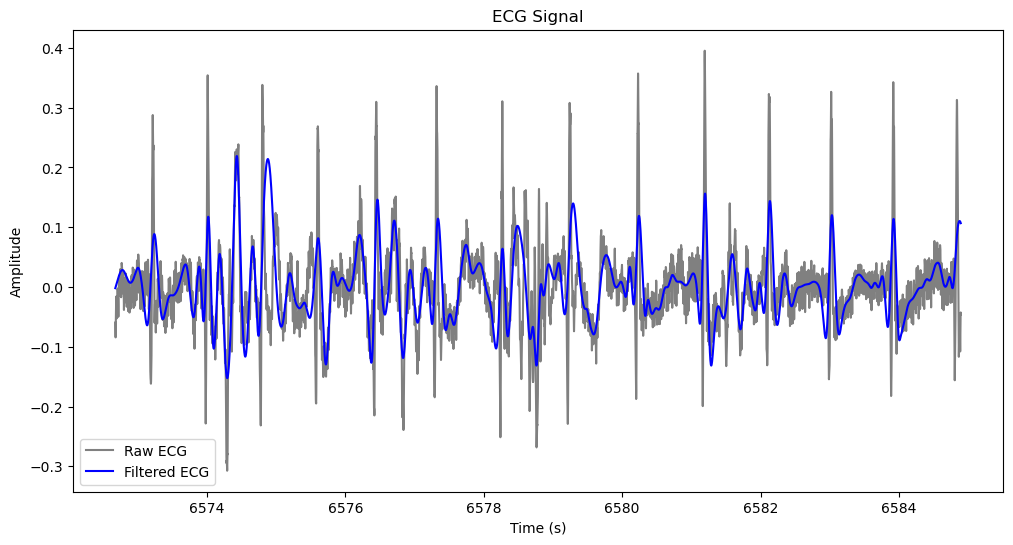

Filtered ECG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_ECG_P1_NoVision_Movement_0.csv
Processing LSL file:  T1_experiment_PLUX_P1_NoVision_Movement_1_StartParticipantSinging_NoVision_Movement_1_EndParticipantSinging.csv
the sample rate of the ECG file is:  1000


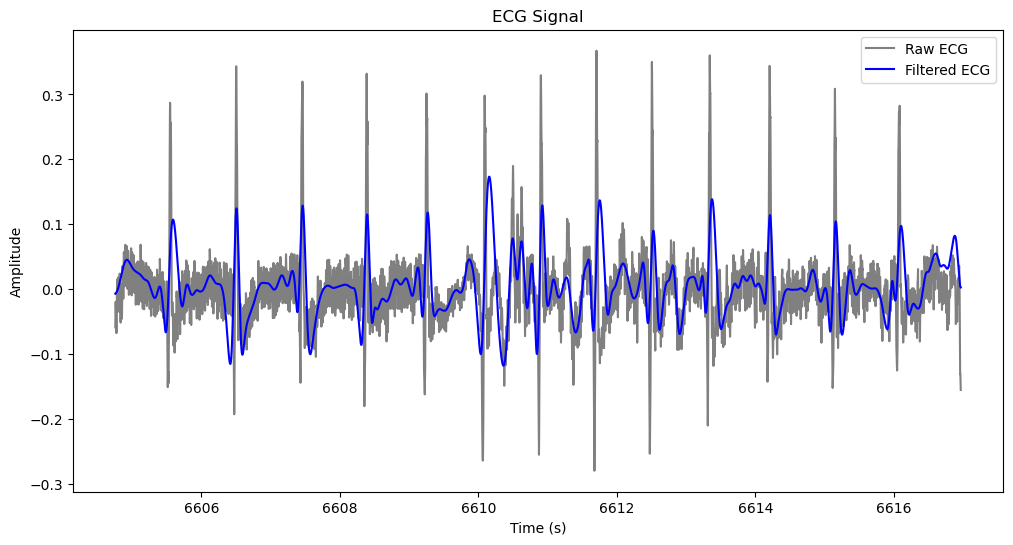

Filtered ECG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_ECG_P1_NoVision_Movement_1.csv
Processing LSL file:  T1_experiment_PLUX_P1_NoVision_Movement_2_StartParticipantSinging_NoVision_Movement_2_EndParticipantSinging.csv
the sample rate of the ECG file is:  1000


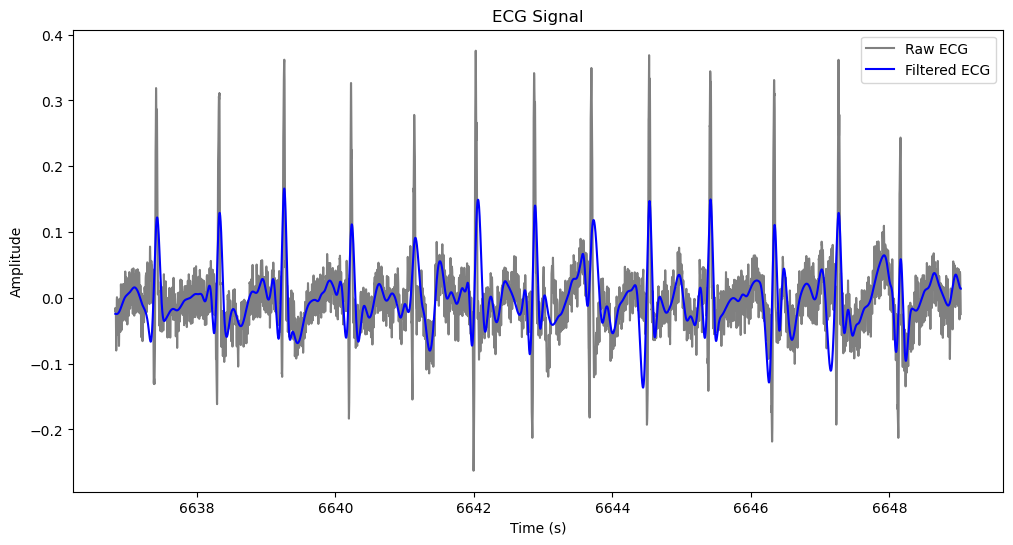

Filtered ECG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_ECG_P1_NoVision_Movement_2.csv
Processing LSL file:  T1_experiment_PLUX_P1_NoVision_Movement_3_StartParticipantSinging_NoVision_Movement_3_EndParticipantSinging.csv
the sample rate of the ECG file is:  1000


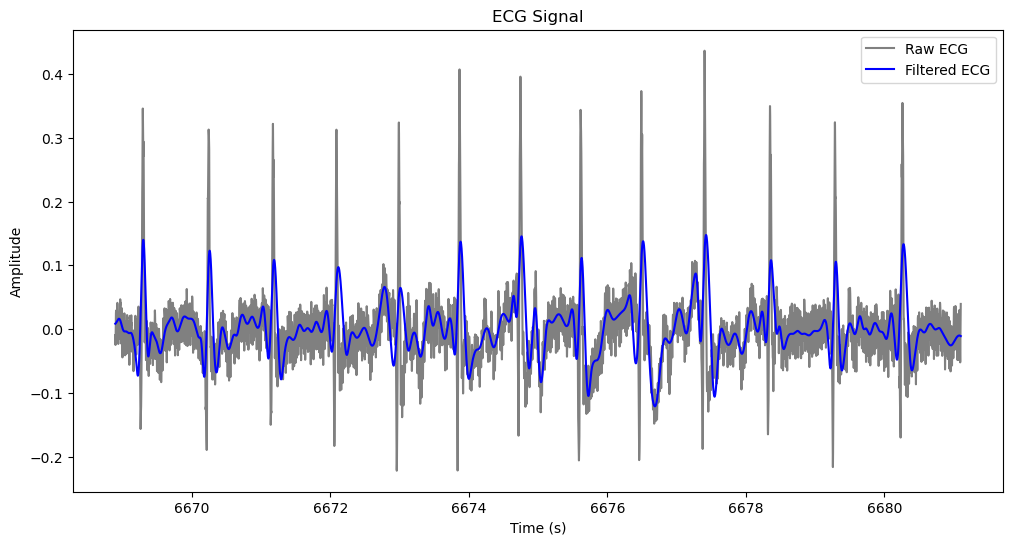

Filtered ECG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_ECG_P1_NoVision_Movement_3.csv
Processing LSL file:  T1_experiment_PLUX_P1_NoVision_Movement_4_StartParticipantSinging_NoVision_Movement_4_EndParticipantSinging.csv
the sample rate of the ECG file is:  1000


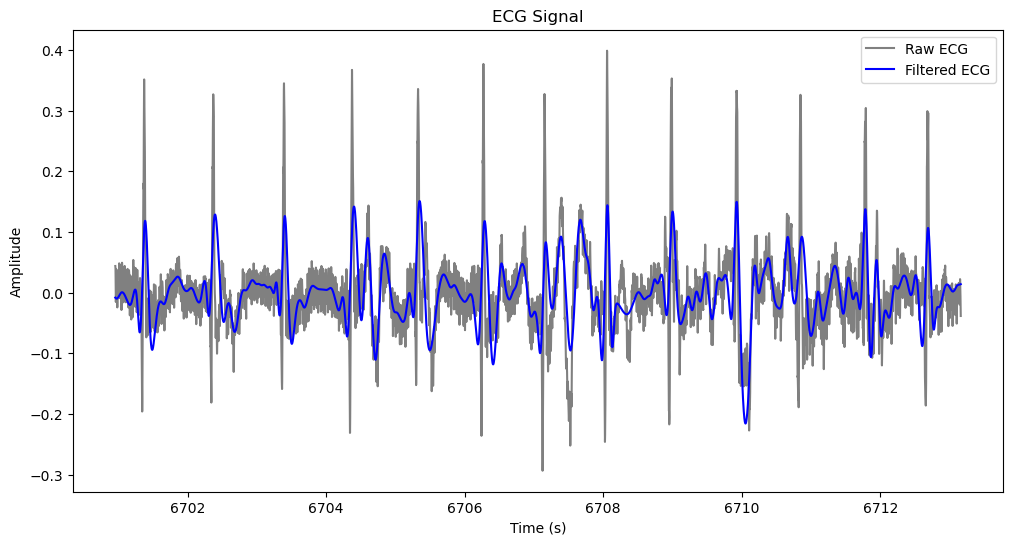

Filtered ECG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_ECG_P1_NoVision_Movement_4.csv
Processing LSL file:  T1_experiment_PLUX_P1_NoVision_NoMovement_0_StartParticipantSinging_NoVision_NoMovement_0_EndParticipantSinging.csv
the sample rate of the ECG file is:  1000


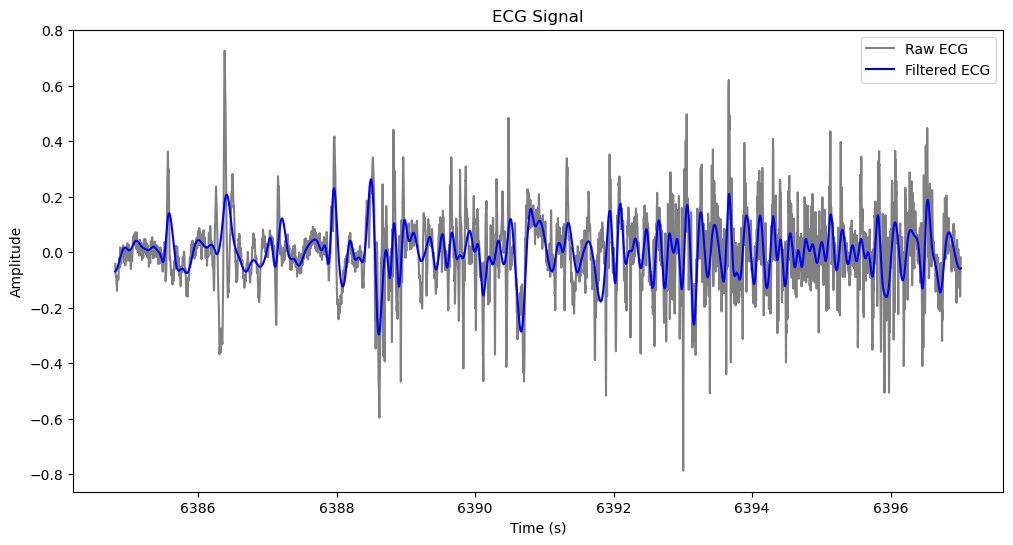

Filtered ECG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_ECG_P1_NoVision_NoMovement_0.csv
Processing LSL file:  T1_experiment_PLUX_P1_NoVision_NoMovement_1_StartParticipantSinging_NoVision_NoMovement_1_EndParticipantSinging.csv
the sample rate of the ECG file is:  1000


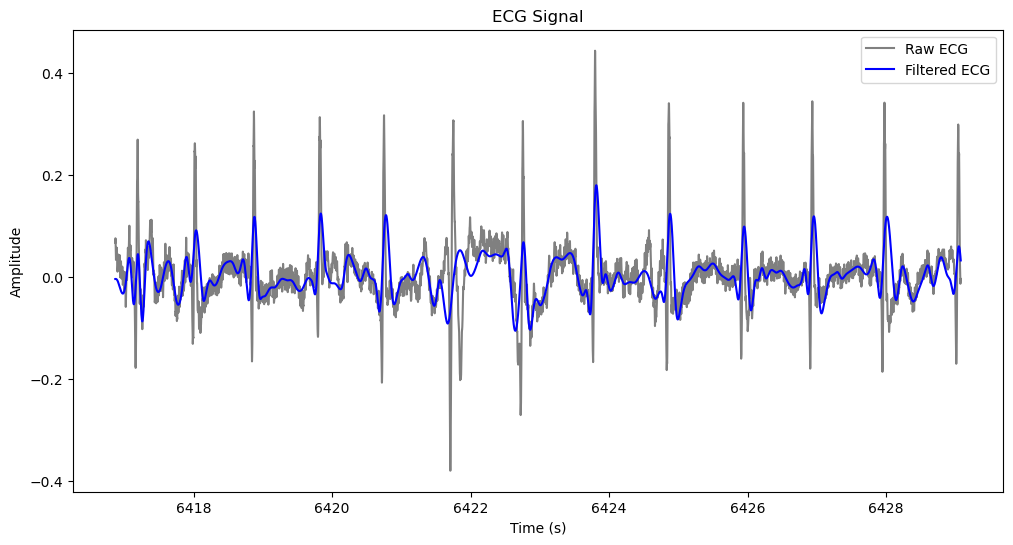

Filtered ECG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_ECG_P1_NoVision_NoMovement_1.csv
Processing LSL file:  T1_experiment_PLUX_P1_NoVision_NoMovement_2_StartParticipantSinging_NoVision_NoMovement_2_EndParticipantSinging.csv
the sample rate of the ECG file is:  1000


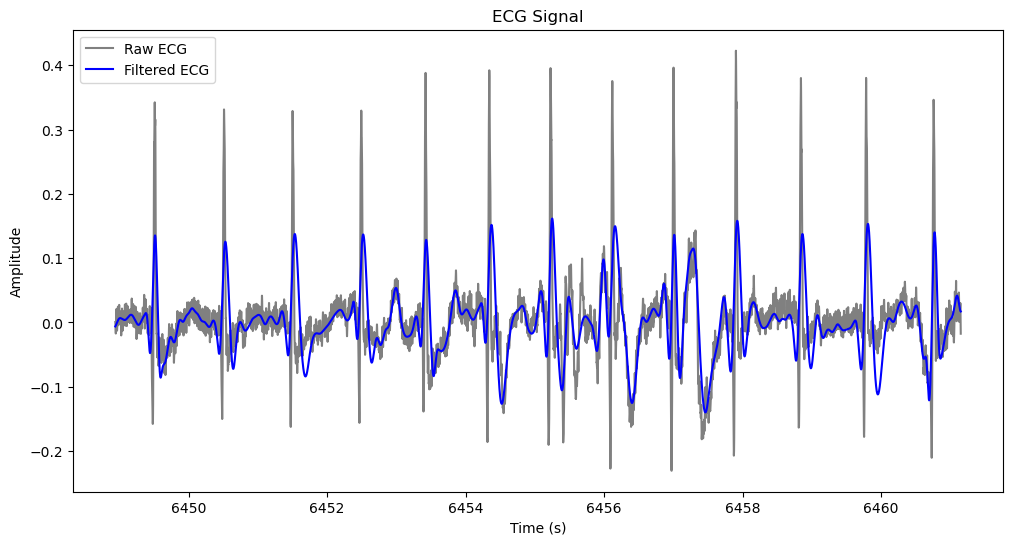

Filtered ECG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_ECG_P1_NoVision_NoMovement_2.csv
Processing LSL file:  T1_experiment_PLUX_P1_NoVision_NoMovement_3_StartParticipantSinging_NoVision_NoMovement_3_EndParticipantSinging.csv
the sample rate of the ECG file is:  1000


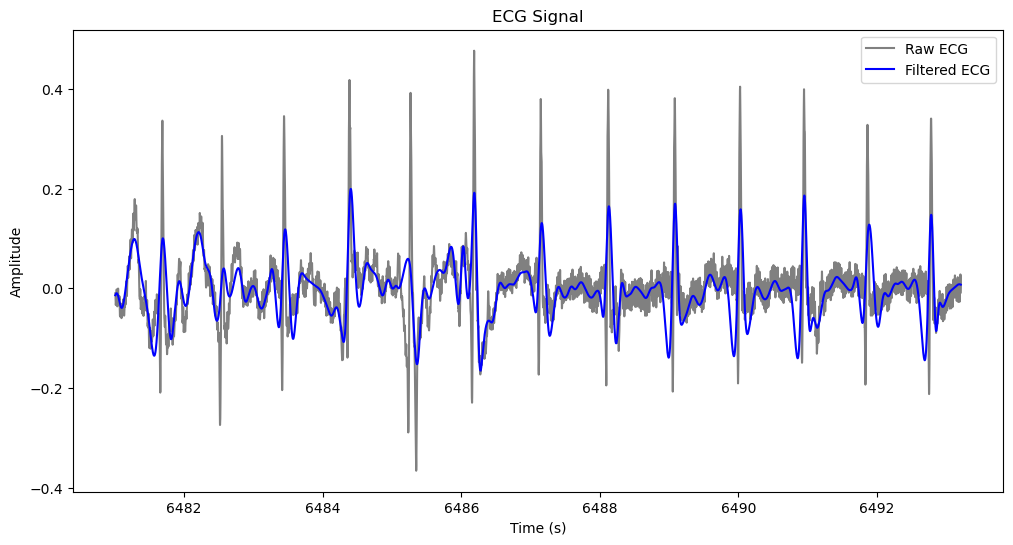

Filtered ECG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_ECG_P1_NoVision_NoMovement_3.csv
Processing LSL file:  T1_experiment_PLUX_P1_NoVision_NoMovement_4_StartParticipantSinging_NoVision_NoMovement_4_EndParticipantSinging.csv
the sample rate of the ECG file is:  1000


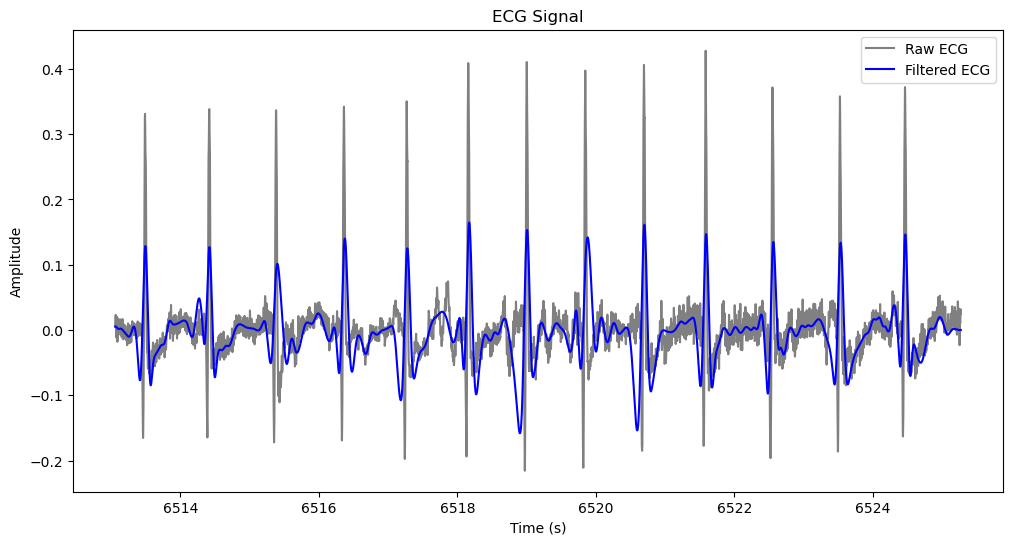

Filtered ECG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_ECG_P1_NoVision_NoMovement_4.csv
Processing LSL file:  T1_experiment_PLUX_P1_Vision_Movement_0_StartParticipantSinging_Vision_Movement_0_EndParticipantSinging.csv
the sample rate of the ECG file is:  1000


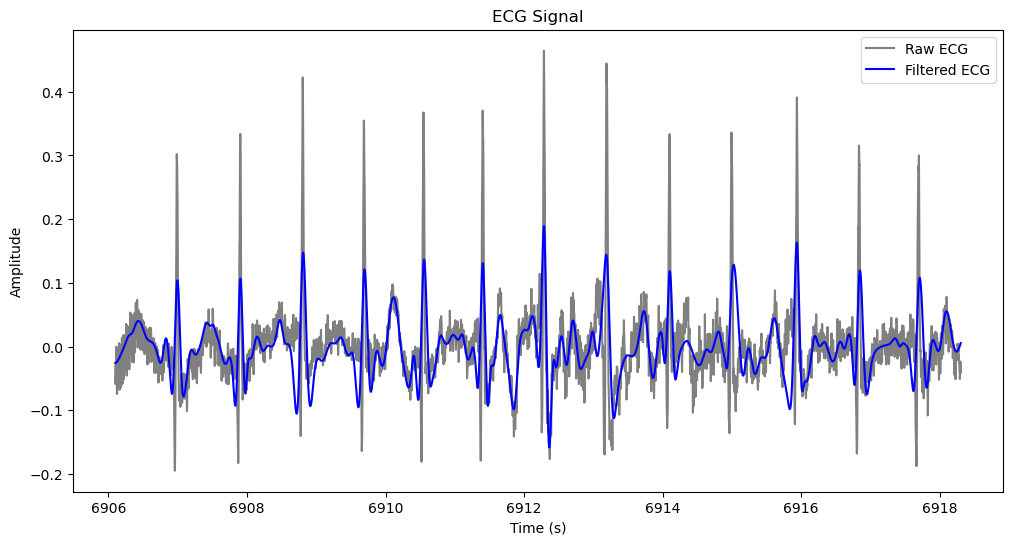

Filtered ECG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_ECG_P1_Vision_Movement_0.csv
Processing LSL file:  T1_experiment_PLUX_P1_Vision_Movement_1_StartParticipantSinging_Vision_Movement_1_EndParticipantSinging.csv
the sample rate of the ECG file is:  1000


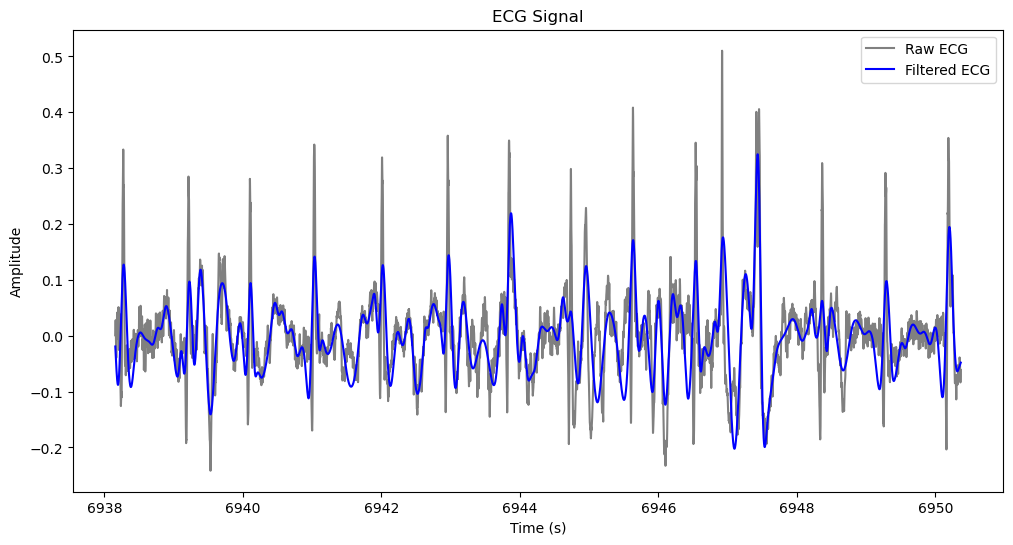

Filtered ECG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_ECG_P1_Vision_Movement_1.csv
Processing LSL file:  T1_experiment_PLUX_P1_Vision_Movement_2_StartParticipantSinging_Vision_Movement_2_EndParticipantSinging.csv
the sample rate of the ECG file is:  1000


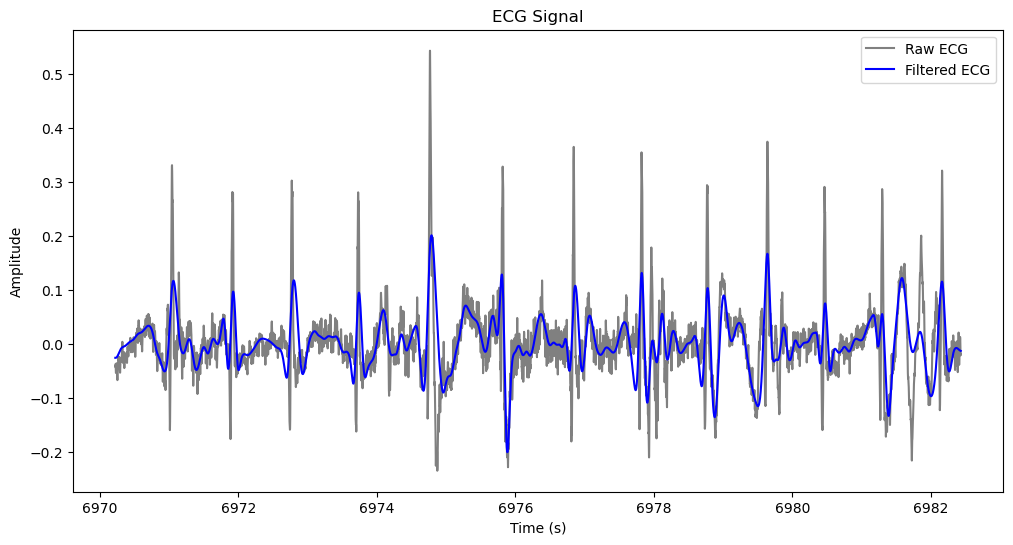

Filtered ECG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_ECG_P1_Vision_Movement_2.csv
Processing LSL file:  T1_experiment_PLUX_P1_Vision_Movement_3_StartParticipantSinging_Vision_Movement_3_EndParticipantSinging.csv
the sample rate of the ECG file is:  1000


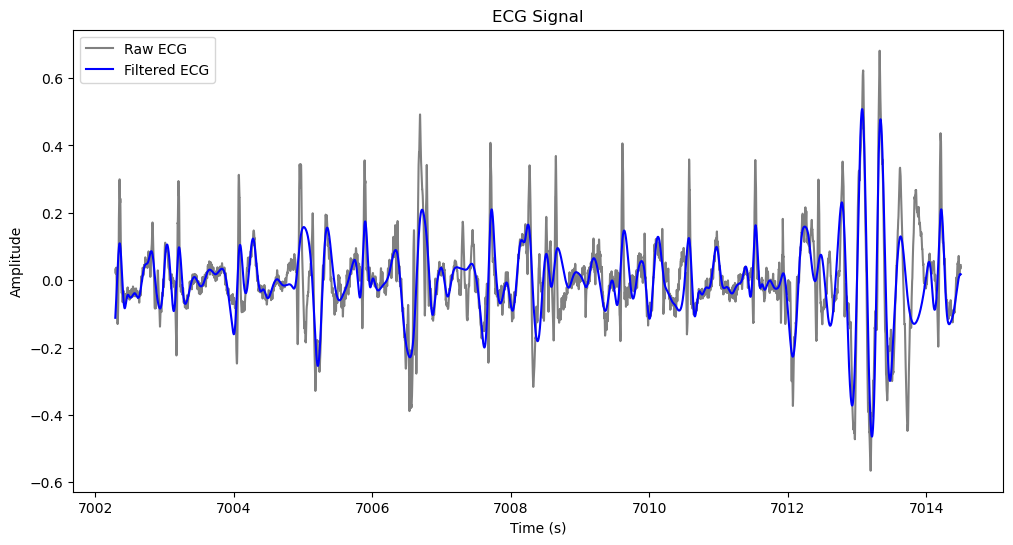

Filtered ECG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_ECG_P1_Vision_Movement_3.csv
Processing LSL file:  T1_experiment_PLUX_P1_Vision_Movement_4_StartParticipantSinging_Vision_Movement_4_EndParticipantSinging.csv
the sample rate of the ECG file is:  1000


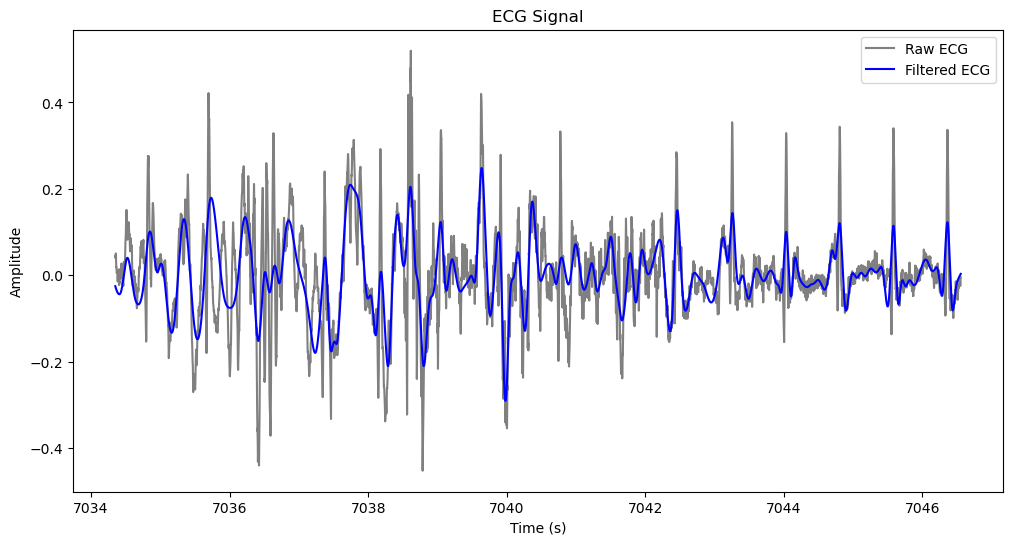

Filtered ECG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_ECG_P1_Vision_Movement_4.csv
Processing LSL file:  T1_experiment_PLUX_P1_Vision_NoMovement_0_StartParticipantSinging_Vision_NoMovement_0_EndParticipantSinging.csv
the sample rate of the ECG file is:  1000


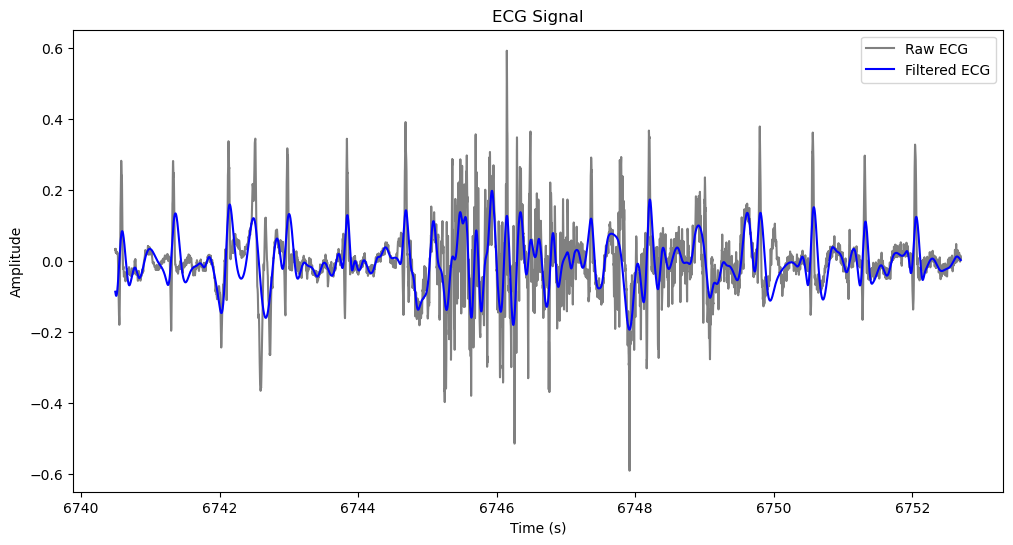

Filtered ECG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_ECG_P1_Vision_NoMovement_0.csv
Processing LSL file:  T1_experiment_PLUX_P1_Vision_NoMovement_1_StartParticipantSinging_Vision_NoMovement_1_EndParticipantSinging.csv
the sample rate of the ECG file is:  1000


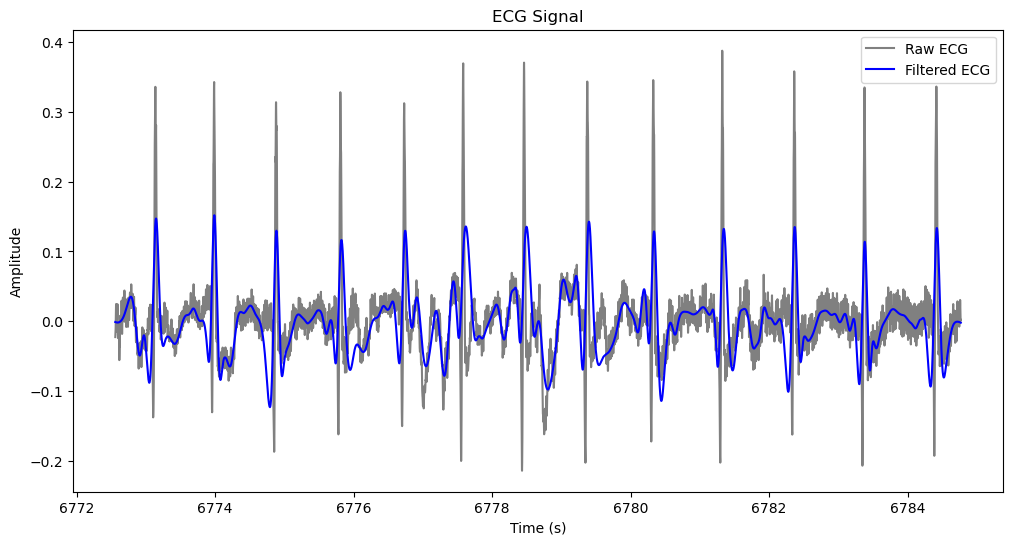

Filtered ECG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_ECG_P1_Vision_NoMovement_1.csv
Processing LSL file:  T1_experiment_PLUX_P1_Vision_NoMovement_2_StartParticipantSinging_Vision_NoMovement_2_EndParticipantSinging.csv
the sample rate of the ECG file is:  1000


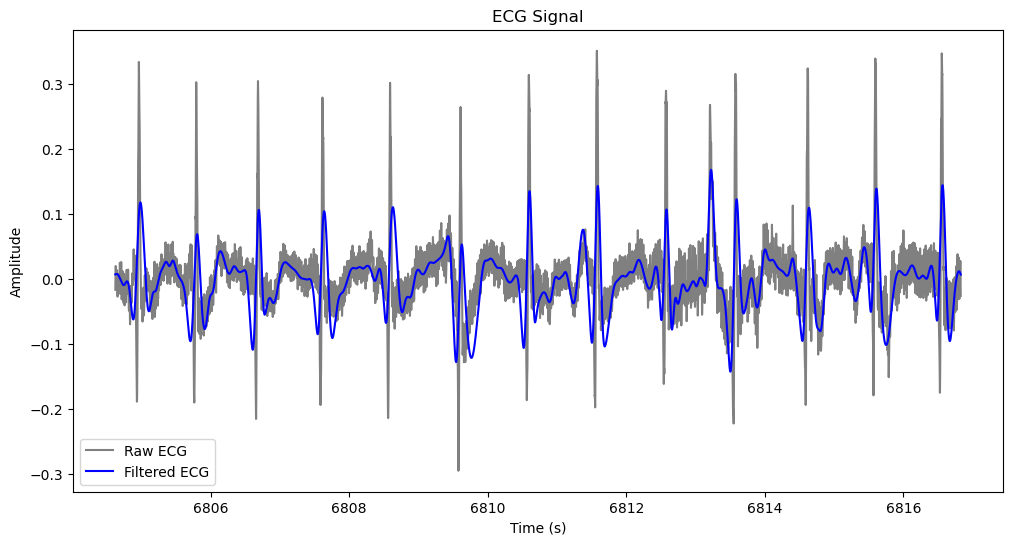

Filtered ECG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_ECG_P1_Vision_NoMovement_2.csv
Processing LSL file:  T1_experiment_PLUX_P1_Vision_NoMovement_3_StartParticipantSinging_Vision_NoMovement_3_EndParticipantSinging.csv
the sample rate of the ECG file is:  1000


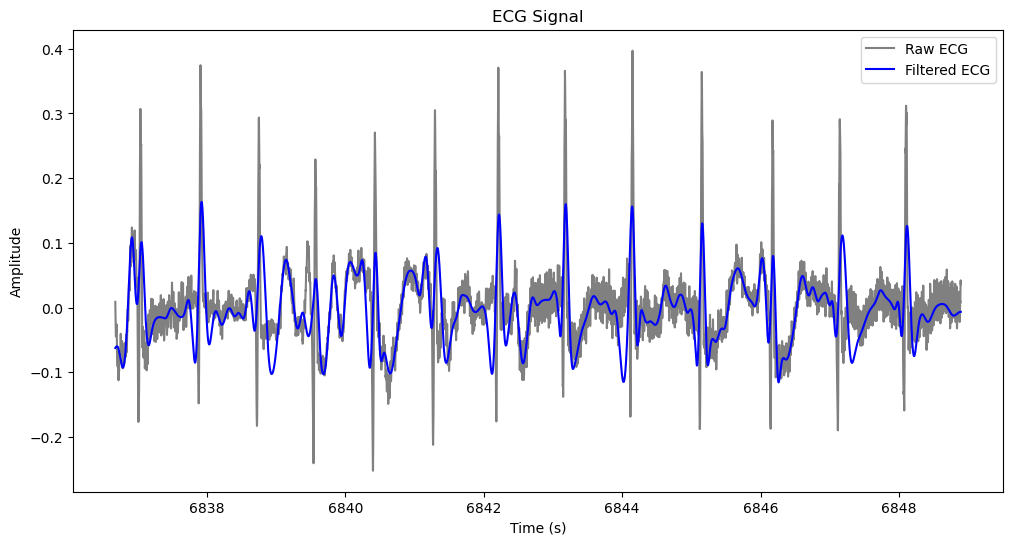

Filtered ECG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_ECG_P1_Vision_NoMovement_3.csv
Processing LSL file:  T1_experiment_PLUX_P1_Vision_NoMovement_4_StartParticipantSinging_Vision_NoMovement_4_EndParticipantSinging.csv
the sample rate of the ECG file is:  1000


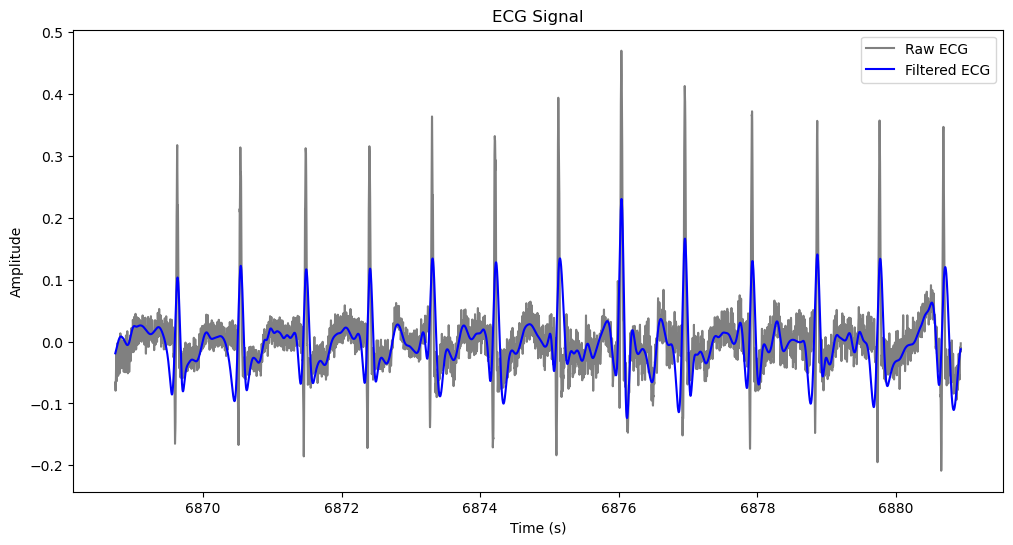

Filtered ECG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_ECG_P1_Vision_NoMovement_4.csv
Processing LSL file:  T1_experiment_PLUX_P2_NoVision_Movement_0_StartParticipantSinging_NoVision_Movement_0_EndParticipantSinging.csv
the sample rate of the ECG file is:  1000


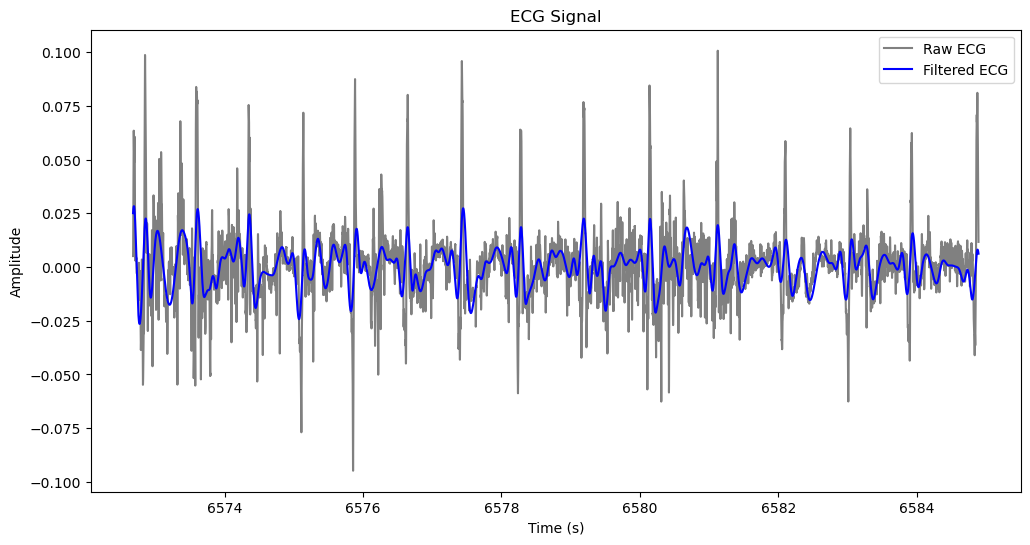

Filtered ECG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_ECG_P2_NoVision_Movement_0.csv
Processing LSL file:  T1_experiment_PLUX_P2_NoVision_Movement_1_StartParticipantSinging_NoVision_Movement_1_EndParticipantSinging.csv
the sample rate of the ECG file is:  1000


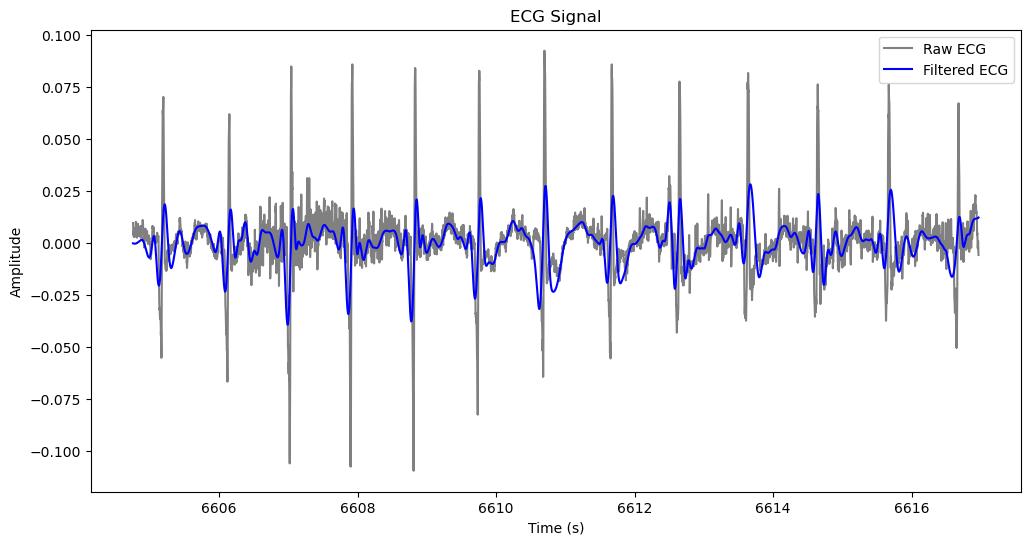

Filtered ECG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_ECG_P2_NoVision_Movement_1.csv
Processing LSL file:  T1_experiment_PLUX_P2_NoVision_Movement_2_StartParticipantSinging_NoVision_Movement_2_EndParticipantSinging.csv
the sample rate of the ECG file is:  1000


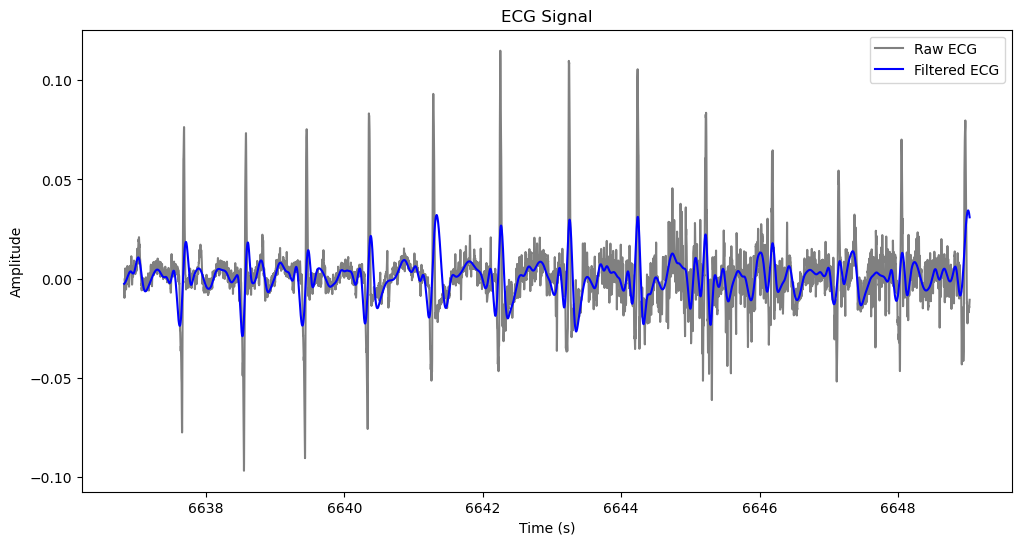

Filtered ECG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_ECG_P2_NoVision_Movement_2.csv
Processing LSL file:  T1_experiment_PLUX_P2_NoVision_Movement_3_StartParticipantSinging_NoVision_Movement_3_EndParticipantSinging.csv
the sample rate of the ECG file is:  1000


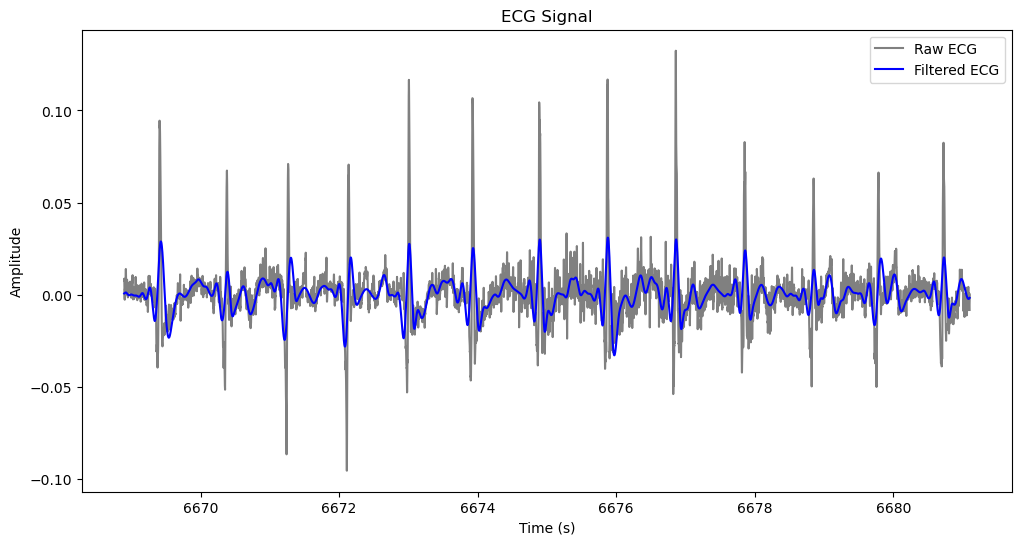

Filtered ECG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_ECG_P2_NoVision_Movement_3.csv
Processing LSL file:  T1_experiment_PLUX_P2_NoVision_Movement_4_StartParticipantSinging_NoVision_Movement_4_EndParticipantSinging.csv
the sample rate of the ECG file is:  1000


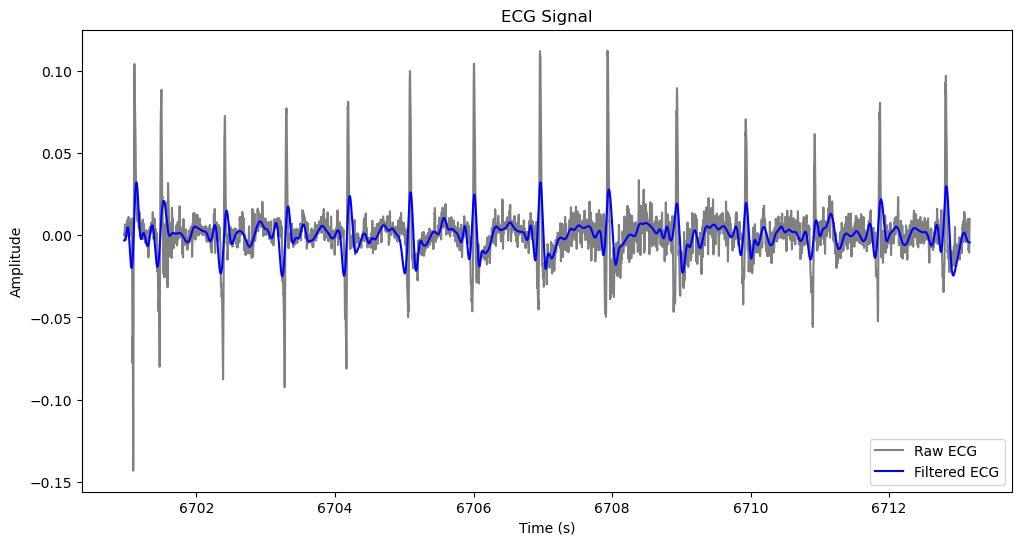

Filtered ECG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_ECG_P2_NoVision_Movement_4.csv
Processing LSL file:  T1_experiment_PLUX_P2_NoVision_NoMovement_0_StartParticipantSinging_NoVision_NoMovement_0_EndParticipantSinging.csv
the sample rate of the ECG file is:  1000


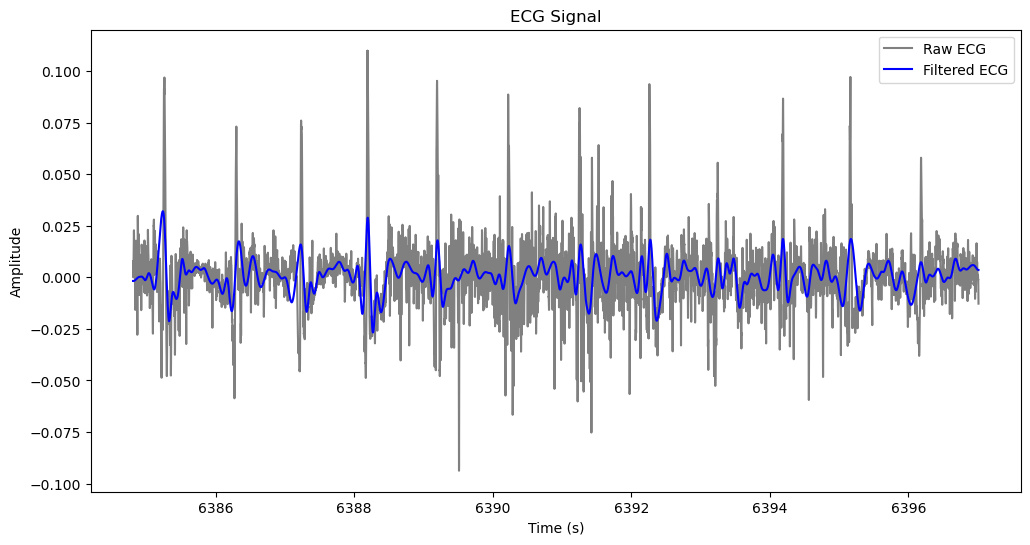

Filtered ECG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_ECG_P2_NoVision_NoMovement_0.csv
Processing LSL file:  T1_experiment_PLUX_P2_NoVision_NoMovement_1_StartParticipantSinging_NoVision_NoMovement_1_EndParticipantSinging.csv
the sample rate of the ECG file is:  1000


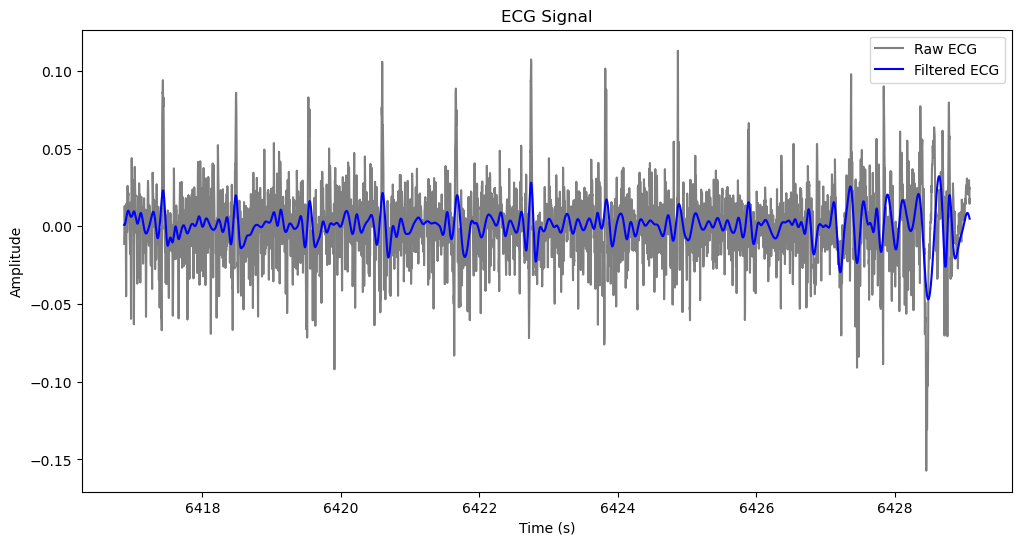

Filtered ECG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_ECG_P2_NoVision_NoMovement_1.csv
Processing LSL file:  T1_experiment_PLUX_P2_NoVision_NoMovement_2_StartParticipantSinging_NoVision_NoMovement_2_EndParticipantSinging.csv
the sample rate of the ECG file is:  1000


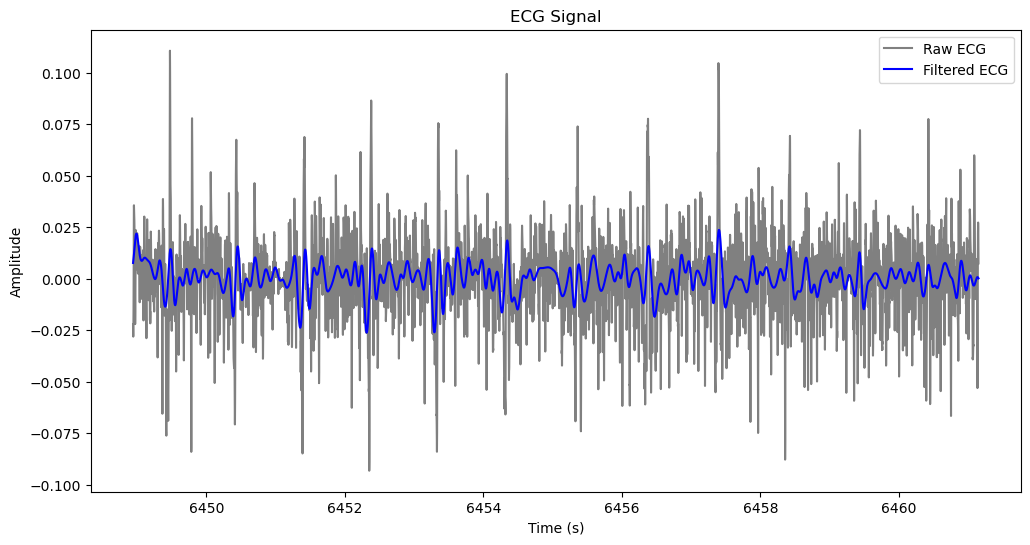

Filtered ECG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_ECG_P2_NoVision_NoMovement_2.csv
Processing LSL file:  T1_experiment_PLUX_P2_NoVision_NoMovement_3_StartParticipantSinging_NoVision_NoMovement_3_EndParticipantSinging.csv
the sample rate of the ECG file is:  1000


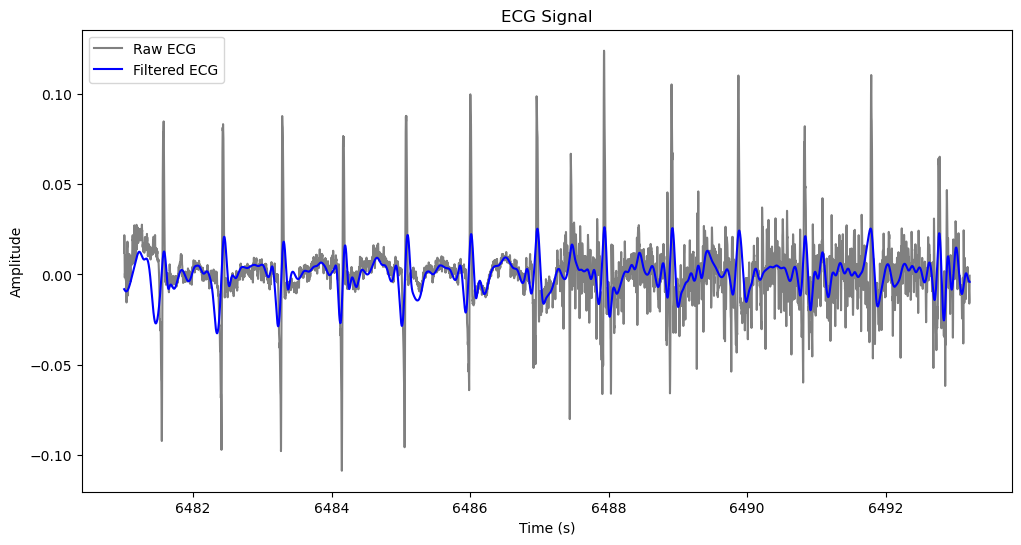

Filtered ECG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_ECG_P2_NoVision_NoMovement_3.csv
Processing LSL file:  T1_experiment_PLUX_P2_NoVision_NoMovement_4_StartParticipantSinging_NoVision_NoMovement_4_EndParticipantSinging.csv
the sample rate of the ECG file is:  1000


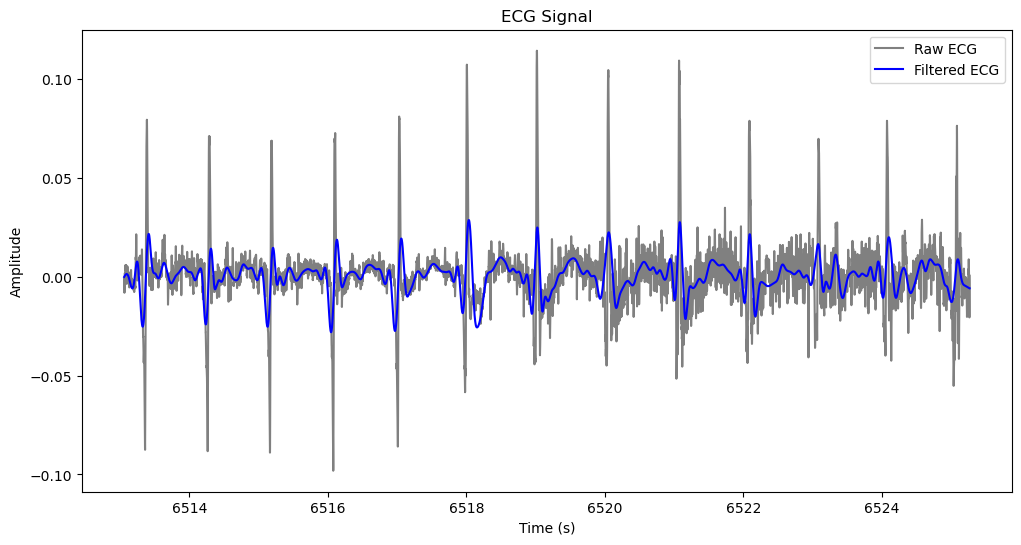

Filtered ECG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_ECG_P2_NoVision_NoMovement_4.csv
Processing LSL file:  T1_experiment_PLUX_P2_Vision_Movement_0_StartParticipantSinging_Vision_Movement_0_EndParticipantSinging.csv
the sample rate of the ECG file is:  1000


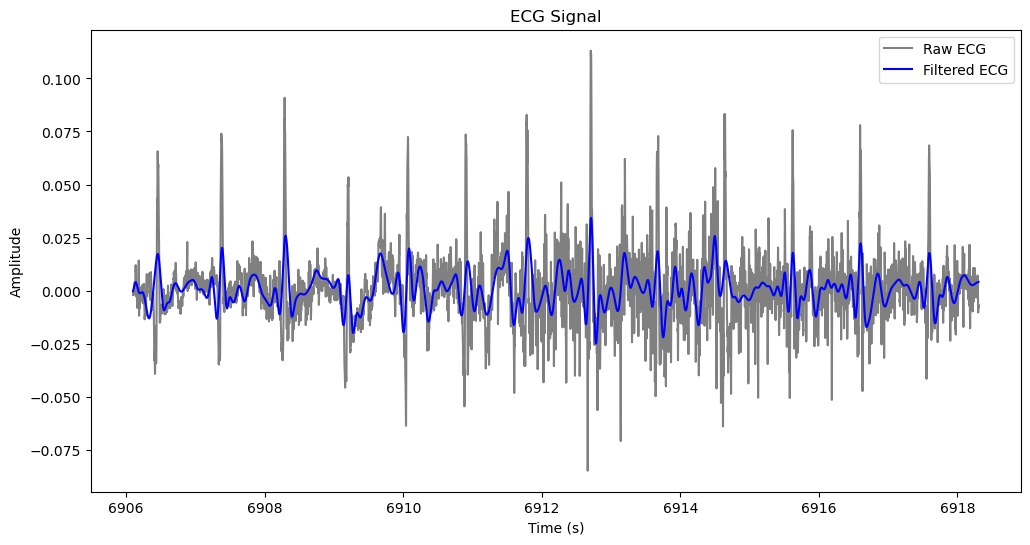

Filtered ECG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_ECG_P2_Vision_Movement_0.csv
Processing LSL file:  T1_experiment_PLUX_P2_Vision_Movement_1_StartParticipantSinging_Vision_Movement_1_EndParticipantSinging.csv
the sample rate of the ECG file is:  1000


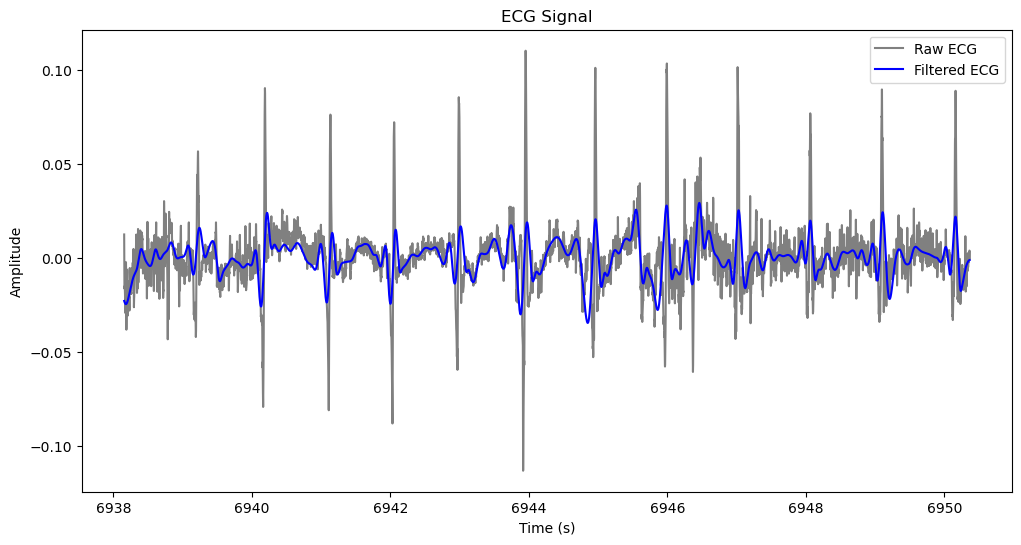

Filtered ECG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_ECG_P2_Vision_Movement_1.csv
Processing LSL file:  T1_experiment_PLUX_P2_Vision_Movement_2_StartParticipantSinging_Vision_Movement_2_EndParticipantSinging.csv
the sample rate of the ECG file is:  1000


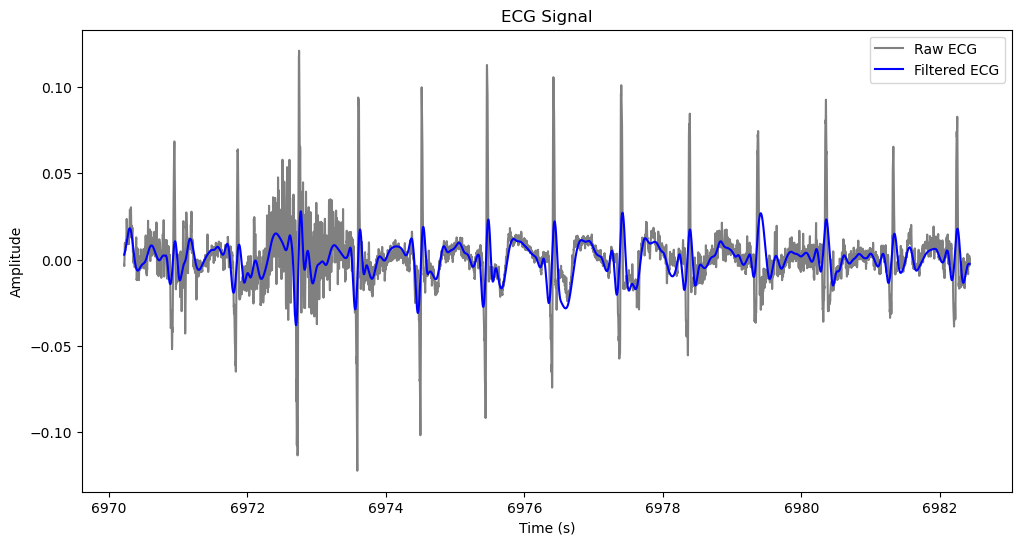

Filtered ECG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_ECG_P2_Vision_Movement_2.csv
Processing LSL file:  T1_experiment_PLUX_P2_Vision_Movement_3_StartParticipantSinging_Vision_Movement_3_EndParticipantSinging.csv
the sample rate of the ECG file is:  1000


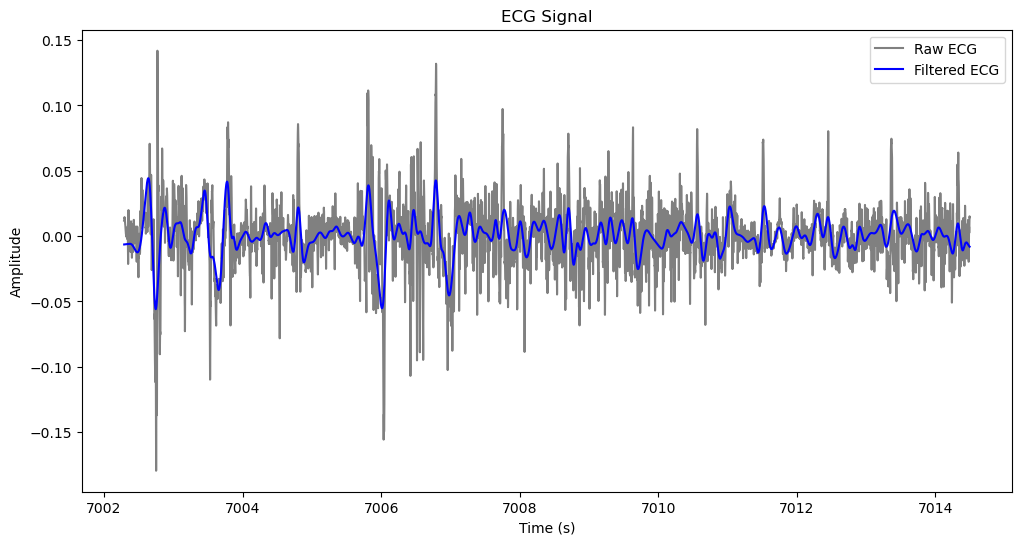

Filtered ECG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_ECG_P2_Vision_Movement_3.csv
Processing LSL file:  T1_experiment_PLUX_P2_Vision_Movement_4_StartParticipantSinging_Vision_Movement_4_EndParticipantSinging.csv
the sample rate of the ECG file is:  1000


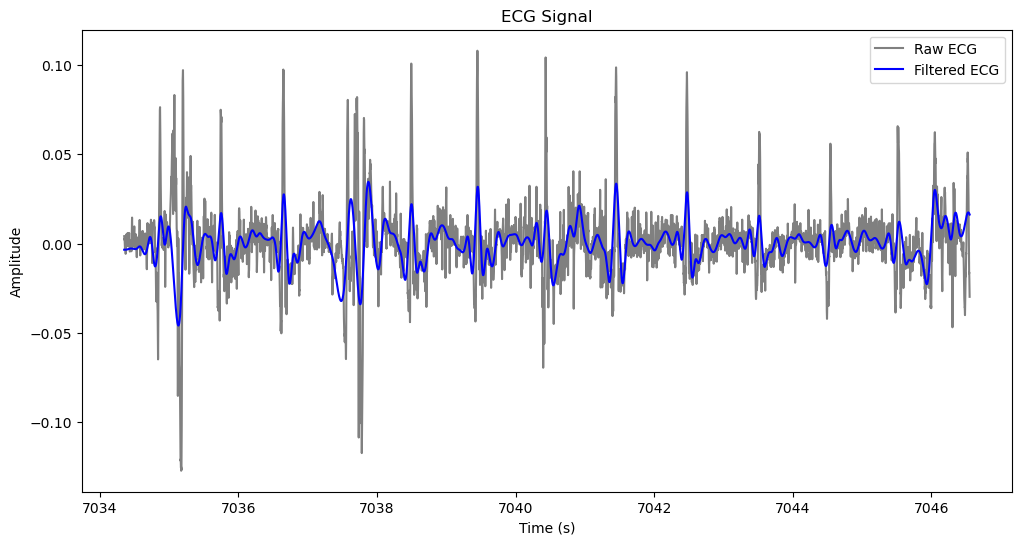

Filtered ECG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_ECG_P2_Vision_Movement_4.csv
Processing LSL file:  T1_experiment_PLUX_P2_Vision_NoMovement_0_StartParticipantSinging_Vision_NoMovement_0_EndParticipantSinging.csv
the sample rate of the ECG file is:  1000


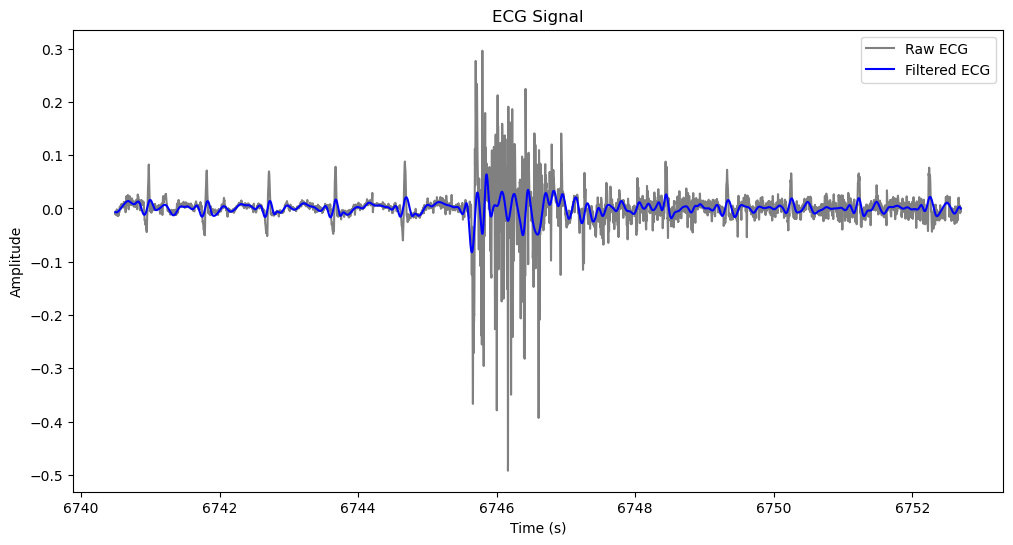

Filtered ECG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_ECG_P2_Vision_NoMovement_0.csv
Processing LSL file:  T1_experiment_PLUX_P2_Vision_NoMovement_1_StartParticipantSinging_Vision_NoMovement_1_EndParticipantSinging.csv
the sample rate of the ECG file is:  1000


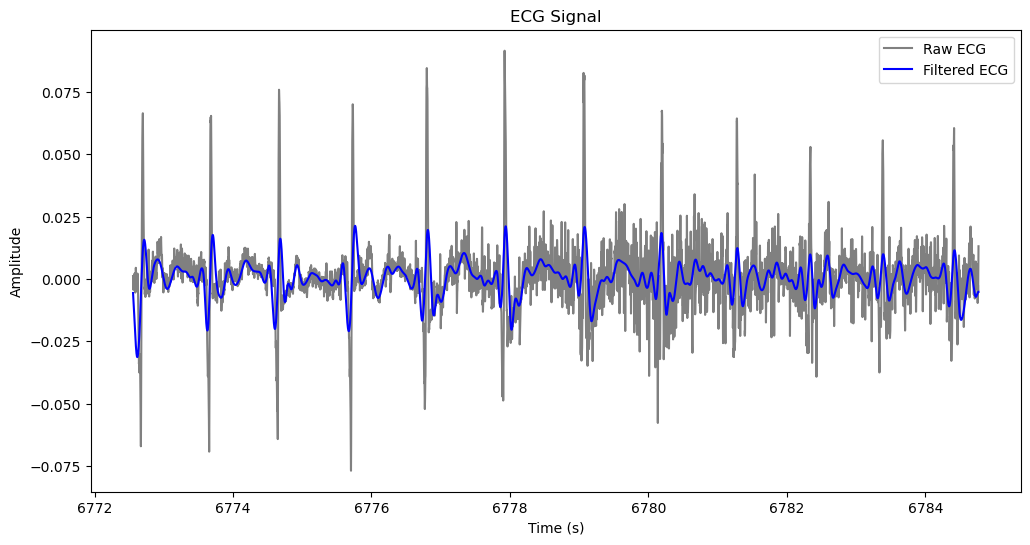

Filtered ECG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_ECG_P2_Vision_NoMovement_1.csv
Processing LSL file:  T1_experiment_PLUX_P2_Vision_NoMovement_2_StartParticipantSinging_Vision_NoMovement_2_EndParticipantSinging.csv
the sample rate of the ECG file is:  1000


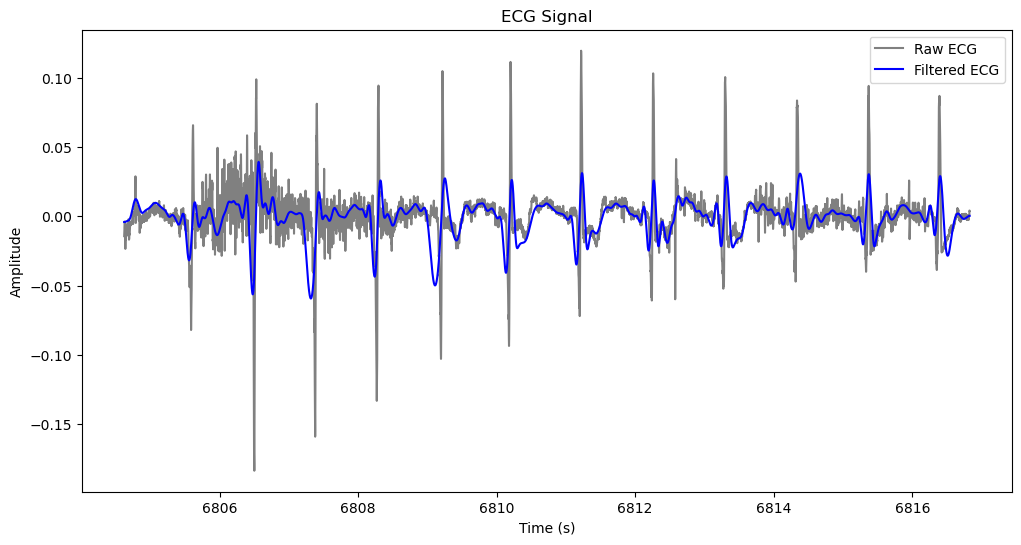

Filtered ECG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_ECG_P2_Vision_NoMovement_2.csv
Processing LSL file:  T1_experiment_PLUX_P2_Vision_NoMovement_3_StartParticipantSinging_Vision_NoMovement_3_EndParticipantSinging.csv
the sample rate of the ECG file is:  1000


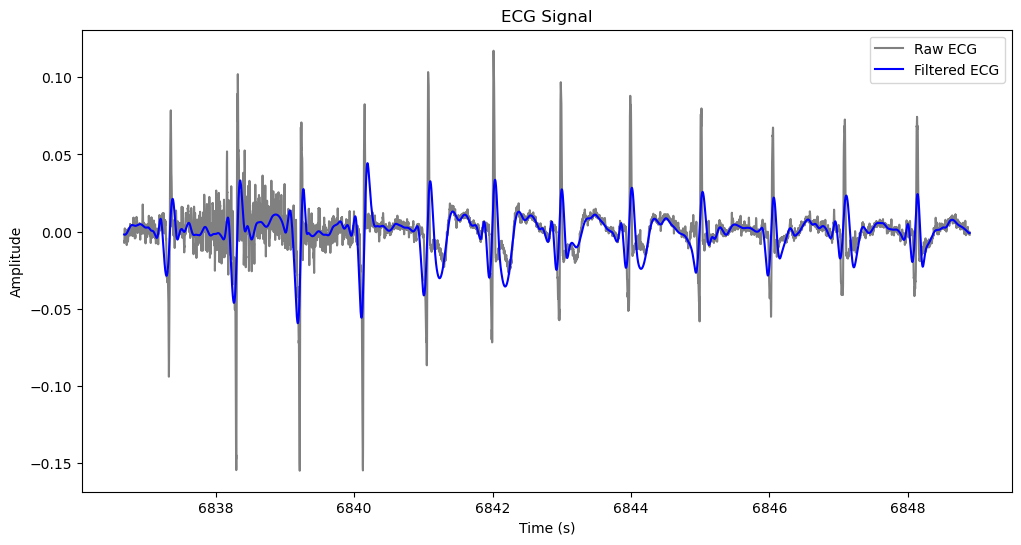

Filtered ECG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_ECG_P2_Vision_NoMovement_3.csv
Processing LSL file:  T1_experiment_PLUX_P2_Vision_NoMovement_4_StartParticipantSinging_Vision_NoMovement_4_EndParticipantSinging.csv
the sample rate of the ECG file is:  1000


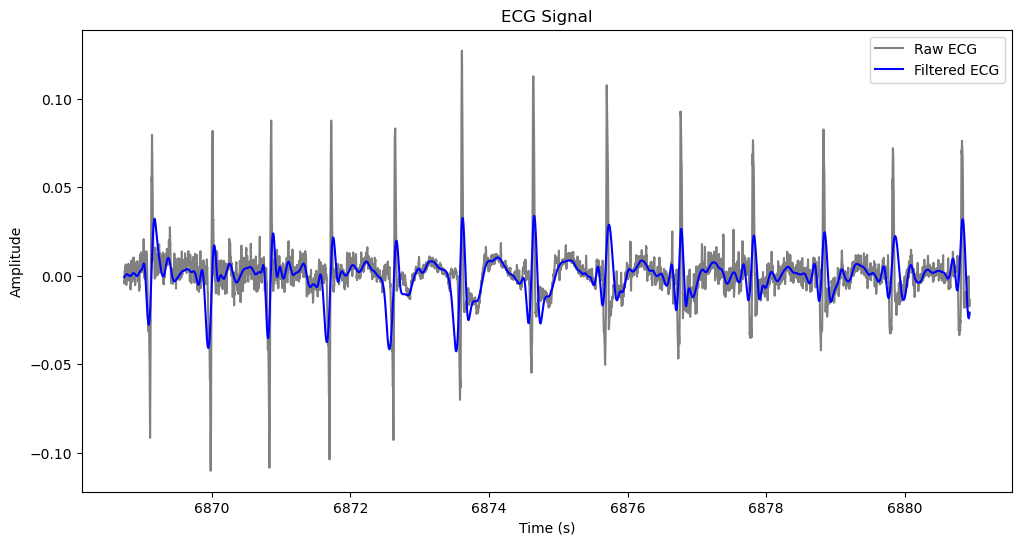

Filtered ECG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_ECG_P2_Vision_NoMovement_4.csv
All files processed successfully. You can look in the directory:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials


In [ ]:
sampling_rate = 1000 

for root, dirs, files in os.walk(input_folder):  # Loop through all files in the input directory
   
    for file in files:                                  # Loop through all files in the input directory
        
        for P in participants:                        # Loop through P1 and P2 
           
            # Find the LSL csv file 
            if P in file and 'PLUX' in file and file.endswith(".csv"):   # Check if the file contains the keyword and is a .wav file
                print("Processing LSL file: ", os.path.basename(file))

                LSL_filename = os.path.join(root, file)
                LSL_data = pd.read_csv(LSL_filename)

                LSL_Time = LSL_data['LSL_Time']

                # ECG is in the third column of the LSL data
                ECG_data = LSL_data.iloc[:, 2].values

                print("the sample rate of the ECG file is: ", sampling_rate)


                # Filter the ECG data with a high pass and low pass filter
                ECG_high_pass = butter_filter(ECG_data, 0.75, sampling_rate, order=4, filter_type='high')
                ECG_low_pass = butter_filter(ECG_high_pass, 3, sampling_rate, order=4, filter_type='low')


    #           # ALTERNATIVE WAY TO FILTER THE ECG DATA
                # Preprocess the ECG data using bandpas and notch filters
                ECG_filtered = process_ecg(ECG_data, sampling_rate, 0.5, 20, 50, 30)  # 0.5 Hz high-pass, 40 Hz low-pass, 50 Hz notch, 30 Q-factor


                # Apply EMD: extract and remove first IMF (high-freq noise)
                ECG_imf1 = my_get_next_imf(ECG_filtered, sd_thresh=0.1)

                ECG_cleaned = my_get_next_imf(ECG_filtered - ECG_imf1)

                # from scipy.signal import savgol_filter
                # window_length must be odd and > polyorder
                # ecg_smooth = savgol_filter(ECG_processed, window_length=251, polyorder=3)


                # Plot both Raw and Filtered ECG signals in the same figure
                plt.figure(figsize=(12, 6))
                plt.plot(LSL_Time, ECG_data, label='Raw ECG', color='gray')
                plt.plot(LSL_Time, ECG_cleaned, label='Filtered ECG', color='blue')
                plt.title('ECG Signal')
                plt.xlabel('Time (s)')
                plt.ylabel('Amplitude')
                plt.legend()
                plt.show()



                # # Plot the Raw and Filtered ECG signals in two subplots 
                # plt.figure(figsize=(12, 8))
                # plt.subplot(2, 1, 1)
                # plt.plot(LSL_Time, ECG_data, label='Raw ECG', color='gray')
                # plt.title('Raw ECG Signal')
                # plt.subplot(2, 1, 2)
                # plt.plot(LSL_Time, ECG_low_pass, label='Filtered ECG', color='blue')
                # plt.title('Filtered ECG Signal')
                # plt.xlabel('Time (s)')
                # plt.tight_layout()
                # plt.show()

                # Save the filtered ECG data to a CSV file 
                filename_base = os.path.basename(file)
                parts = filename_base.split('_')
                # Get the first 7 parts and join them back with underscores (i.e., until the trial number)
                new_name = '_'.join(parts[:7])
                # Replace "PLUX" with "ECG" in the base name
                new_name = new_name.replace('PLUX', 'ECG')
                # Save the filtered ECG data to a CSV file in the output folder
                output_filename = os.path.join(output_folder, new_name + '.csv')
                # Create a DataFrame with the filtered ECG data
                ECG_df = pd.DataFrame({
                    'Time': LSL_Time,
                    'Filtered_ECG': ECG_low_pass
                })
                # Save the DataFrame to a CSV file
                ECG_df.to_csv(output_filename, index=False)
                print("Filtered ECG data saved to: ", output_filename)
                

print("All files processed successfully. You can look in the directory: ", output_folder)
# Close all plots
plt.close('all')


### Respiration Cleaning

In [ ]:
sampling_rate = 1000 

for root, dirs, files in os.walk(input_folder):  # Loop through all files in the input directory
   
    for file in files:                                  # Loop through all files in the input directory
        
        for P in participants:                        # Loop through P1 and P2 
           
            # Find the LSL csv file 
            if P in file and 'PLUX' in file and file.endswith(".csv"):   # Check if the file contains the keyword and is a .wav file
                print("Processing LSL file: ", os.path.basename(file))

                LSL_filename = os.path.join(root, file)
                LSL_data = pd.read_csv(LSL_filename)

                LSL_Time = LSL_data['LSL_Time']

                # Respiration is in the 6th column of the LSL data
                Respiration_data = LSL_data.iloc[:, 5].values

                # cleanign the respiration data with a low pass filter
                Respiration_low_pass = butter_lowpass_filtfilt(Respiration_data, 1.0, 1000, order=4)

                # Plot the Raw and Filtered Respiration signals the same plot 
                plt.figure(figsize=(12, 6))
                plt.plot(LSL_Time, Respiration_data, label='Raw Respiration', color='gray')
                plt.plot(LSL_Time, Respiration_low_pass, label='Filtered Respiration', color='blue')
                plt.title('Respiration Signal')
                plt.xlabel('Time (s)')
                plt.ylabel('Amplitude')
                plt.legend()
                #plt.show()

                

                # Save the filtered Respiration data to a CSV file
                filename_base = os.path.basename(file)
                parts = filename_base.split('_')
                # Get the first 7 parts and join them back with underscores (i.e., until the trial number)
                new_name = '_'.join(parts[:7])
                # Replace "PLUX" with "Respiration" in the base name
                new_name = new_name.replace('PLUX', 'Respiration')
                # Save the filtered Respiration data to a CSV file in the output folder
                output_filename = os.path.join(output_folder, new_name + '.csv')
                # Create a DataFrame with the filtered Respiration data
                Respiration_df = pd.DataFrame({
                    'Time': LSL_Time,
                    'Filtered_Respiration': Respiration_low_pass
                })
                # Save the DataFrame to a CSV file
                Respiration_df.to_csv(output_filename, index=False)
                print("Filtered Respiration data saved to: ", output_filename)
print("All files processed successfully. You can look in the directory: ", output_folder)
                

### EMG Filtering with High Pass, Rectifier and Low Pass

Processing LSL file:  T1_experiment_PLUX_P1_NoVision_Movement_0_StartParticipantSinging_NoVision_Movement_0_EndParticipantSinging.csv


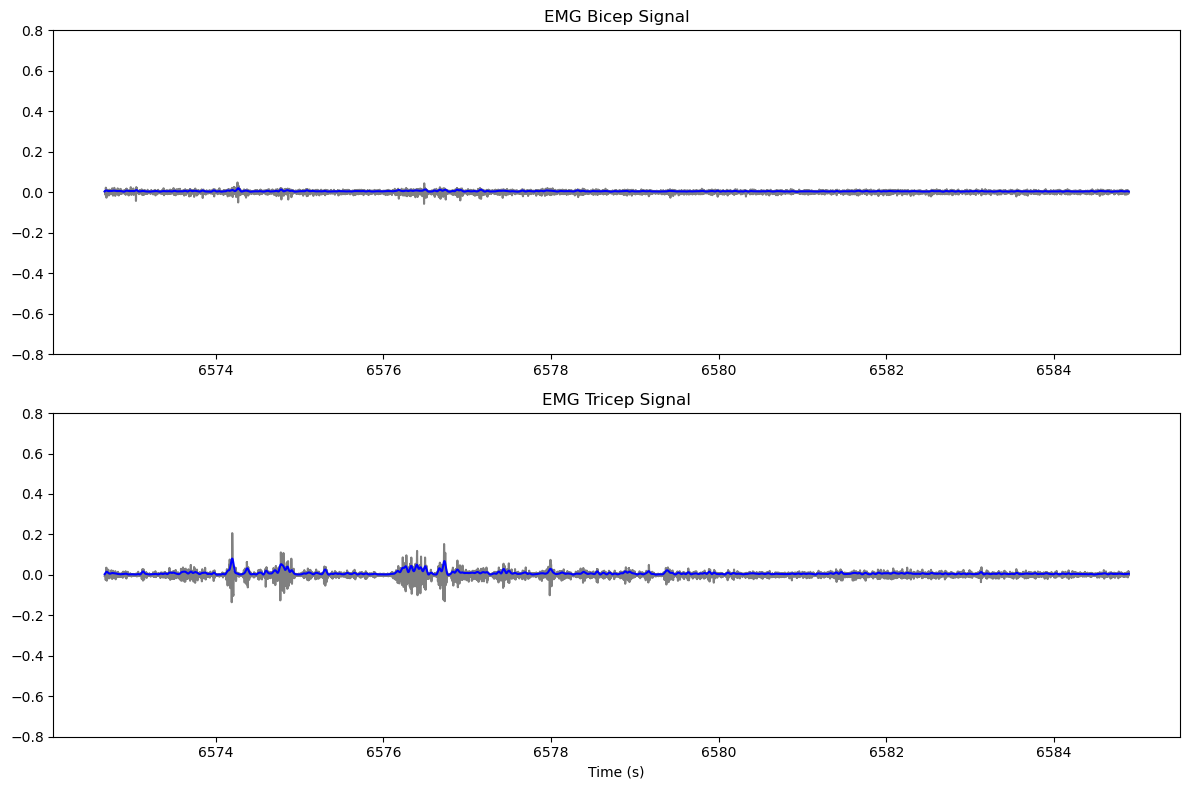

Filtered EMG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_EMG_P1_NoVision_Movement_0.csv
Processing LSL file:  T1_experiment_PLUX_P1_NoVision_Movement_1_StartParticipantSinging_NoVision_Movement_1_EndParticipantSinging.csv


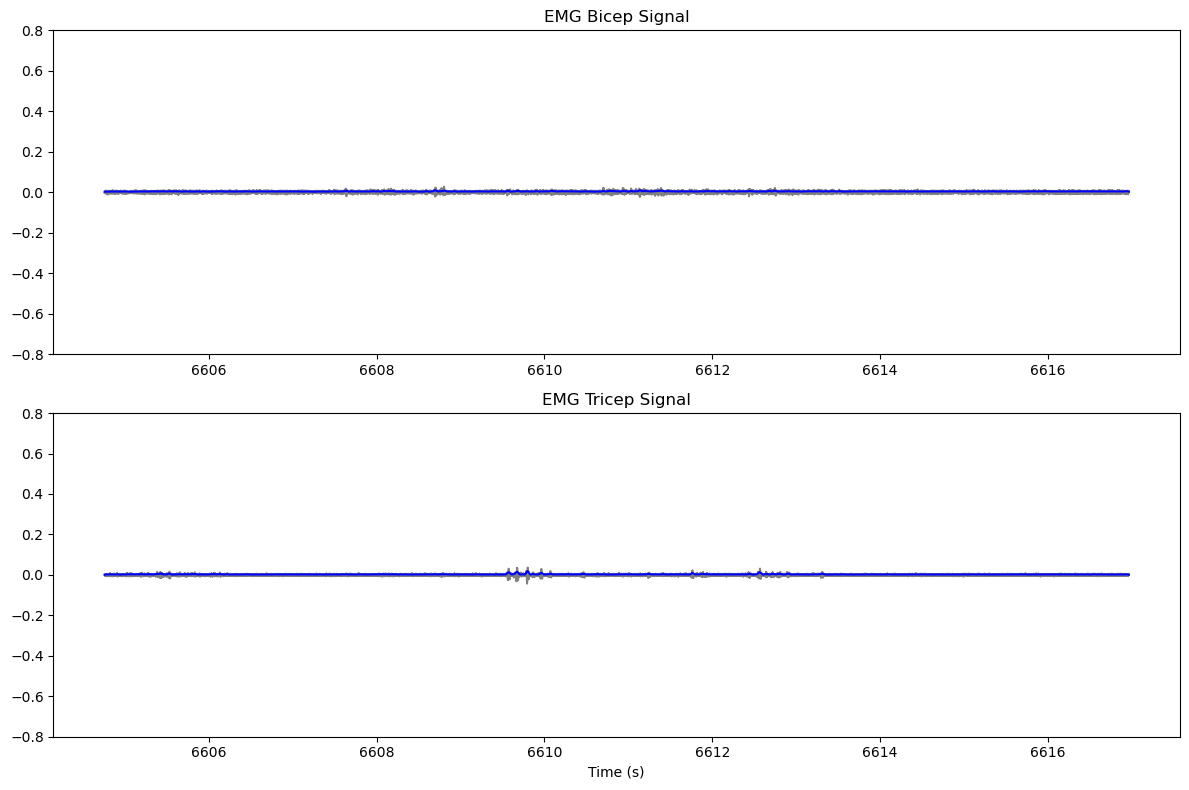

Filtered EMG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_EMG_P1_NoVision_Movement_1.csv
Processing LSL file:  T1_experiment_PLUX_P1_NoVision_Movement_2_StartParticipantSinging_NoVision_Movement_2_EndParticipantSinging.csv


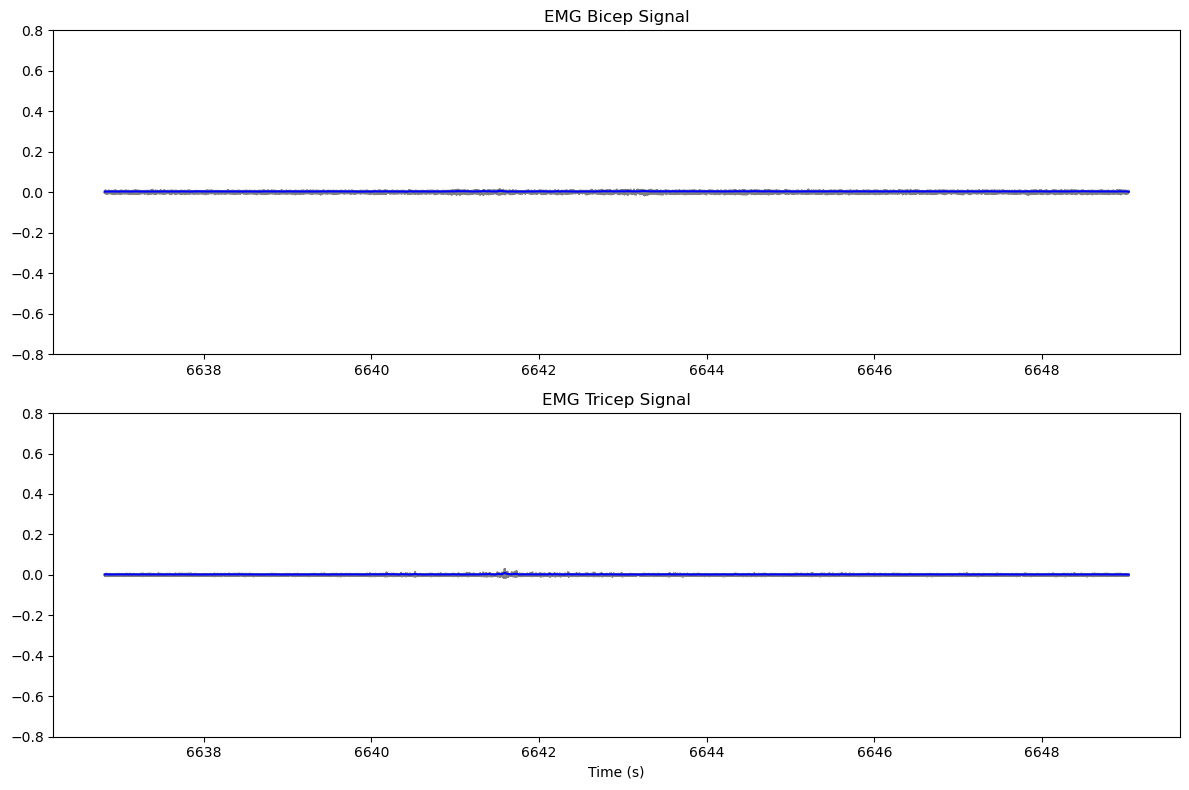

Filtered EMG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_EMG_P1_NoVision_Movement_2.csv
Processing LSL file:  T1_experiment_PLUX_P1_NoVision_Movement_3_StartParticipantSinging_NoVision_Movement_3_EndParticipantSinging.csv


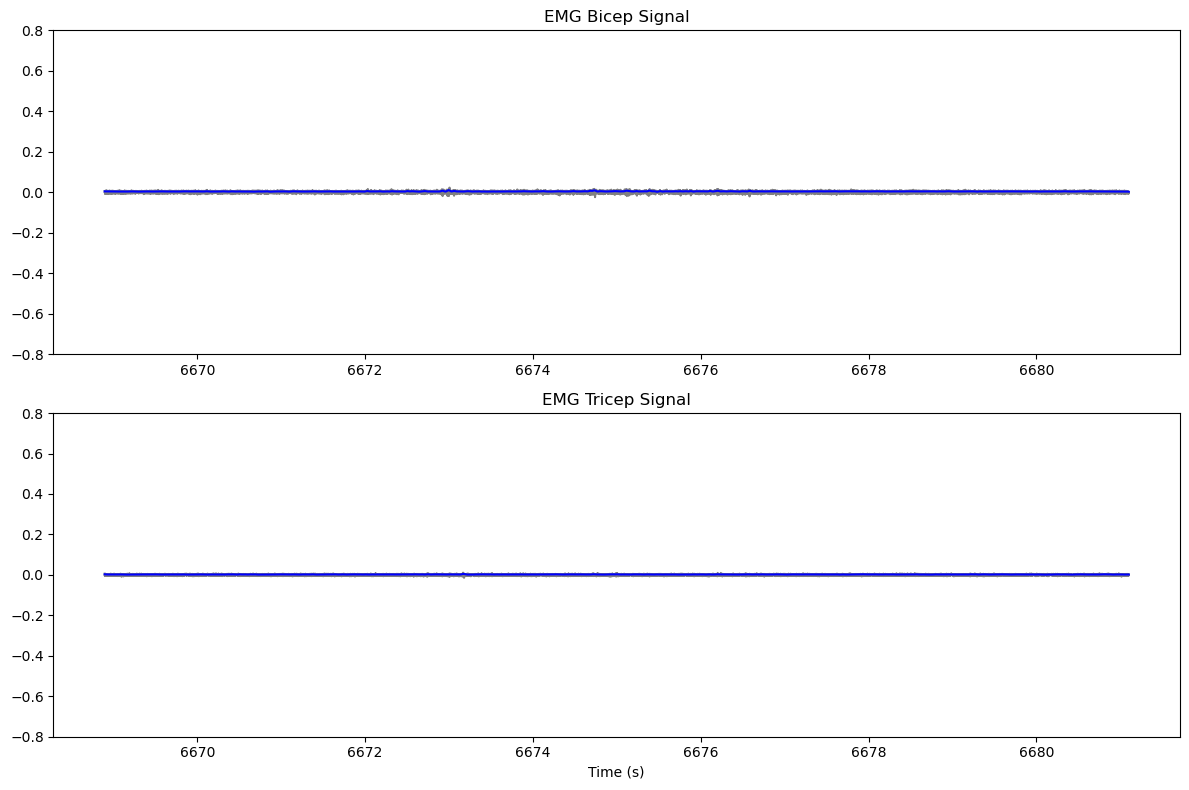

Filtered EMG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_EMG_P1_NoVision_Movement_3.csv
Processing LSL file:  T1_experiment_PLUX_P1_NoVision_Movement_4_StartParticipantSinging_NoVision_Movement_4_EndParticipantSinging.csv


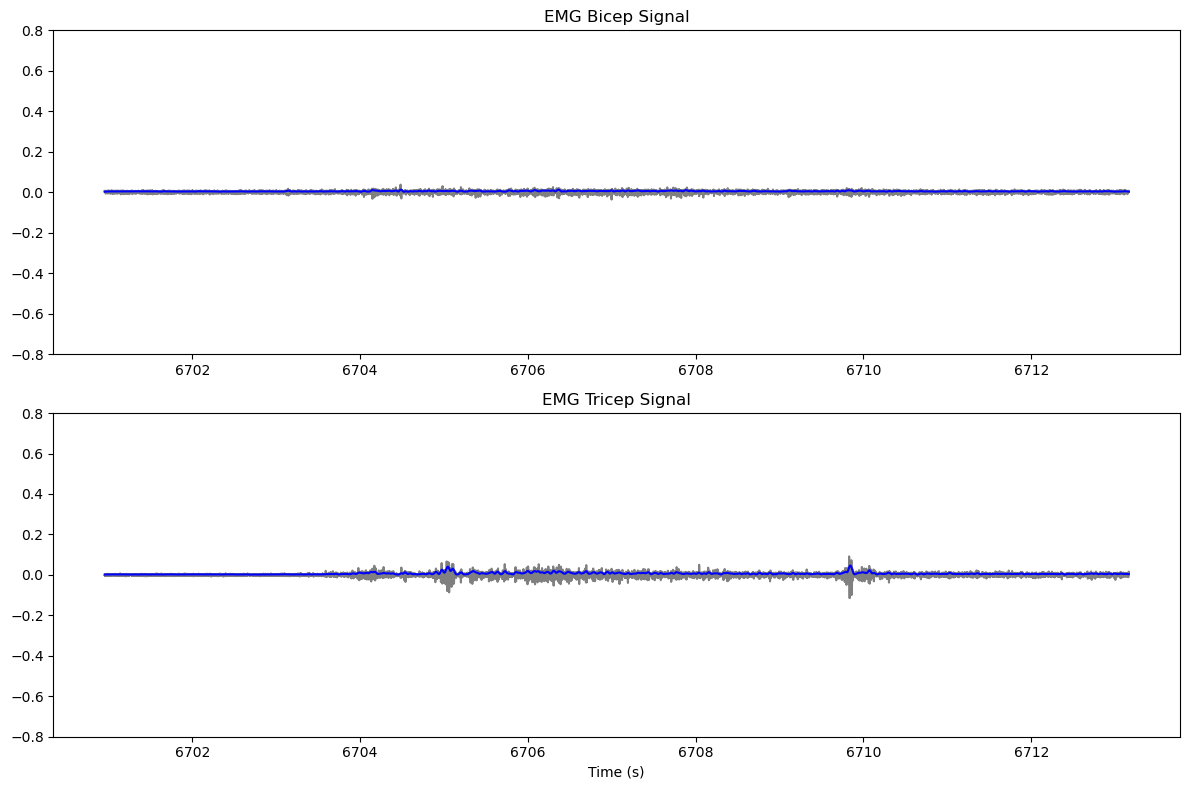

Filtered EMG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_EMG_P1_NoVision_Movement_4.csv
Processing LSL file:  T1_experiment_PLUX_P1_NoVision_NoMovement_0_StartParticipantSinging_NoVision_NoMovement_0_EndParticipantSinging.csv


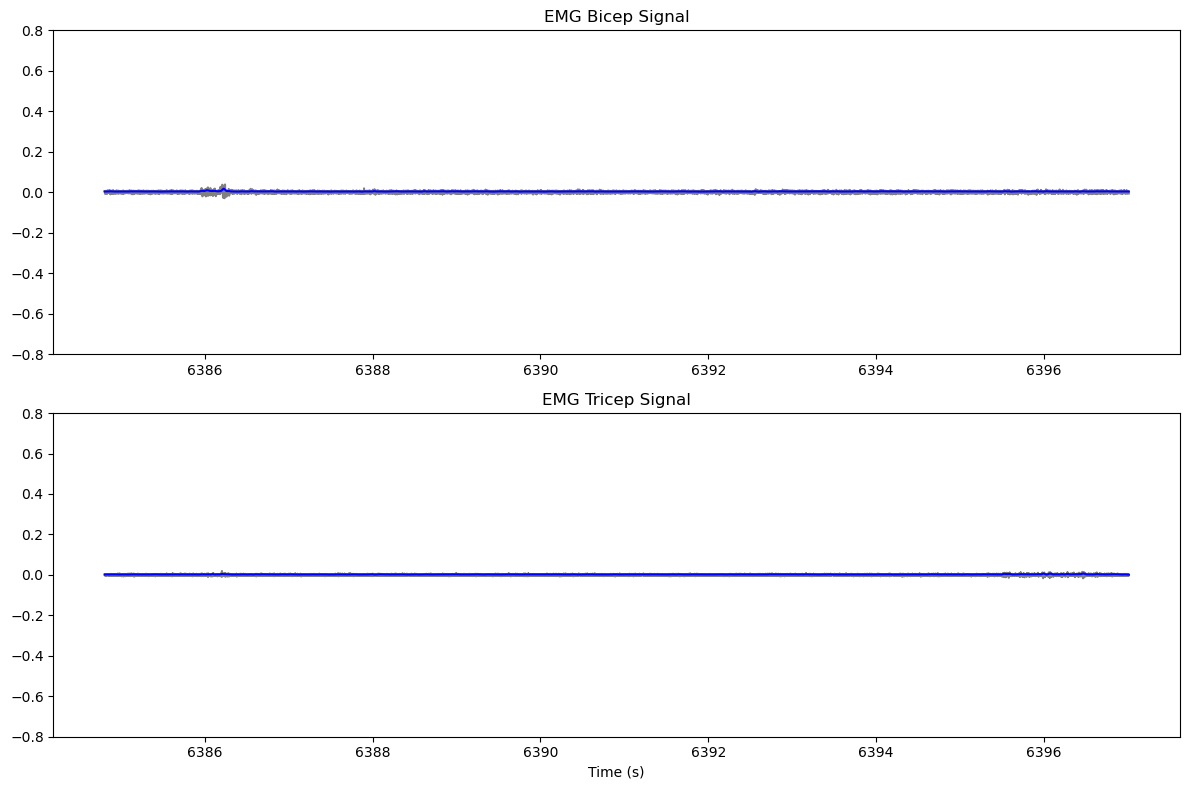

Filtered EMG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_EMG_P1_NoVision_NoMovement_0.csv
Processing LSL file:  T1_experiment_PLUX_P1_NoVision_NoMovement_1_StartParticipantSinging_NoVision_NoMovement_1_EndParticipantSinging.csv


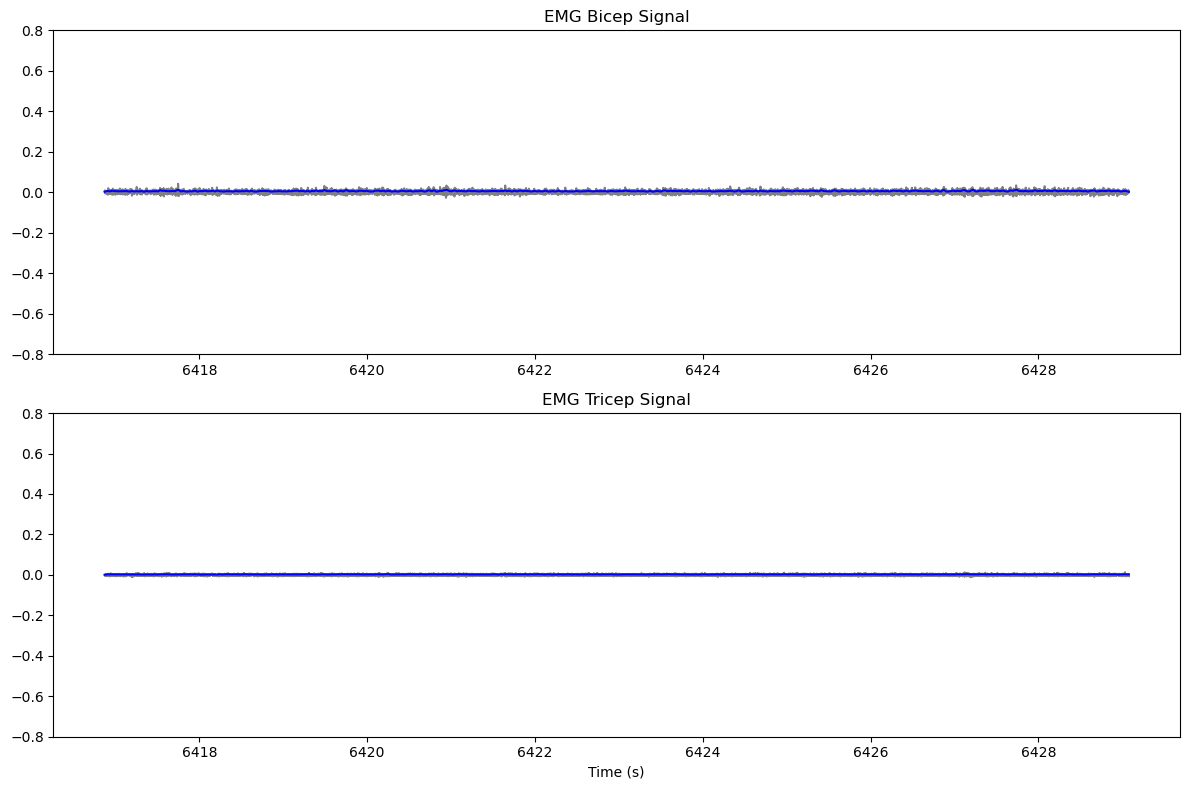

Filtered EMG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_EMG_P1_NoVision_NoMovement_1.csv
Processing LSL file:  T1_experiment_PLUX_P1_NoVision_NoMovement_2_StartParticipantSinging_NoVision_NoMovement_2_EndParticipantSinging.csv


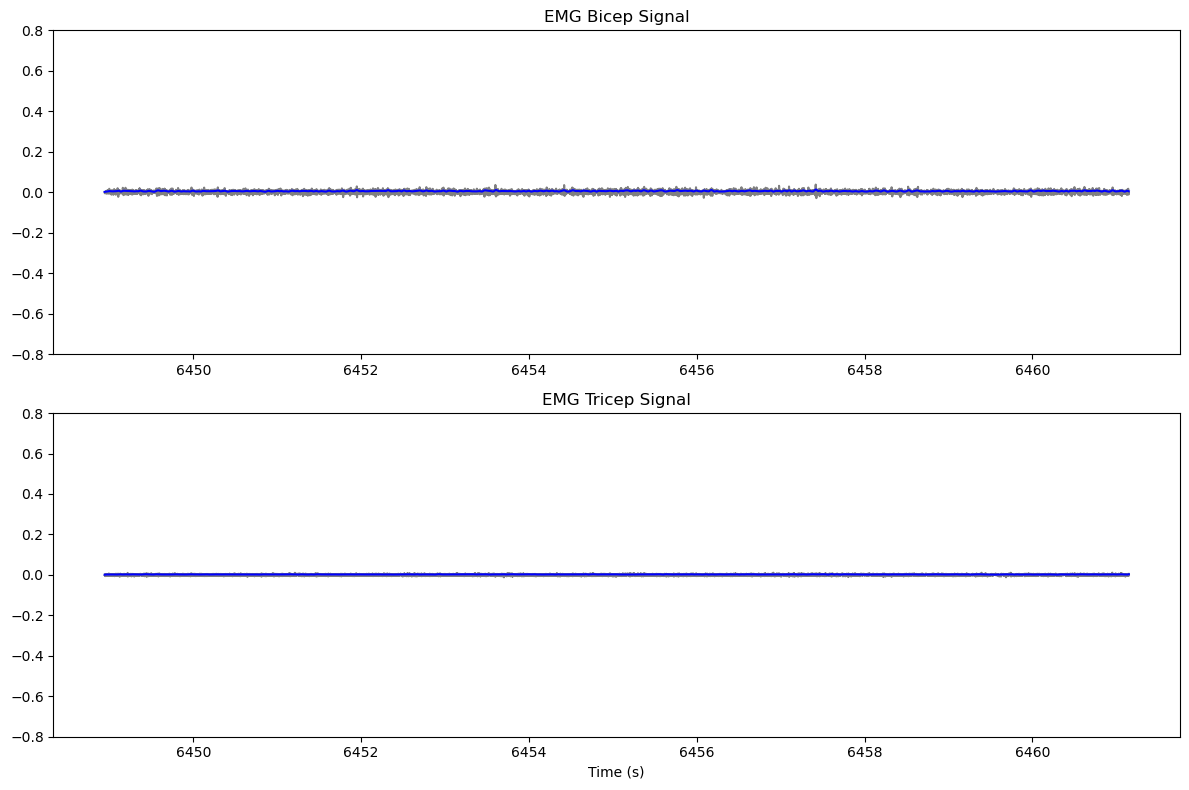

Filtered EMG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_EMG_P1_NoVision_NoMovement_2.csv
Processing LSL file:  T1_experiment_PLUX_P1_NoVision_NoMovement_3_StartParticipantSinging_NoVision_NoMovement_3_EndParticipantSinging.csv


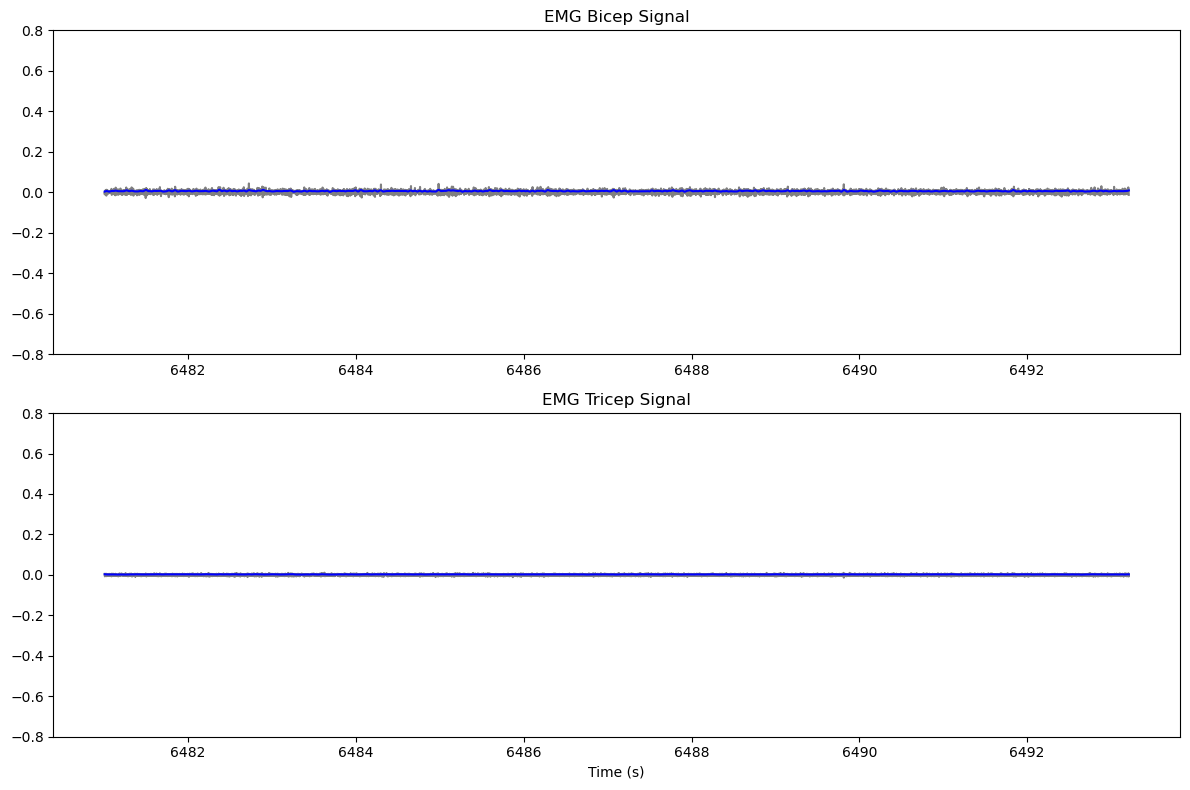

Filtered EMG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_EMG_P1_NoVision_NoMovement_3.csv
Processing LSL file:  T1_experiment_PLUX_P1_NoVision_NoMovement_4_StartParticipantSinging_NoVision_NoMovement_4_EndParticipantSinging.csv


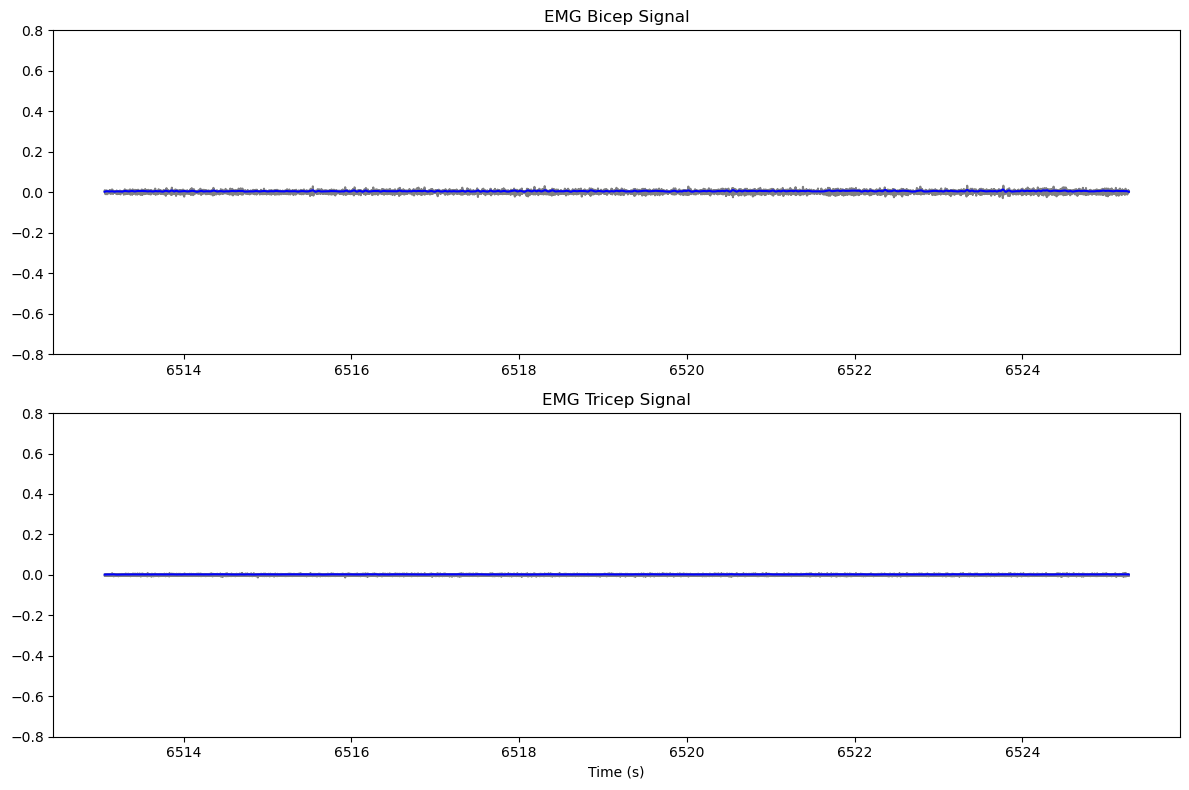

Filtered EMG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_EMG_P1_NoVision_NoMovement_4.csv
Processing LSL file:  T1_experiment_PLUX_P1_Vision_Movement_0_StartParticipantSinging_Vision_Movement_0_EndParticipantSinging.csv


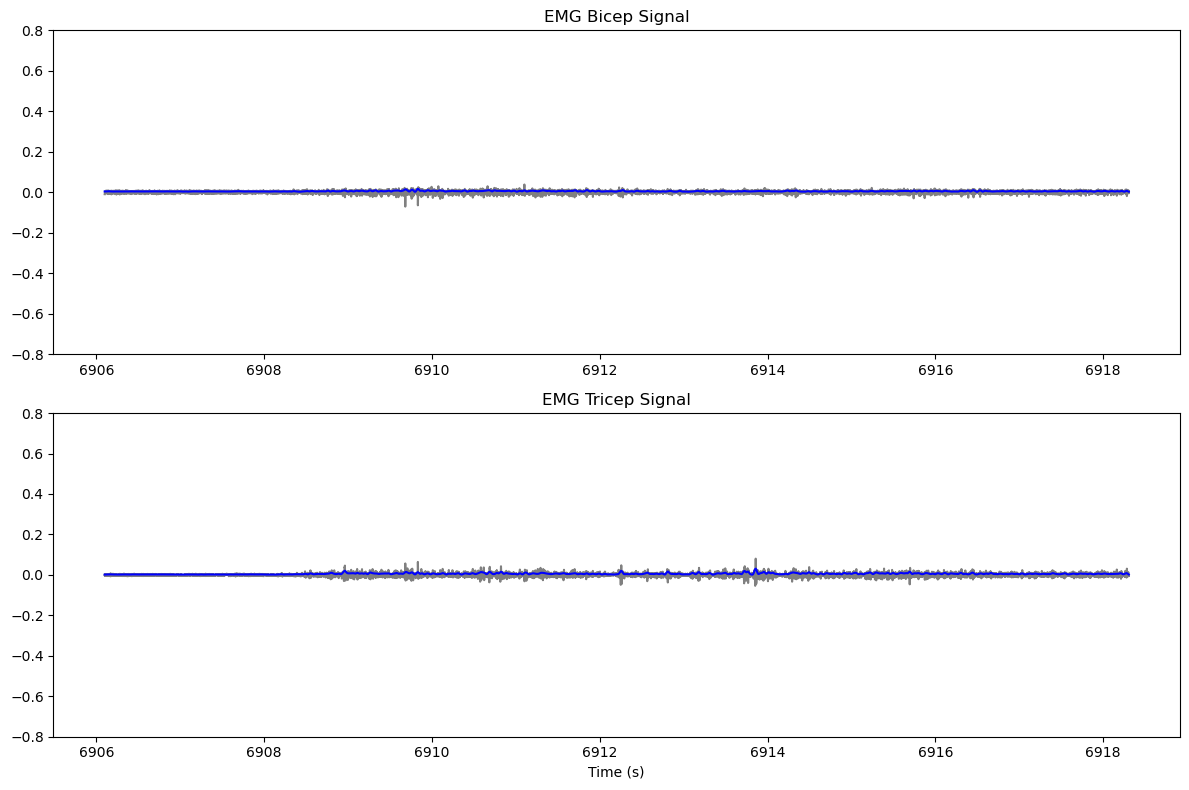

Filtered EMG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_EMG_P1_Vision_Movement_0.csv
Processing LSL file:  T1_experiment_PLUX_P1_Vision_Movement_1_StartParticipantSinging_Vision_Movement_1_EndParticipantSinging.csv


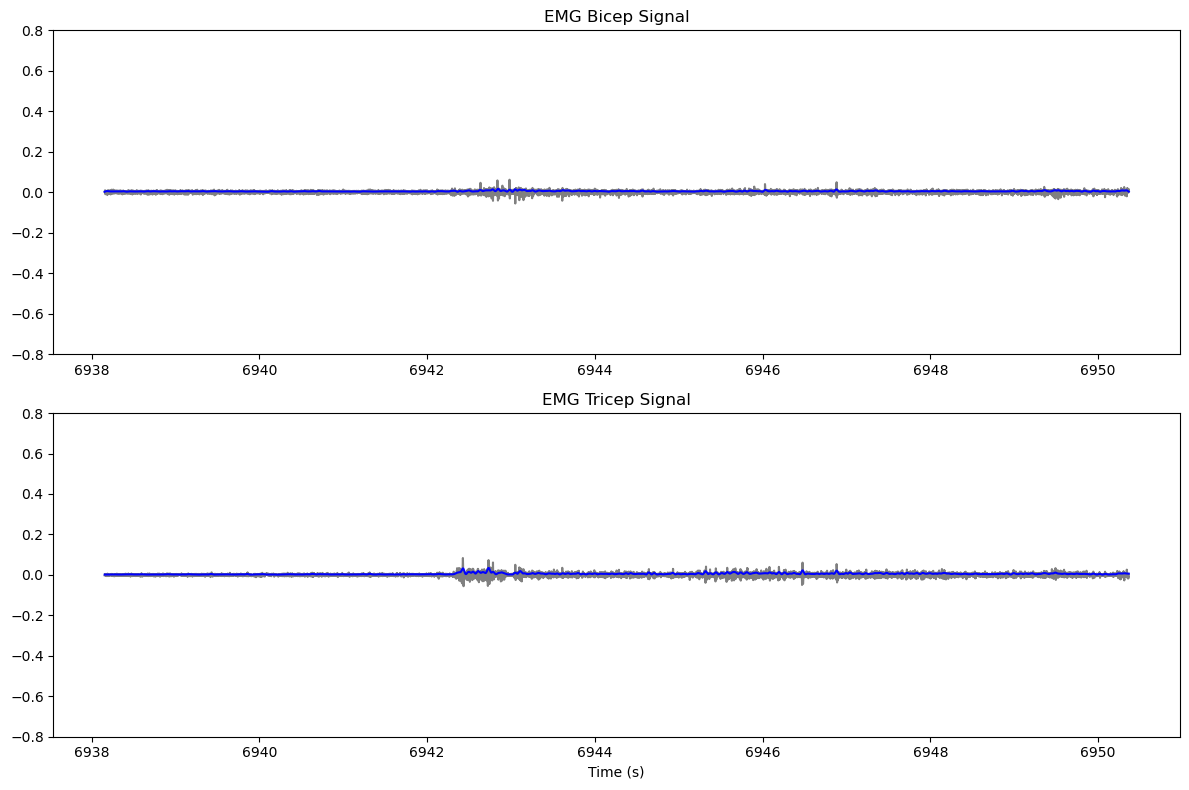

Filtered EMG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_EMG_P1_Vision_Movement_1.csv
Processing LSL file:  T1_experiment_PLUX_P1_Vision_Movement_2_StartParticipantSinging_Vision_Movement_2_EndParticipantSinging.csv


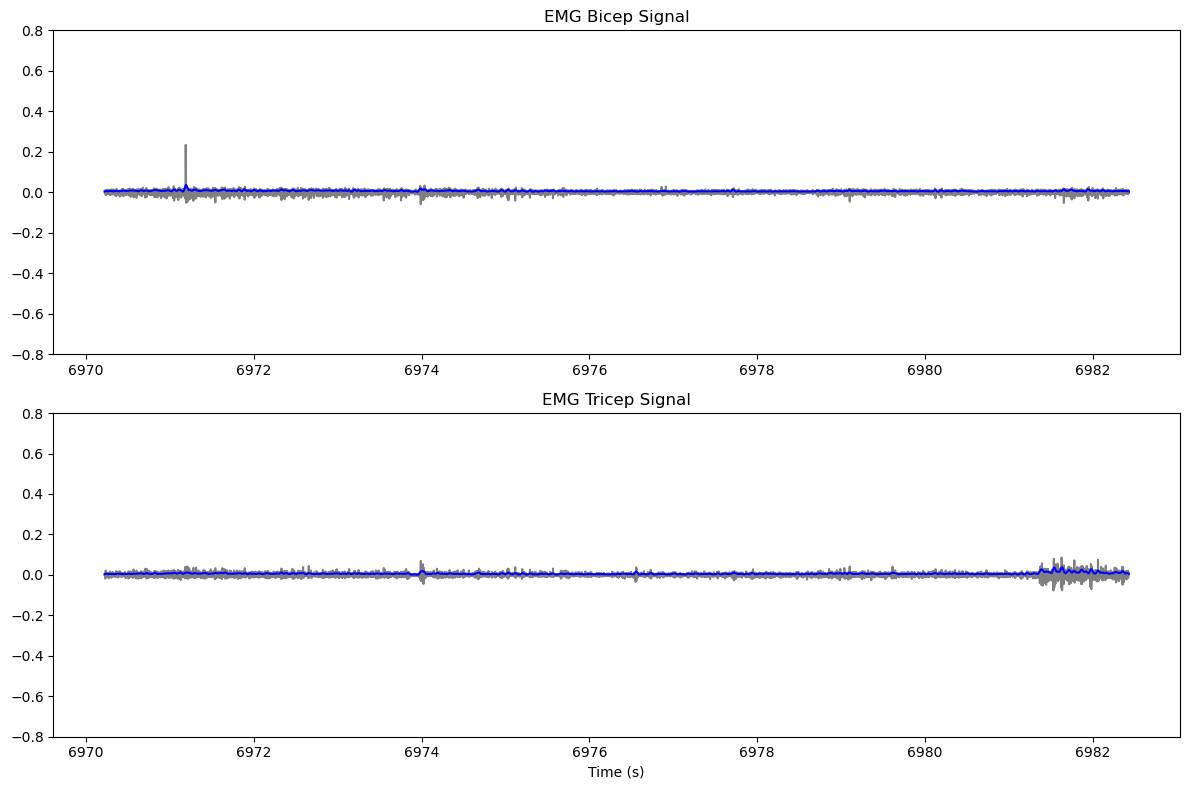

Filtered EMG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_EMG_P1_Vision_Movement_2.csv
Processing LSL file:  T1_experiment_PLUX_P1_Vision_Movement_3_StartParticipantSinging_Vision_Movement_3_EndParticipantSinging.csv


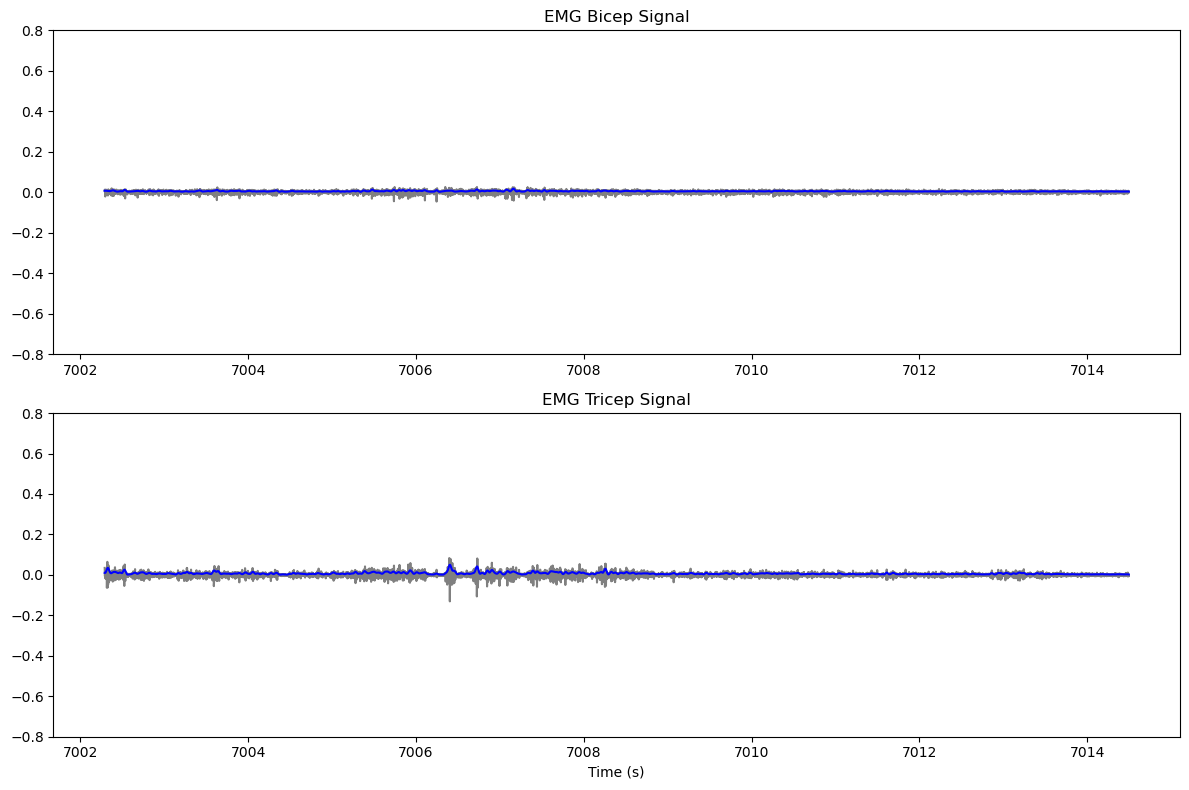

Filtered EMG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_EMG_P1_Vision_Movement_3.csv
Processing LSL file:  T1_experiment_PLUX_P1_Vision_Movement_4_StartParticipantSinging_Vision_Movement_4_EndParticipantSinging.csv


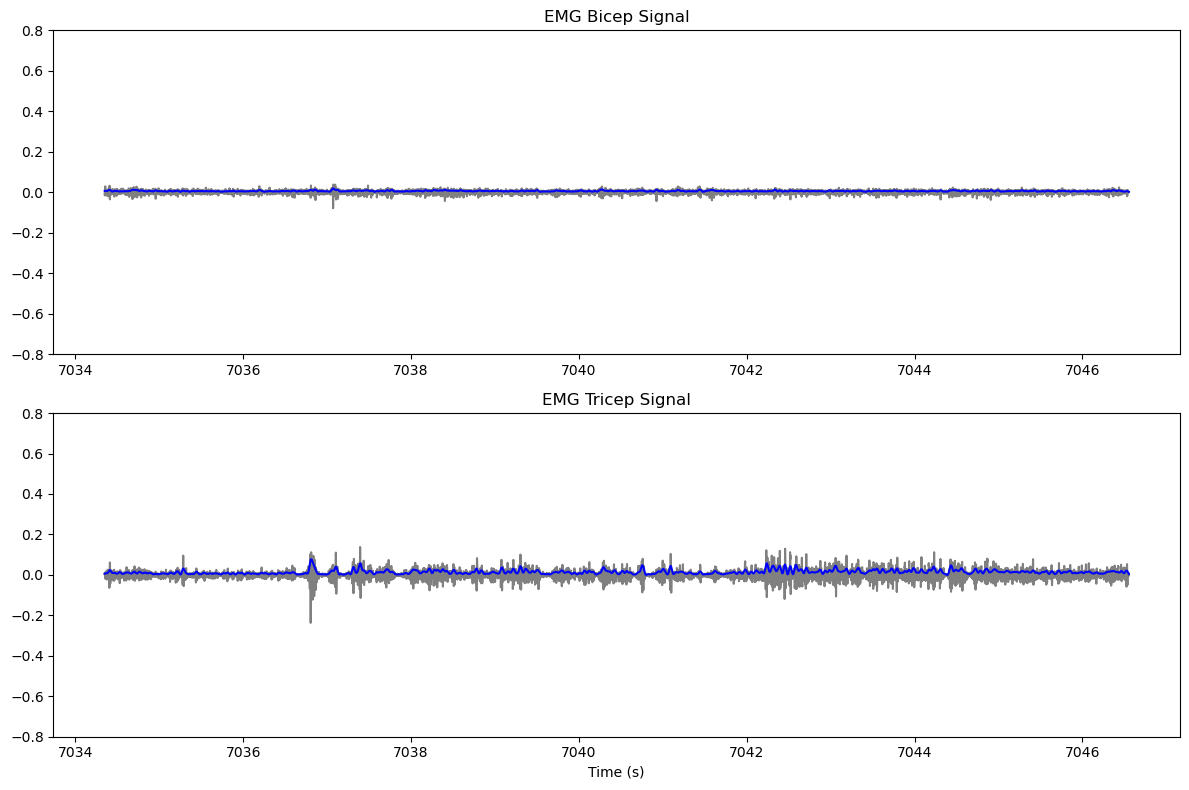

Filtered EMG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_EMG_P1_Vision_Movement_4.csv
Processing LSL file:  T1_experiment_PLUX_P1_Vision_NoMovement_0_StartParticipantSinging_Vision_NoMovement_0_EndParticipantSinging.csv


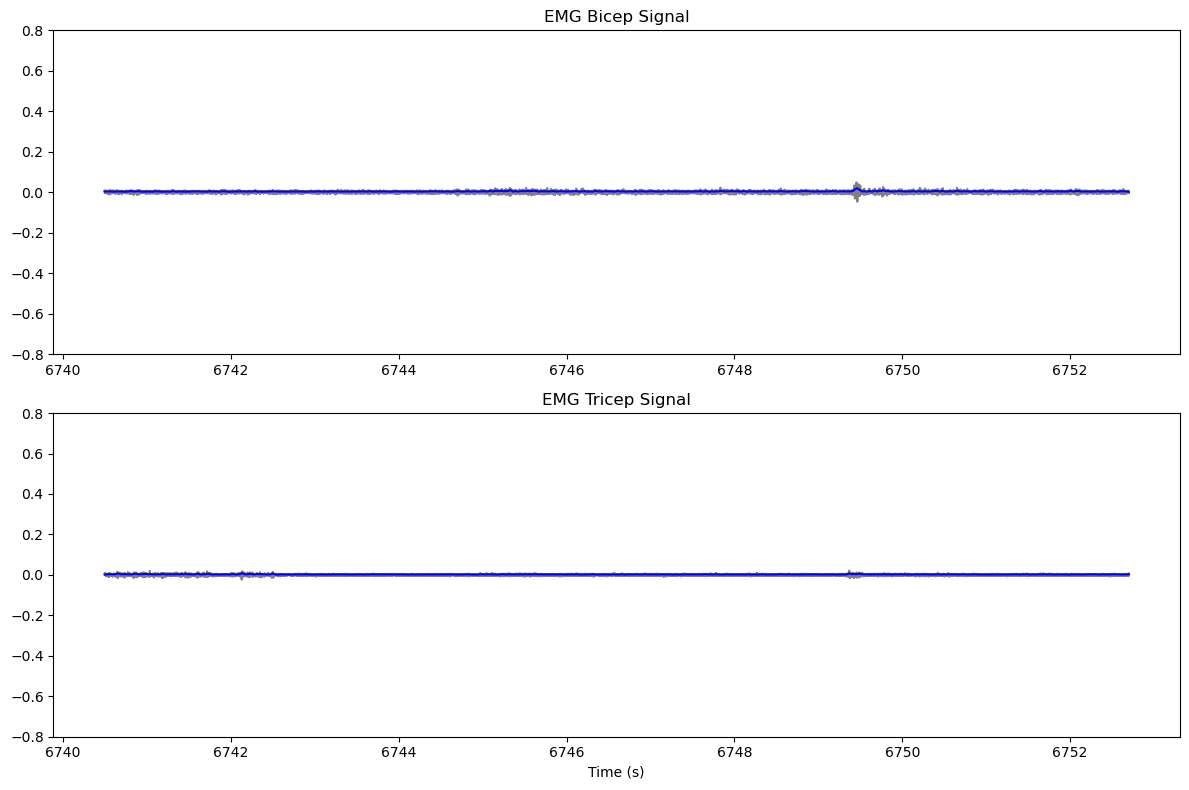

Filtered EMG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_EMG_P1_Vision_NoMovement_0.csv
Processing LSL file:  T1_experiment_PLUX_P1_Vision_NoMovement_1_StartParticipantSinging_Vision_NoMovement_1_EndParticipantSinging.csv


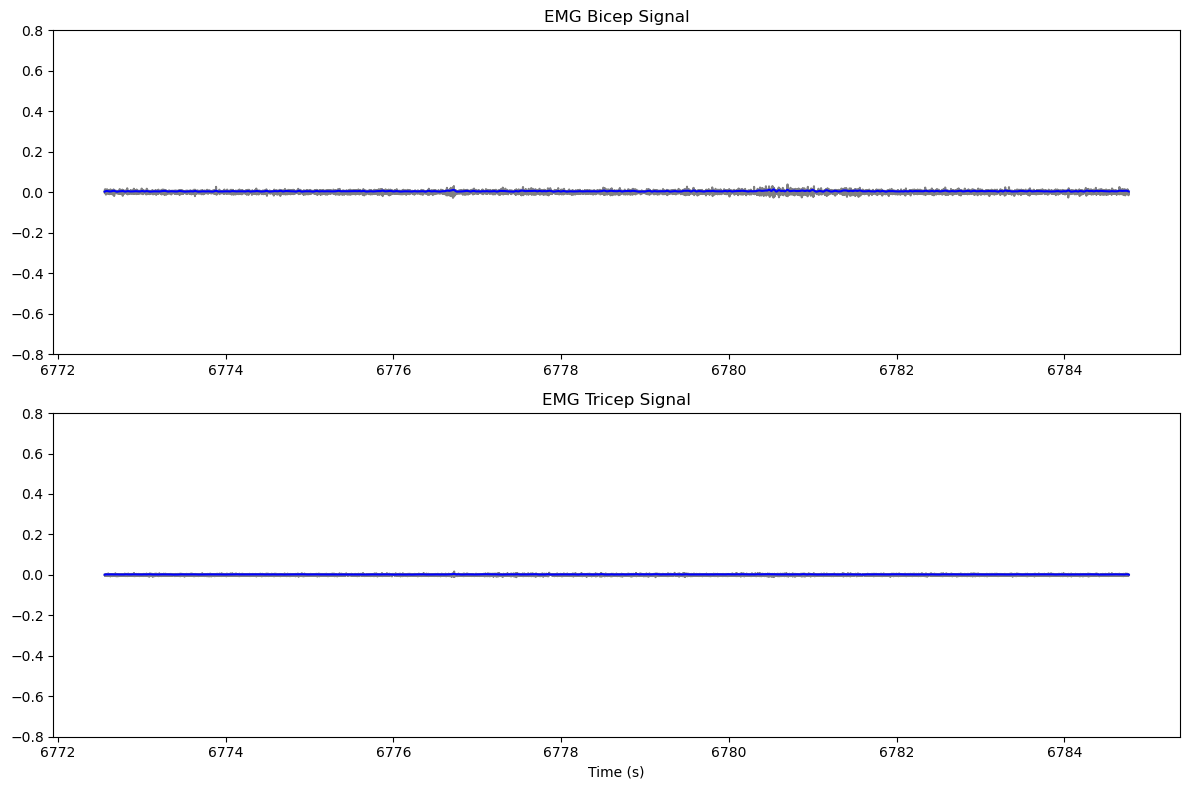

Filtered EMG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_EMG_P1_Vision_NoMovement_1.csv
Processing LSL file:  T1_experiment_PLUX_P1_Vision_NoMovement_2_StartParticipantSinging_Vision_NoMovement_2_EndParticipantSinging.csv


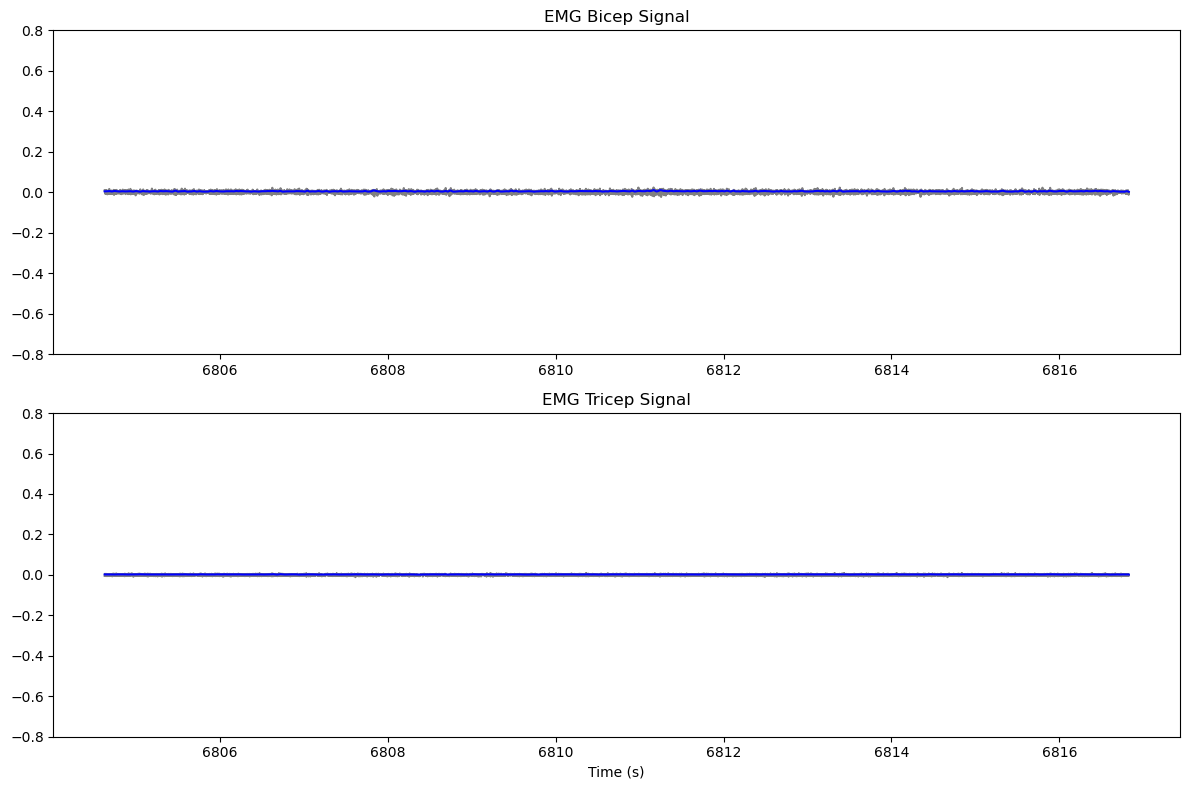

Filtered EMG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_EMG_P1_Vision_NoMovement_2.csv
Processing LSL file:  T1_experiment_PLUX_P1_Vision_NoMovement_3_StartParticipantSinging_Vision_NoMovement_3_EndParticipantSinging.csv


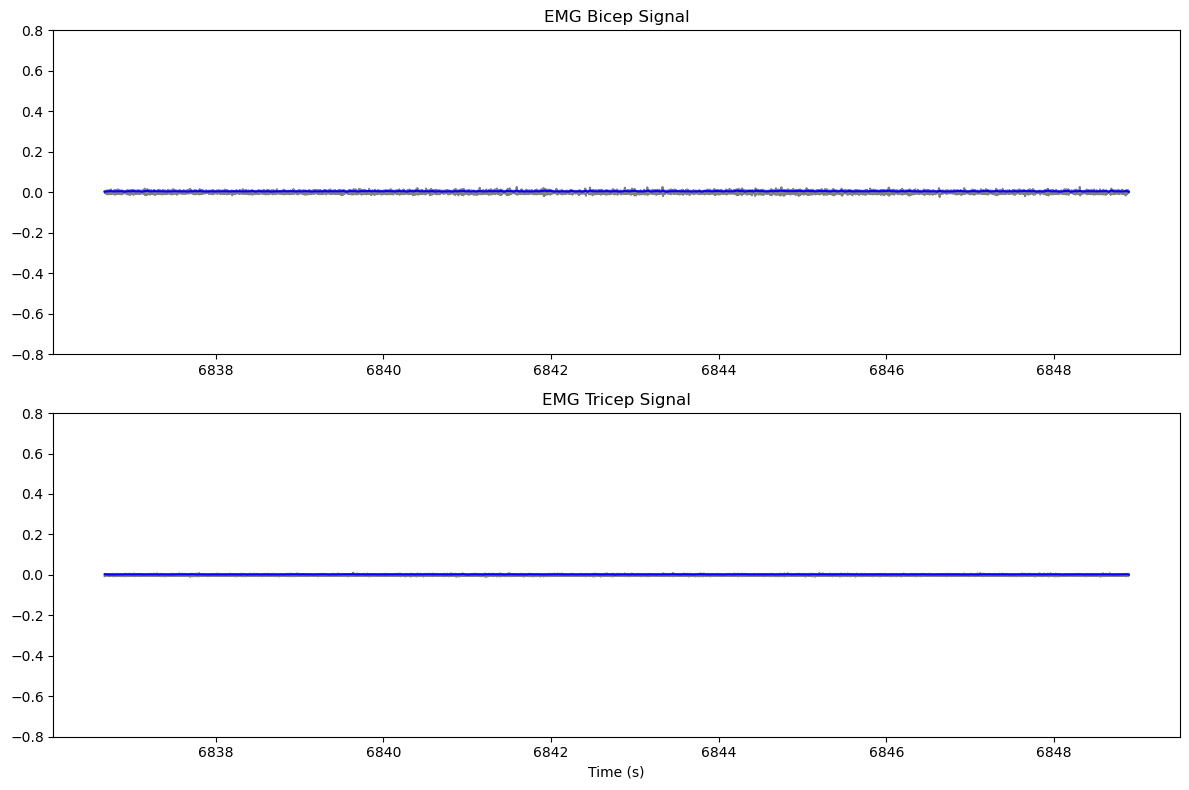

Filtered EMG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_EMG_P1_Vision_NoMovement_3.csv
Processing LSL file:  T1_experiment_PLUX_P1_Vision_NoMovement_4_StartParticipantSinging_Vision_NoMovement_4_EndParticipantSinging.csv


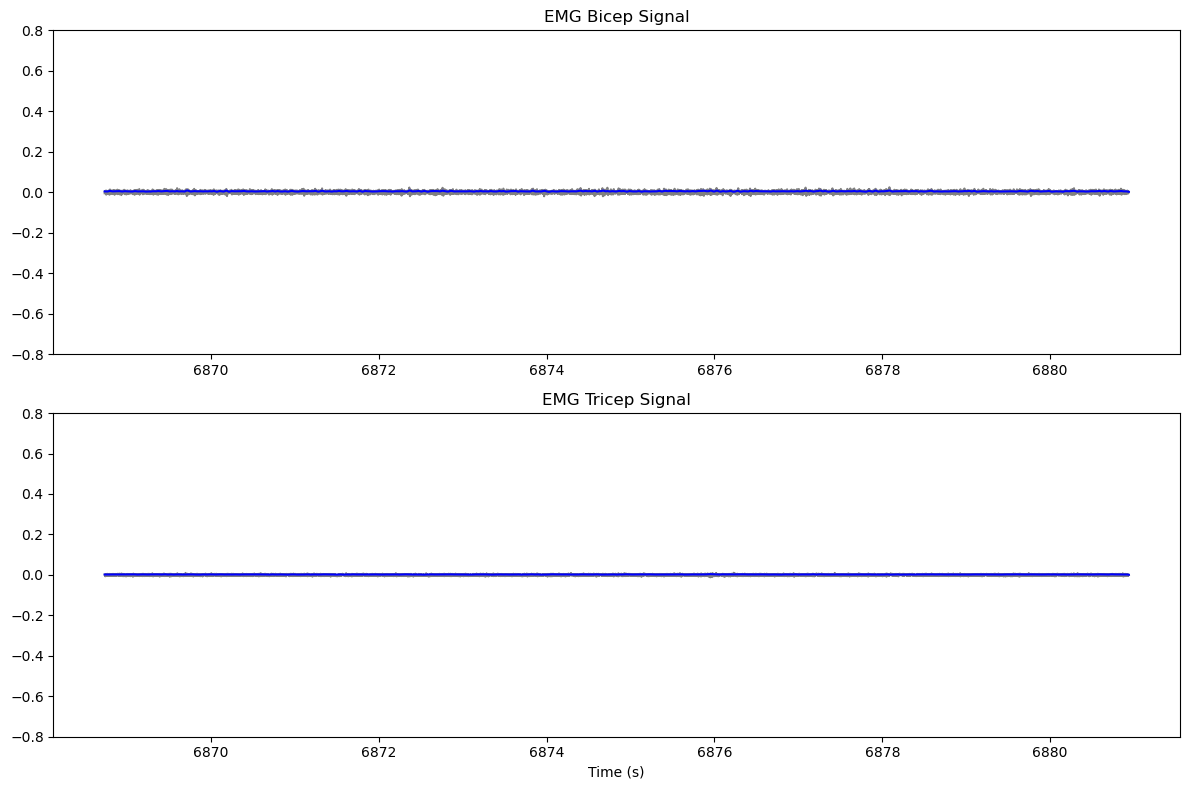

Filtered EMG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_EMG_P1_Vision_NoMovement_4.csv
Processing LSL file:  T1_experiment_PLUX_P2_NoVision_Movement_0_StartParticipantSinging_NoVision_Movement_0_EndParticipantSinging.csv


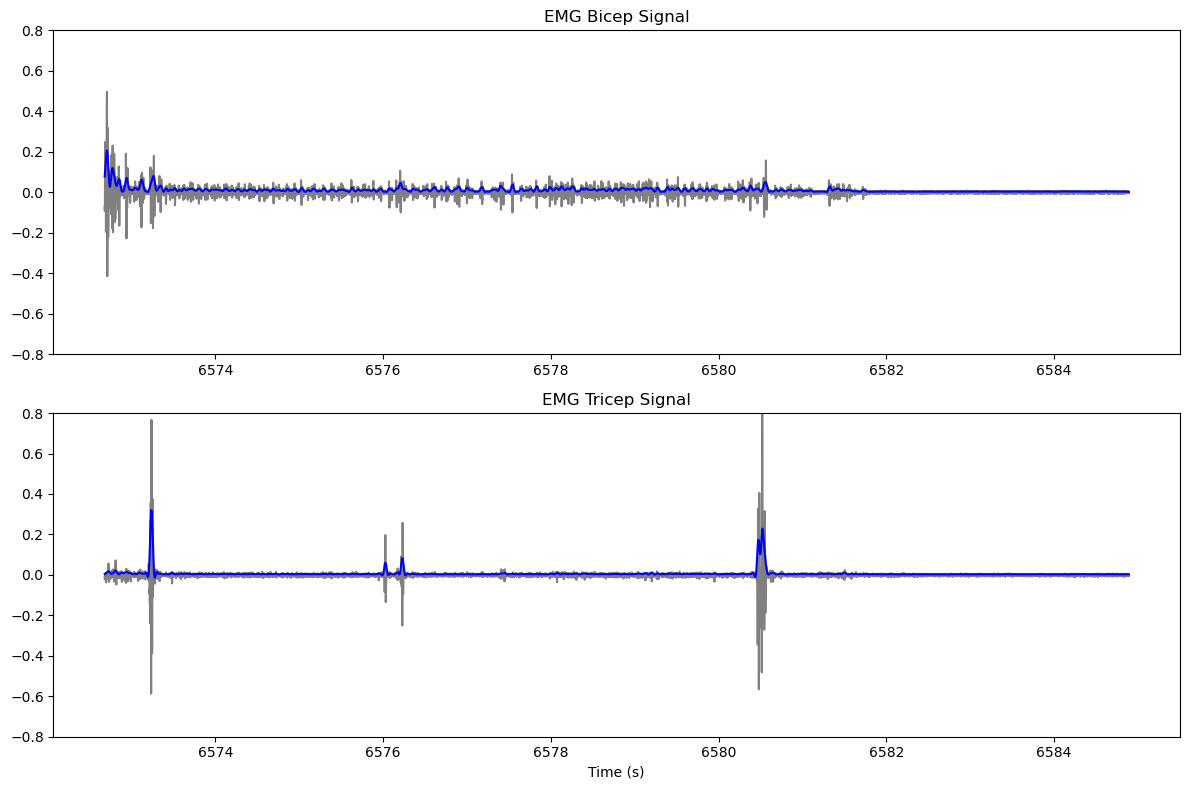

Filtered EMG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_EMG_P2_NoVision_Movement_0.csv
Processing LSL file:  T1_experiment_PLUX_P2_NoVision_Movement_1_StartParticipantSinging_NoVision_Movement_1_EndParticipantSinging.csv


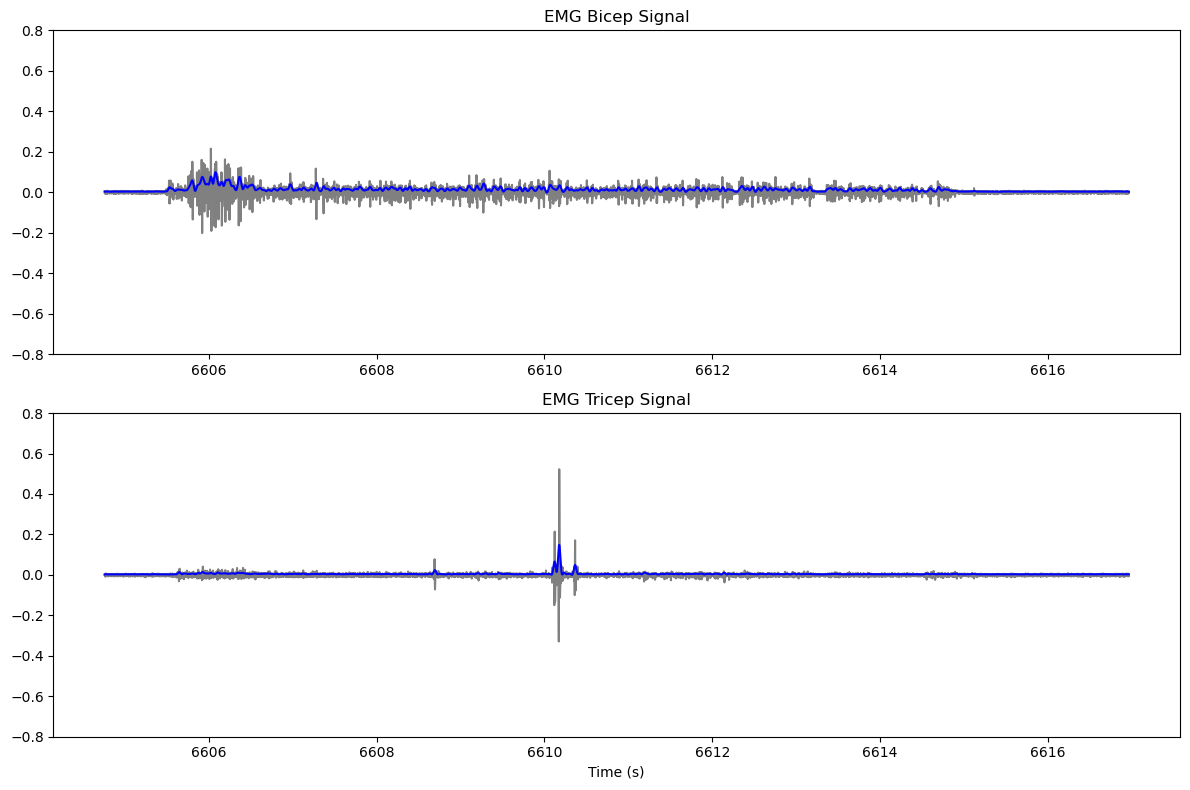

Filtered EMG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_EMG_P2_NoVision_Movement_1.csv
Processing LSL file:  T1_experiment_PLUX_P2_NoVision_Movement_2_StartParticipantSinging_NoVision_Movement_2_EndParticipantSinging.csv


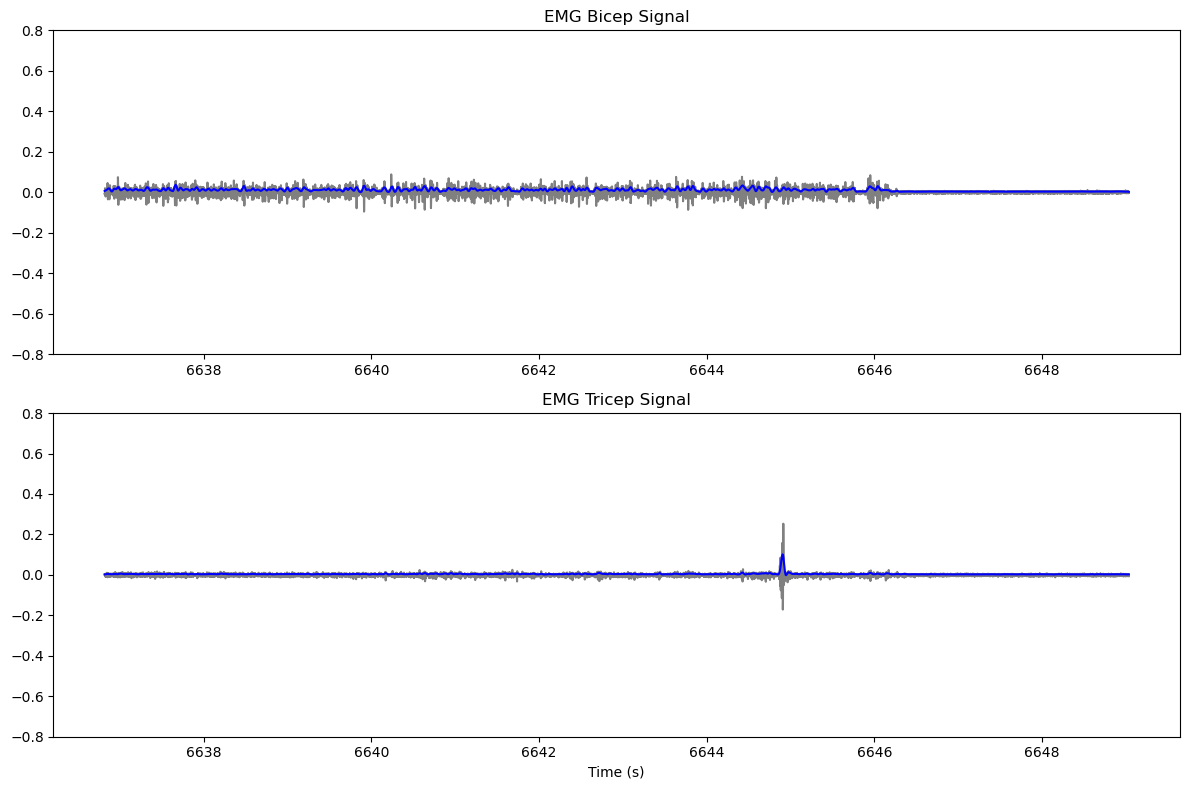

Filtered EMG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_EMG_P2_NoVision_Movement_2.csv
Processing LSL file:  T1_experiment_PLUX_P2_NoVision_Movement_3_StartParticipantSinging_NoVision_Movement_3_EndParticipantSinging.csv


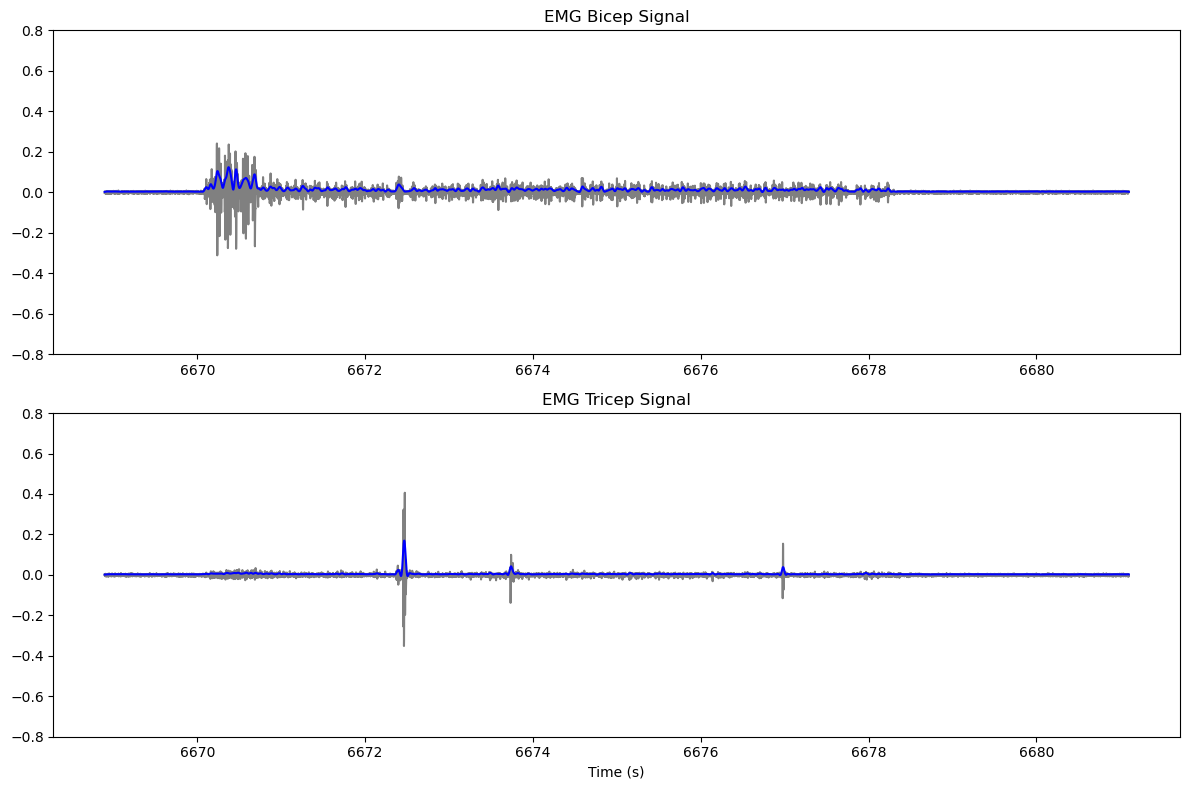

Filtered EMG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_EMG_P2_NoVision_Movement_3.csv
Processing LSL file:  T1_experiment_PLUX_P2_NoVision_Movement_4_StartParticipantSinging_NoVision_Movement_4_EndParticipantSinging.csv


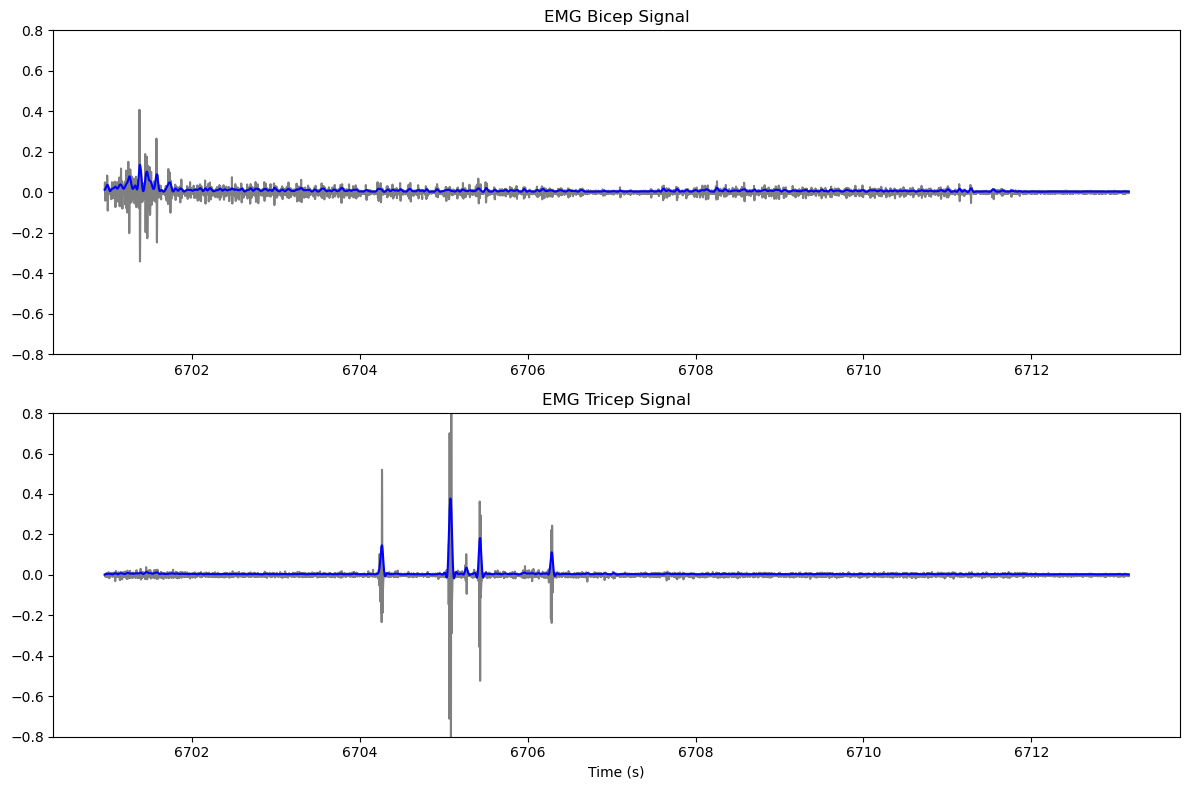

Filtered EMG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_EMG_P2_NoVision_Movement_4.csv
Processing LSL file:  T1_experiment_PLUX_P2_NoVision_NoMovement_0_StartParticipantSinging_NoVision_NoMovement_0_EndParticipantSinging.csv


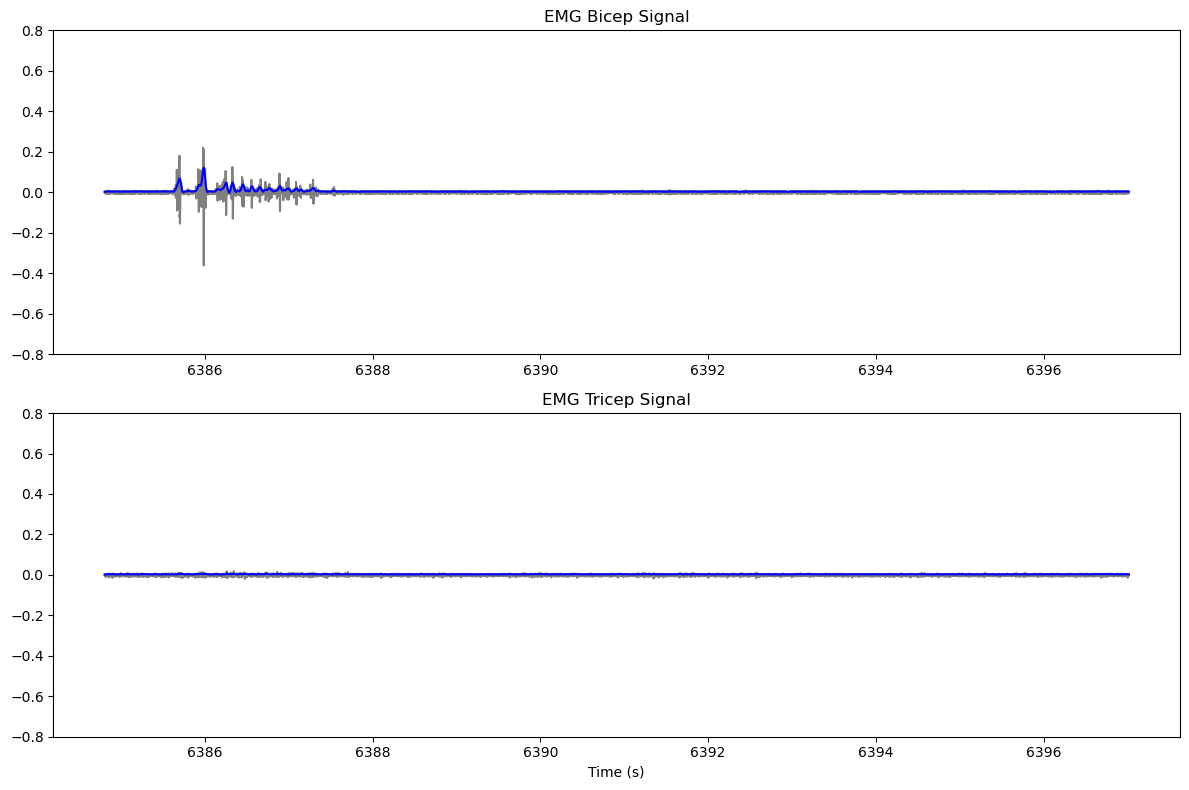

Filtered EMG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_EMG_P2_NoVision_NoMovement_0.csv
Processing LSL file:  T1_experiment_PLUX_P2_NoVision_NoMovement_1_StartParticipantSinging_NoVision_NoMovement_1_EndParticipantSinging.csv


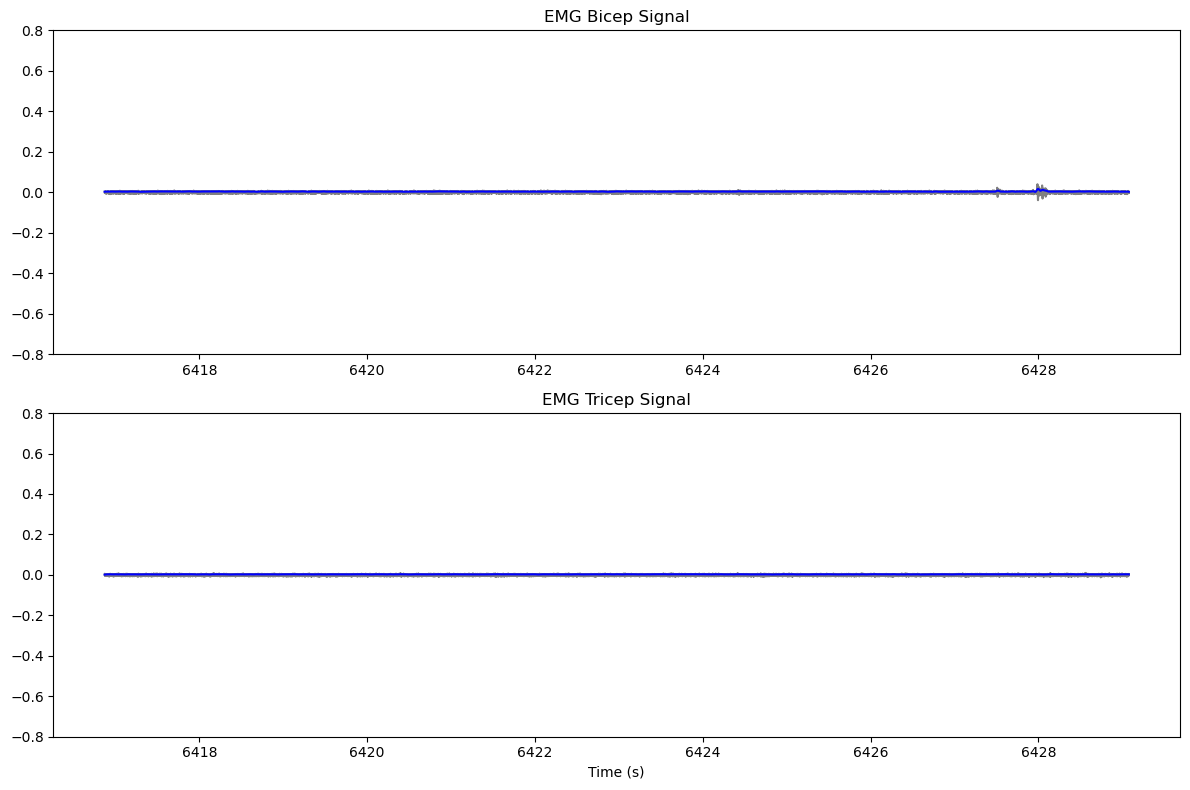

Filtered EMG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_EMG_P2_NoVision_NoMovement_1.csv
Processing LSL file:  T1_experiment_PLUX_P2_NoVision_NoMovement_2_StartParticipantSinging_NoVision_NoMovement_2_EndParticipantSinging.csv


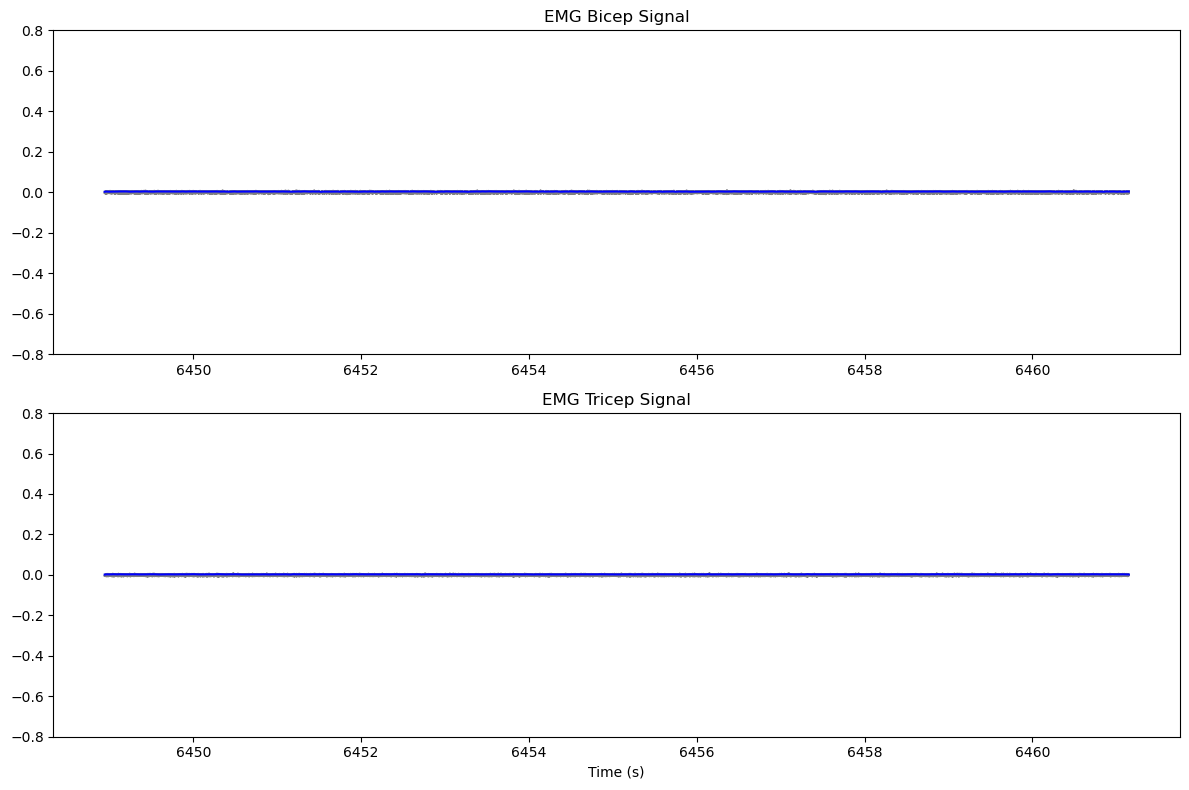

Filtered EMG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_EMG_P2_NoVision_NoMovement_2.csv
Processing LSL file:  T1_experiment_PLUX_P2_NoVision_NoMovement_3_StartParticipantSinging_NoVision_NoMovement_3_EndParticipantSinging.csv


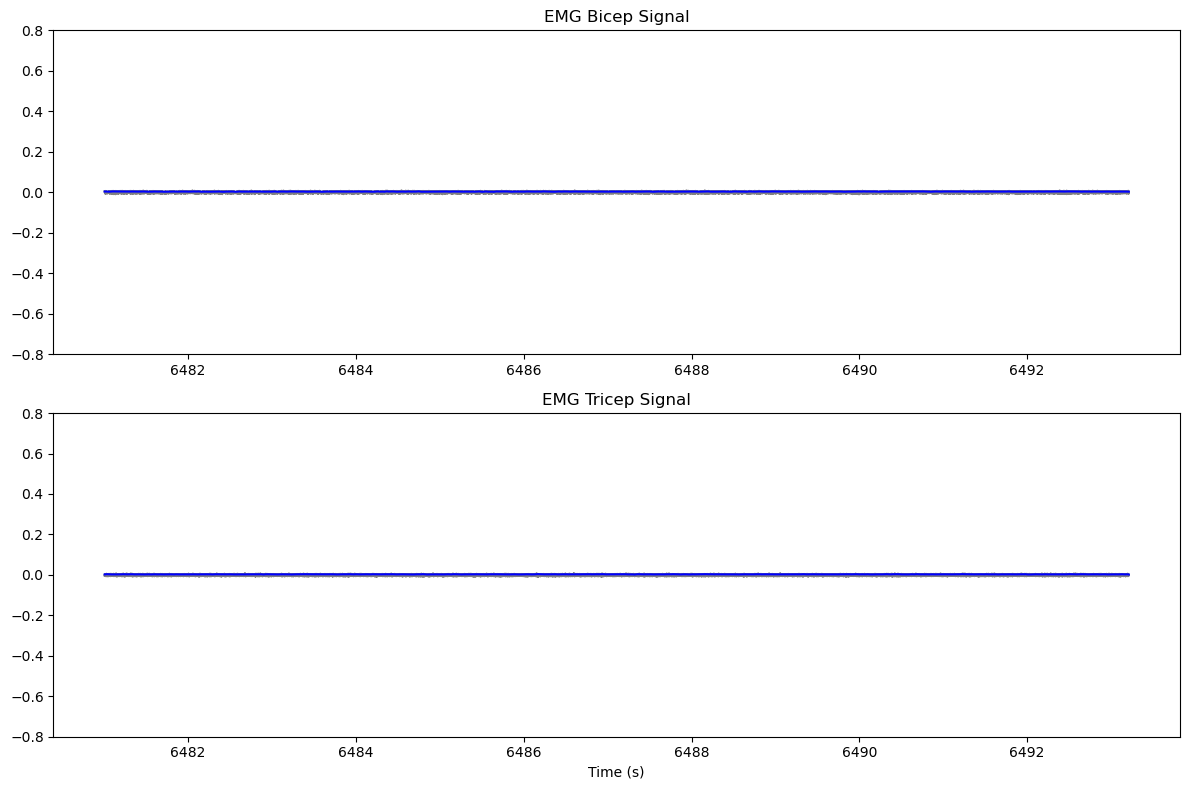

Filtered EMG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_EMG_P2_NoVision_NoMovement_3.csv
Processing LSL file:  T1_experiment_PLUX_P2_NoVision_NoMovement_4_StartParticipantSinging_NoVision_NoMovement_4_EndParticipantSinging.csv


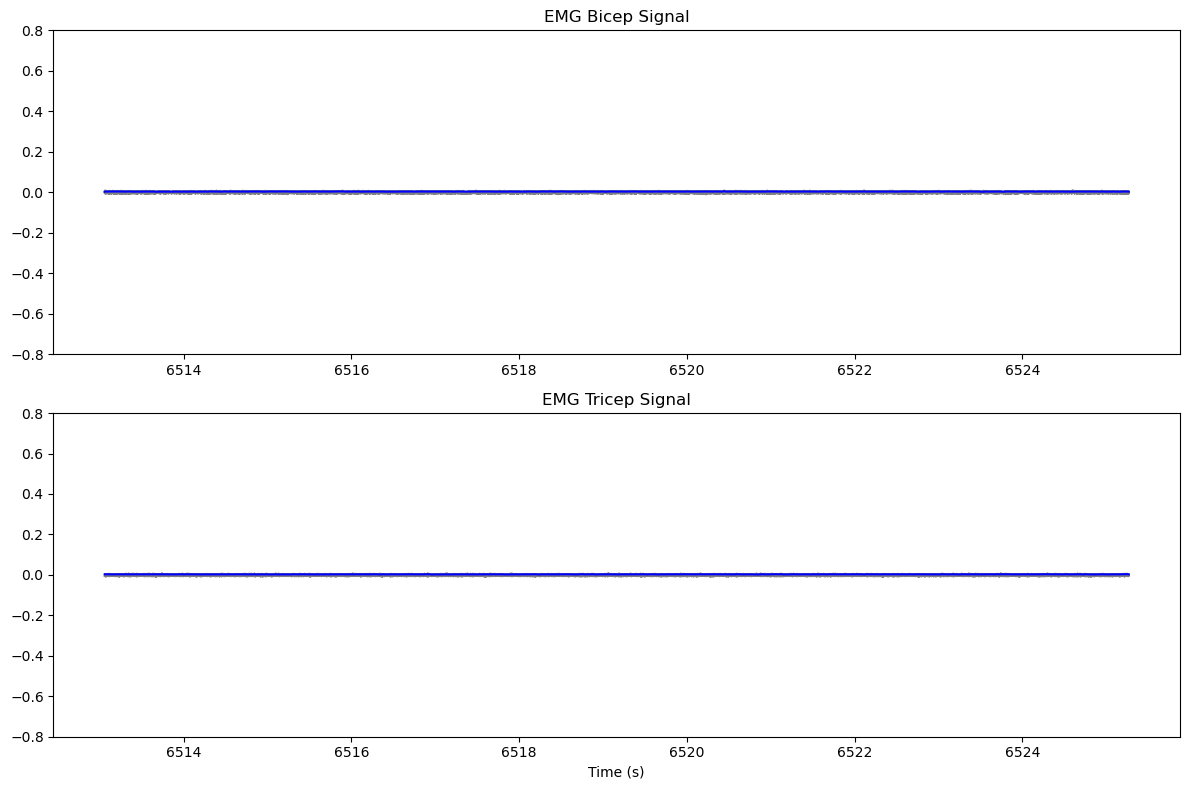

Filtered EMG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_EMG_P2_NoVision_NoMovement_4.csv
Processing LSL file:  T1_experiment_PLUX_P2_Vision_Movement_0_StartParticipantSinging_Vision_Movement_0_EndParticipantSinging.csv


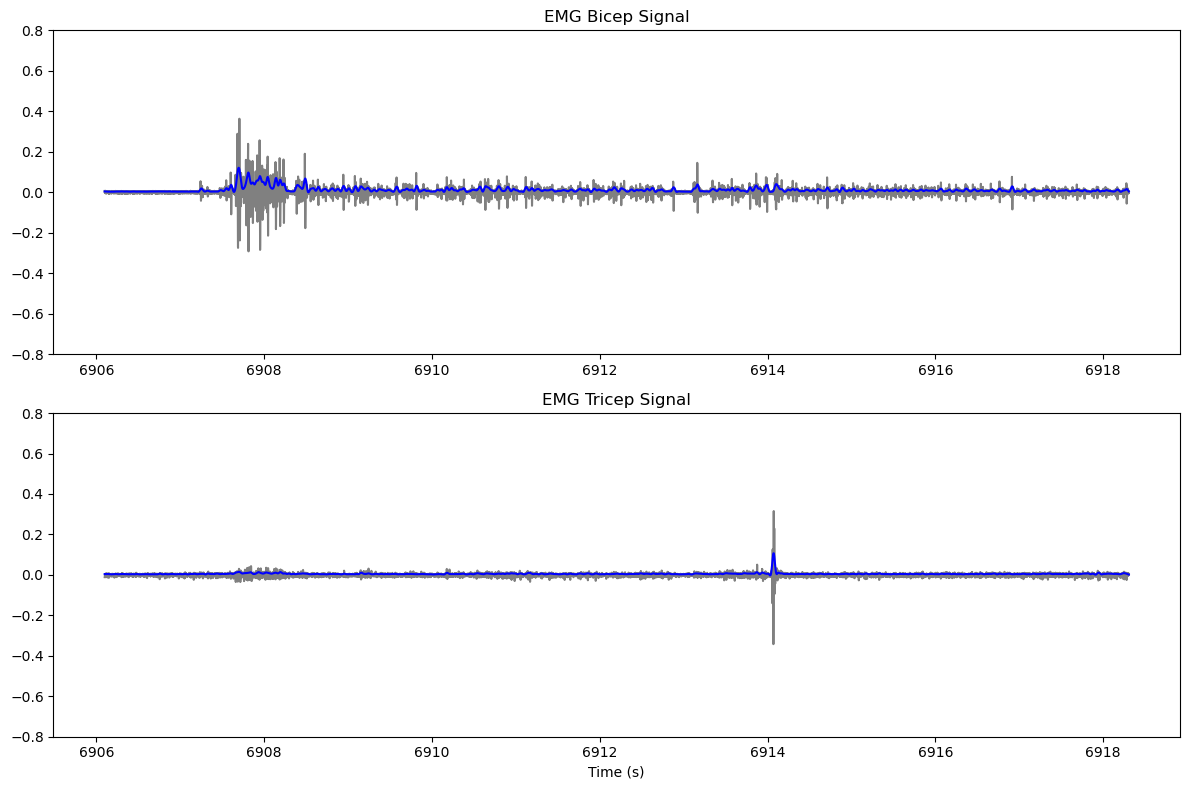

Filtered EMG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_EMG_P2_Vision_Movement_0.csv
Processing LSL file:  T1_experiment_PLUX_P2_Vision_Movement_1_StartParticipantSinging_Vision_Movement_1_EndParticipantSinging.csv


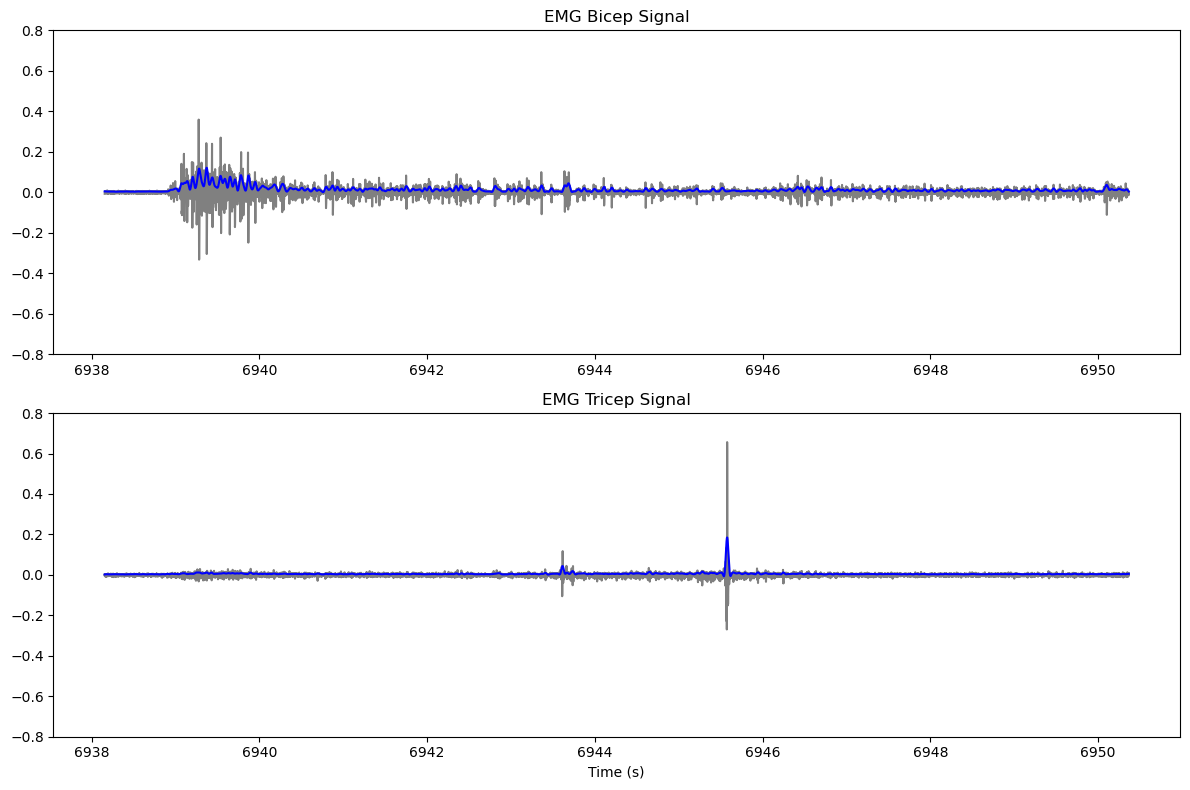

Filtered EMG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_EMG_P2_Vision_Movement_1.csv
Processing LSL file:  T1_experiment_PLUX_P2_Vision_Movement_2_StartParticipantSinging_Vision_Movement_2_EndParticipantSinging.csv


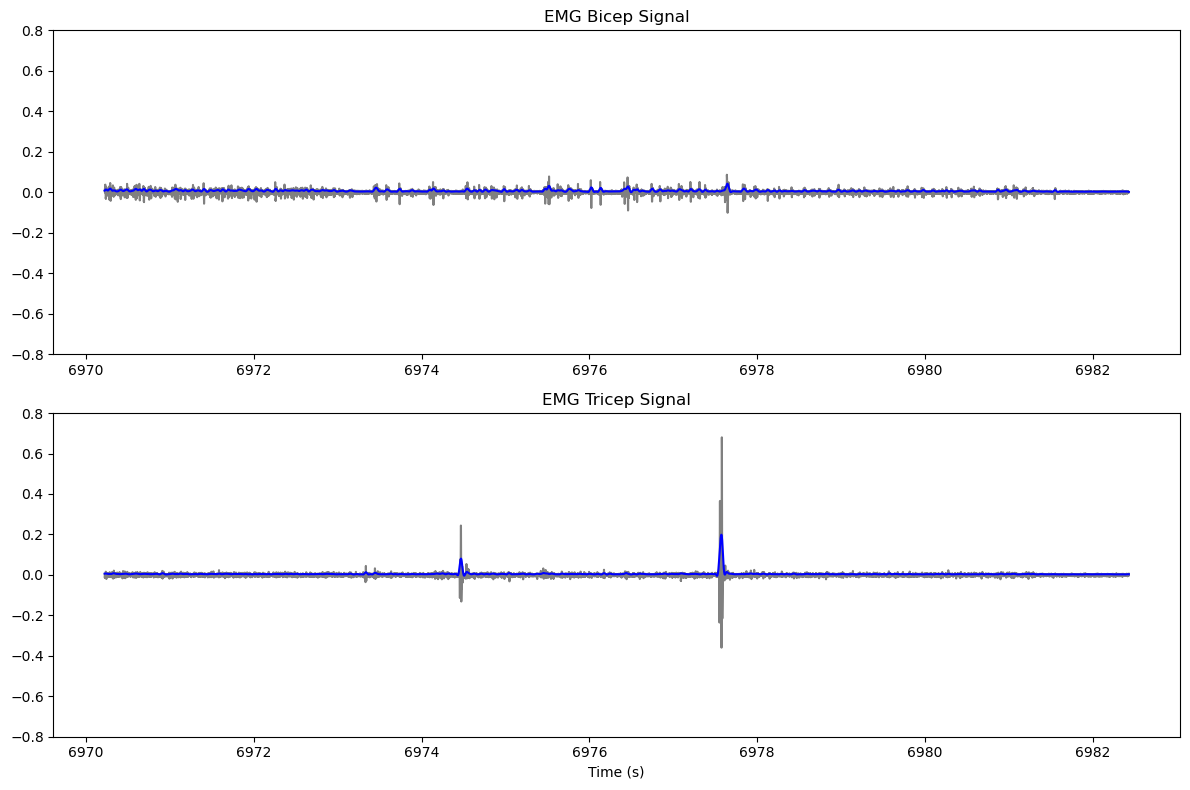

Filtered EMG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_EMG_P2_Vision_Movement_2.csv
Processing LSL file:  T1_experiment_PLUX_P2_Vision_Movement_3_StartParticipantSinging_Vision_Movement_3_EndParticipantSinging.csv


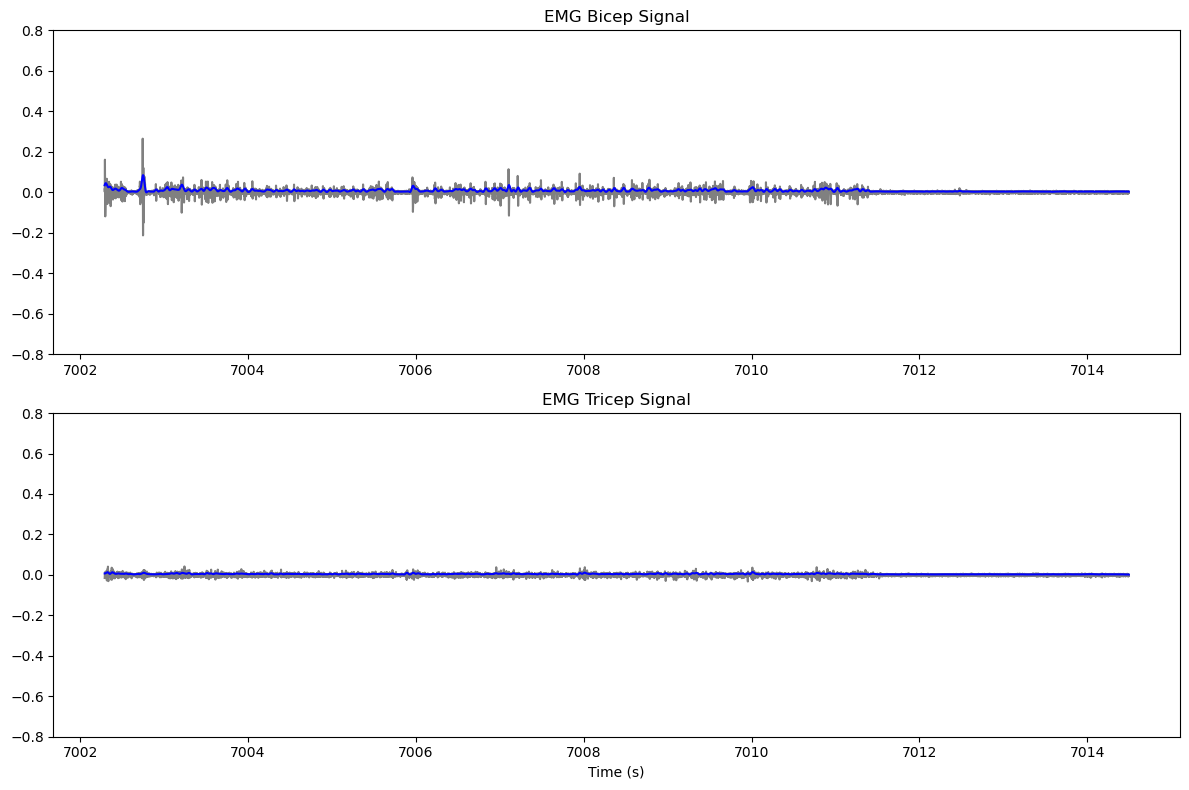

Filtered EMG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_EMG_P2_Vision_Movement_3.csv
Processing LSL file:  T1_experiment_PLUX_P2_Vision_Movement_4_StartParticipantSinging_Vision_Movement_4_EndParticipantSinging.csv


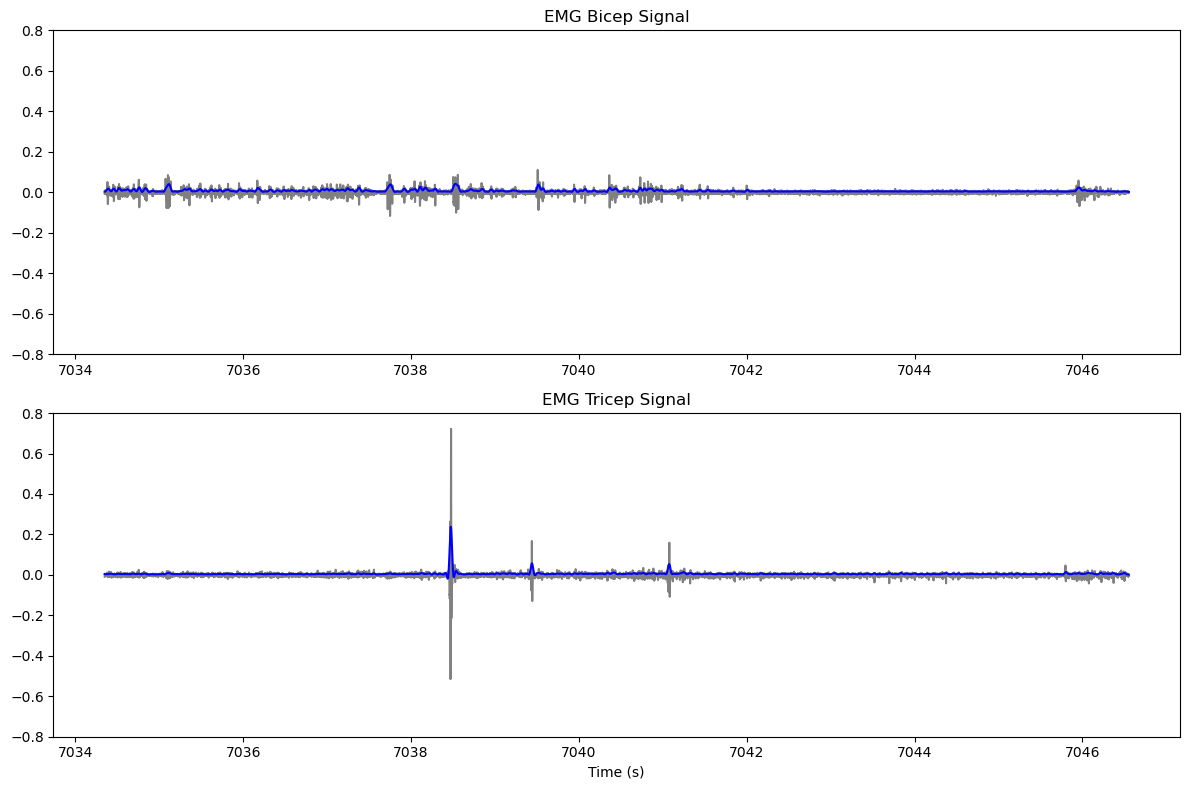

Filtered EMG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_EMG_P2_Vision_Movement_4.csv
Processing LSL file:  T1_experiment_PLUX_P2_Vision_NoMovement_0_StartParticipantSinging_Vision_NoMovement_0_EndParticipantSinging.csv


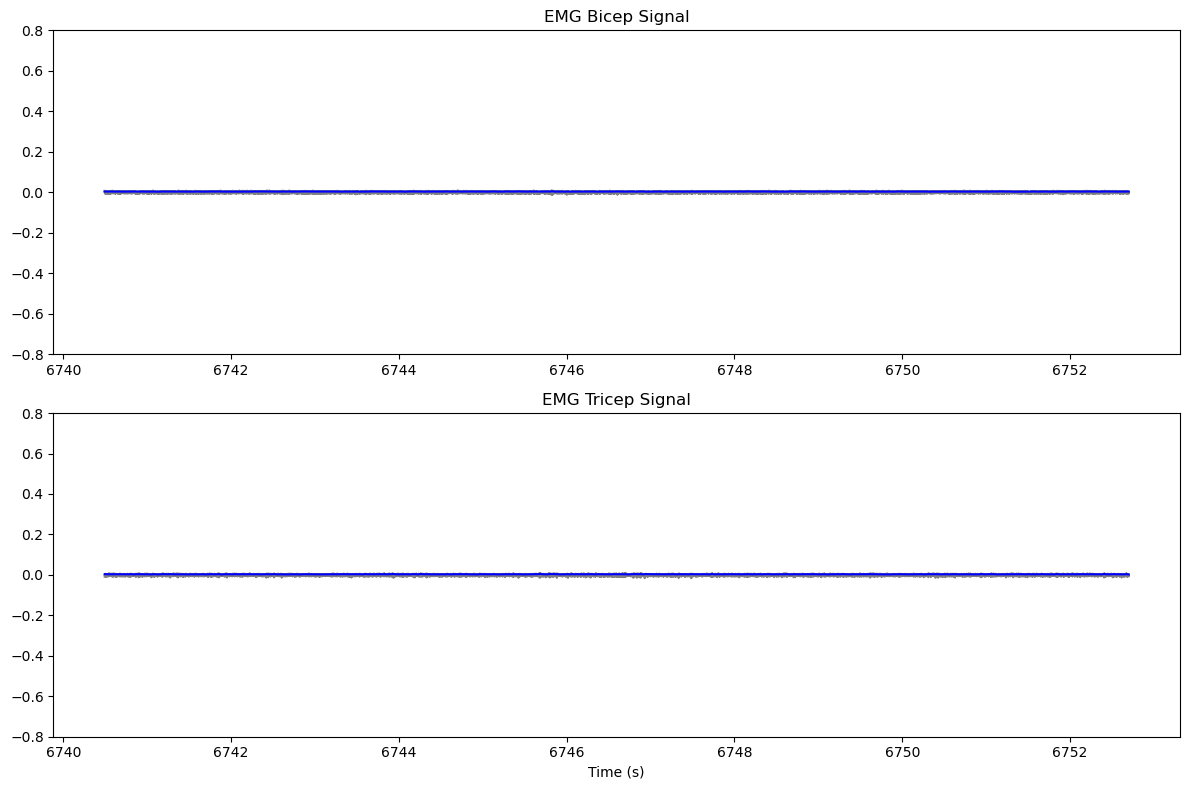

Filtered EMG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_EMG_P2_Vision_NoMovement_0.csv
Processing LSL file:  T1_experiment_PLUX_P2_Vision_NoMovement_1_StartParticipantSinging_Vision_NoMovement_1_EndParticipantSinging.csv


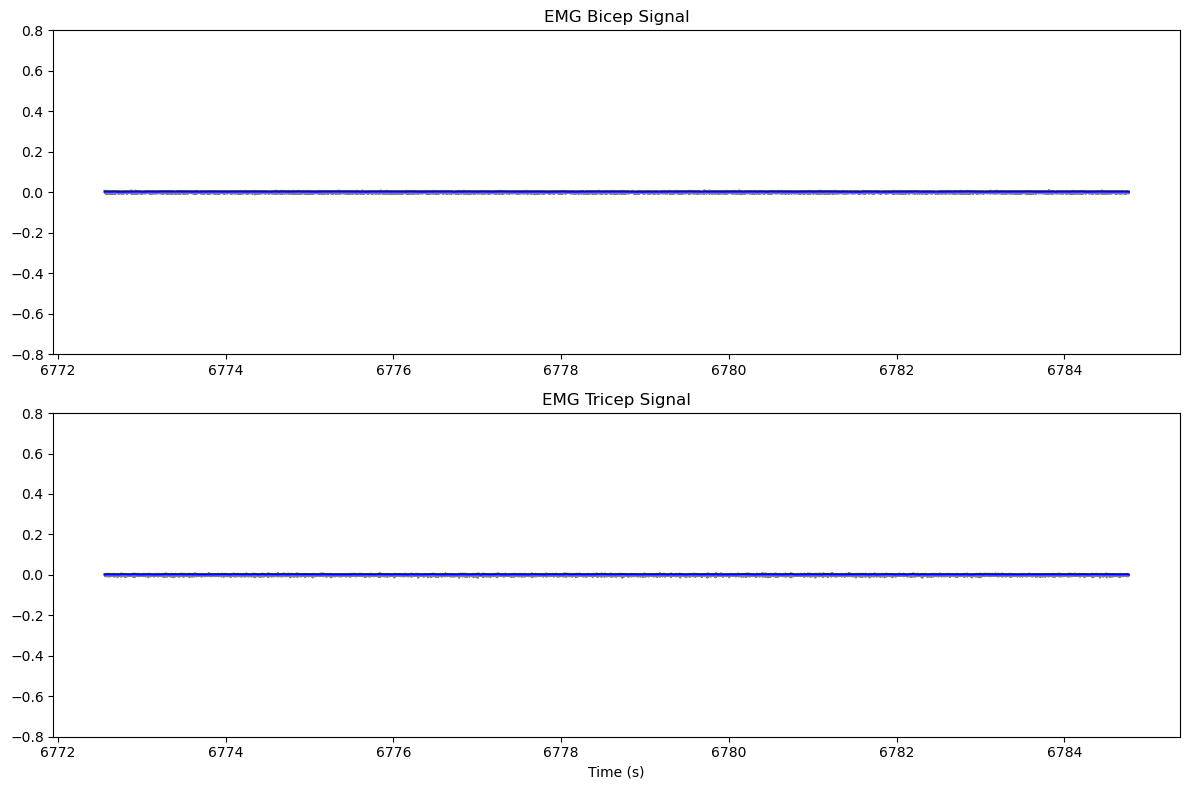

Filtered EMG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_EMG_P2_Vision_NoMovement_1.csv
Processing LSL file:  T1_experiment_PLUX_P2_Vision_NoMovement_2_StartParticipantSinging_Vision_NoMovement_2_EndParticipantSinging.csv


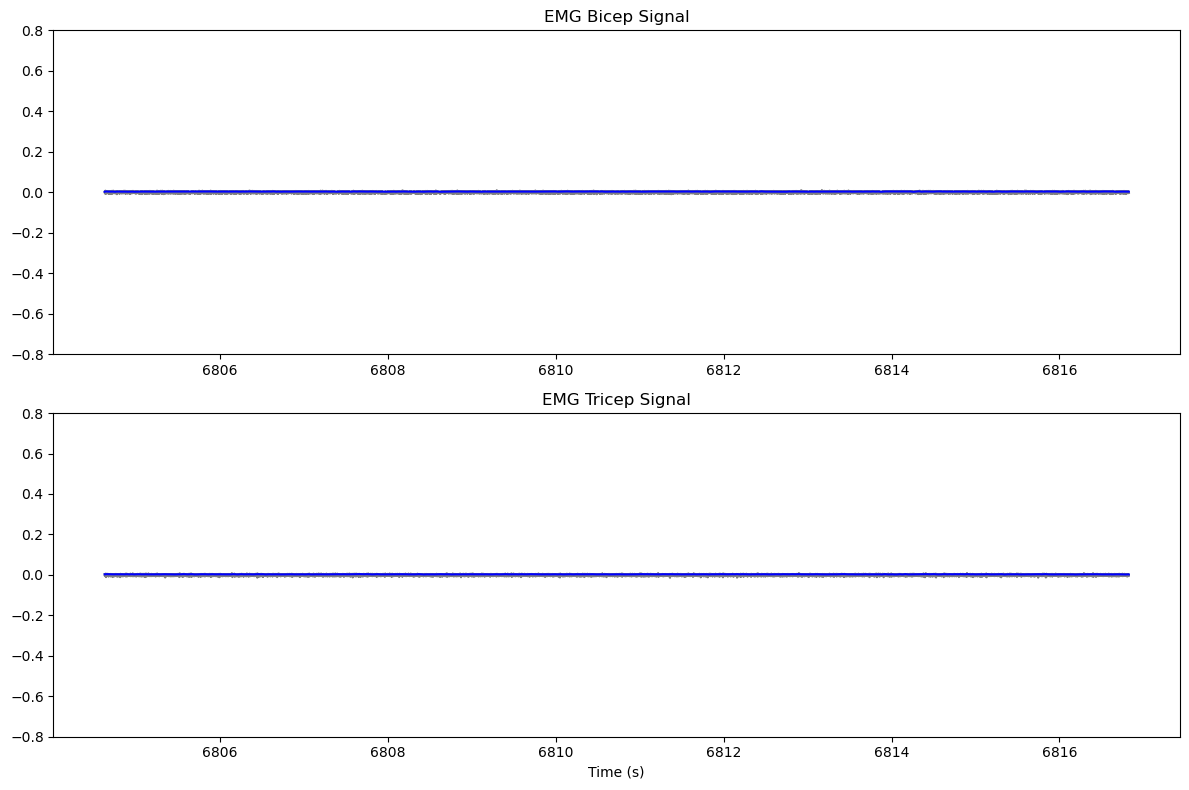

Filtered EMG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_EMG_P2_Vision_NoMovement_2.csv
Processing LSL file:  T1_experiment_PLUX_P2_Vision_NoMovement_3_StartParticipantSinging_Vision_NoMovement_3_EndParticipantSinging.csv


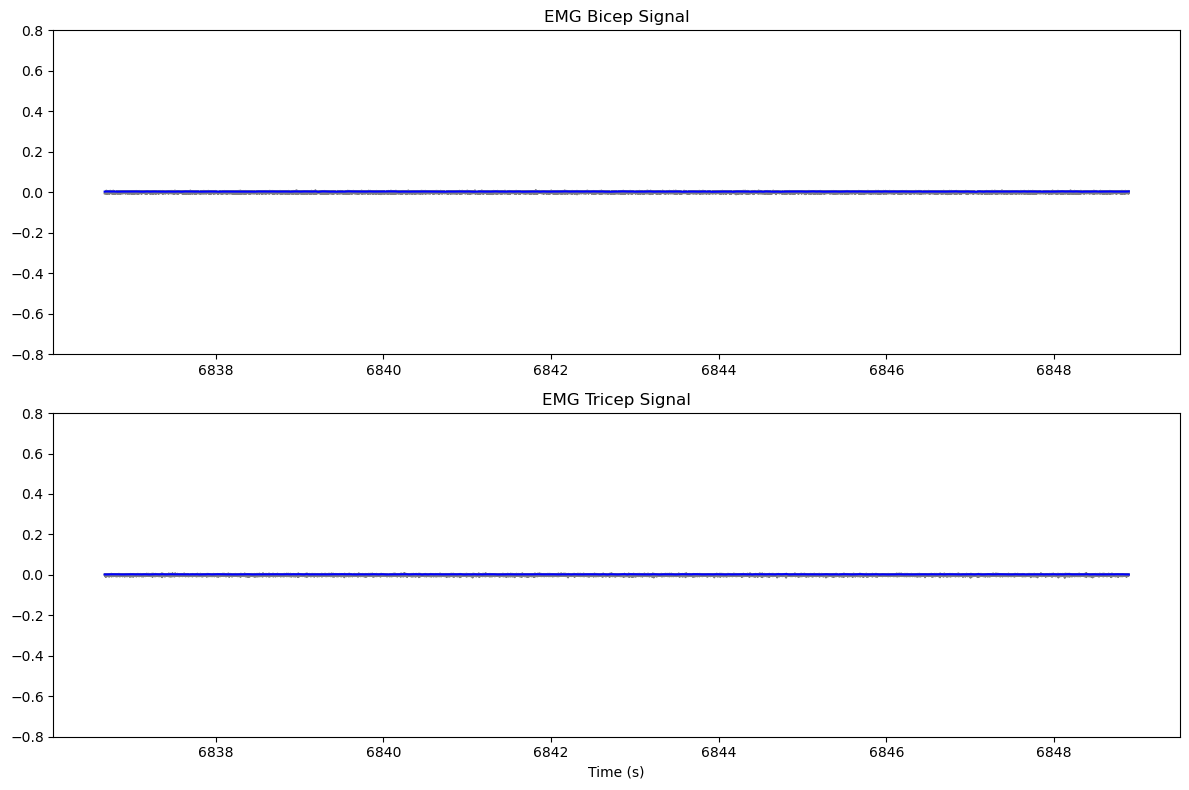

Filtered EMG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_EMG_P2_Vision_NoMovement_3.csv
Processing LSL file:  T1_experiment_PLUX_P2_Vision_NoMovement_4_StartParticipantSinging_Vision_NoMovement_4_EndParticipantSinging.csv


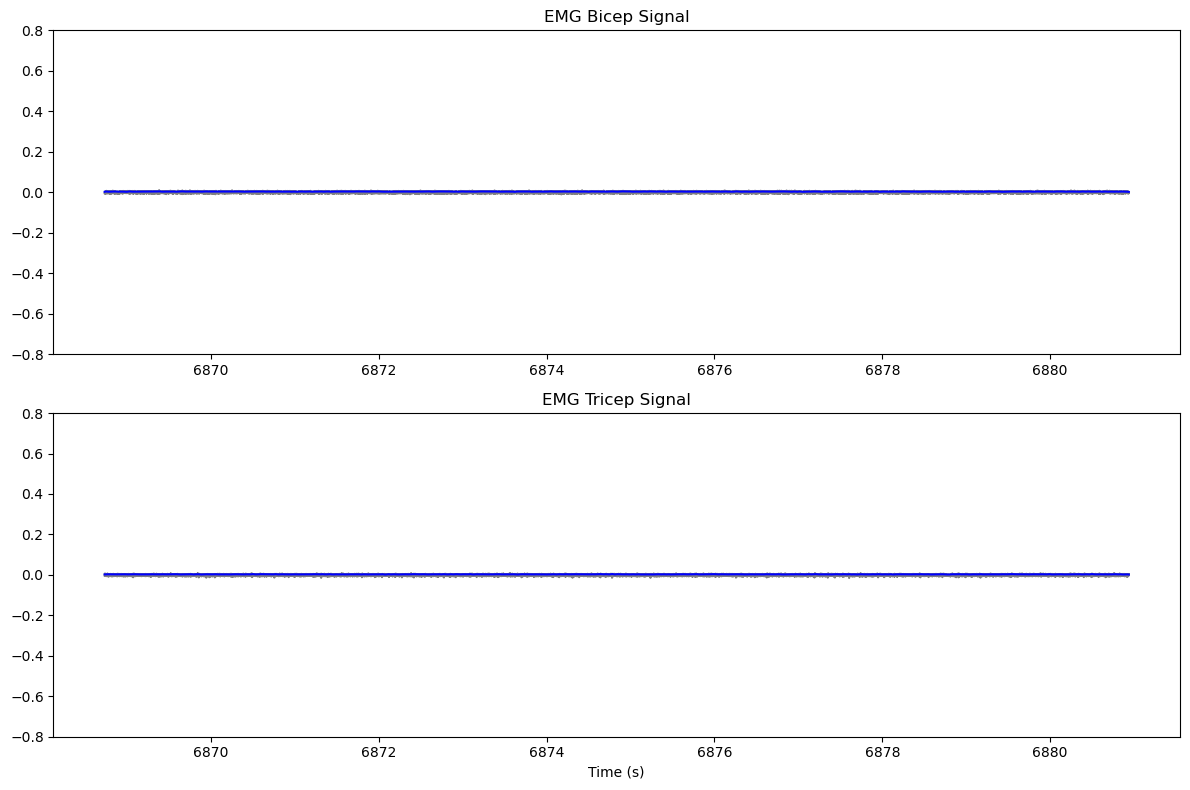

Filtered EMG data saved to:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials\T1_experiment_EMG_P2_Vision_NoMovement_4.csv
All files processed successfully. You can look in the directory:  D:\Mobile-Multimodal-Lab\4_PROCESSED\filtered_trials


In [ ]:
# Define Butterworth filter function
def butter_filter(data, cutoff, fs, order=4, filter_type='low'):
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype=filter_type, analog=False)
    # Apply zero-phase filtering with padding to prevent edge effects
    padded_data = np.pad(data, (1000, 1000), 'edge')
    filtered_data = filtfilt(b, a, padded_data)
    return filtered_data[1000:-1000]  # Remove padding

# High-pass filter, rectify, and then low-pass filter EMG signals
def process_emg(emg_signal, fs, cutoff_high, cutoff_low):
    # Apply high-pass filter
    high_passed = butter_filter(emg_signal, cutoff_high, fs, order=4, filter_type='high')
    # Rectify (full-wave rectification)
    rectified = np.abs(high_passed)
    # Apply low-pass filter
    low_passed = butter_filter(rectified, cutoff_low, fs, order=4, filter_type='low')
    return low_passed


sampling_rate = 1000    

for root, dirs, files in os.walk(input_folder):  # Loop through all files in the input directory
    for file in files:                                  # Loop through all files in the input directory
        
        for P in participants:                        # Loop through P1 and P2 
           
            # Find the LSL csv file 
            if P in file and 'PLUX' in file and file.endswith(".csv"):   # Check if the file contains the keyword and is a .wav file
                print("Processing LSL file: ", os.path.basename(file))

                LSL_filename = os.path.join(root, file)
                LSL_data = pd.read_csv(LSL_filename)

                LSL_Time = LSL_data['LSL_Time']

                # EMG bicep is in the 4th column 
                EMG_bicep = LSL_data.iloc[:, 3].values

                # EMG tricep is in the 5th column
                EMG_tricep = LSL_data.iloc[:, 4].values
            

                # Filter the EMG data with high and low pass filters
                EMG_bicep_processed = process_emg(EMG_bicep, sampling_rate, 30, 20)  # 30 Hz high-pass, 20 Hz low-pass
                EMG_tricep_processed = process_emg(EMG_tricep, sampling_rate, 30, 20)  # 30 Hz high-pass, 20 Hz low-pass

                
                
                # Plot the Raw and Filtered EMG signals in two subplots
                plt.figure(figsize=(12, 8))
                plt.subplot(2, 1, 1)
                plt.plot(LSL_Time, EMG_bicep, label='Raw EMG Bicep', color='gray')
                plt.plot(LSL_Time, EMG_bicep_processed, label='Filtered EMG Bicep', color='blue')
                plt.ylim(-0.8, 0.8)
                plt.title('EMG Bicep Signal')
                plt.subplot(2, 1, 2)
                plt.plot(LSL_Time, EMG_tricep, label='Raw EMG Tricep', color='gray')
                plt.plot(LSL_Time, EMG_tricep_processed, label='Filtered EMG Tricep', color='blue')
                plt.title('EMG Tricep Signal')
                plt.xlabel('Time (s)')
                #set the y-axis limits to the same range for both subplots
                plt.ylim(-0.8, 0.8)
                plt.tight_layout()
                plt.show()

                # Save the filtered EMG data to a CSV file
                filename_base = os.path.basename(file)
                parts = filename_base.split('_')
                # Get the first 7 parts and join them back with underscores (i.e., until the trial number)
                new_name = '_'.join(parts[:7])
                # Replace "PLUX" with "EMG" in the base name
                new_name = new_name.replace('PLUX', 'EMG')
                # Save the filtered EMG data to a CSV file in the output folder
                output_filename = os.path.join(output_folder, new_name + '.csv')
                # Create a DataFrame with the filtered EMG data
                EMG_df = pd.DataFrame({
                    'Time': LSL_Time,
                    'Filtered_EMG_Bicep': EMG_bicep_processed,
                    'Filtered_EMG_Tricep': EMG_tricep_processed
                })
                # Save the DataFrame to a CSV file
                EMG_df.to_csv(output_filename, index=False)
                print("Filtered EMG data saved to: ", output_filename)

print("All files processed successfully. You can look in the directory: ", output_folder)

                

---

In [ ]:
# PITCH ENVELOPE EXTRACTION FROM AUDIO FLES (OLD, WE'RE WORKIGN WITH AMPLITUDE INSTEAD)

for root, dirs, files in os.walk(input_folder):  # Loop through all files in the input directory
   
    for file in files:                                  # Loop through all files in the input directory
        
        for P in participants:                        # Loop through P1 and P2 
           
            # Find the LSL csv file 
            if P in file and 'Mic' in file and file.endswith(".csv"):   # Check if the file contains the keyword and is a .wav file
                print("Processing LSL file: ", os.path.basename(file))

                LSL_filename = os.path.join(root, file)
                
                LSL_data = pd.read_csv(LSL_filename)
                
                LSL_Time = LSL_data['LSL_Time']

                # Get the start and end time of the LSL 
                start_time = LSL_Time.iloc[0]
                end_time = LSL_Time.iloc[-1]
                duration = end_time - start_time  # Total duration of the LSL time
                
            # Find the corresponding audio file
            if P in file and audio_keyword in file and file.endswith(".wav"):
                print("Processing audio file: ", os.path.basename(file))

                audio_filename = os.path.join(root, file)
                audio_data, sr = librosa.load(audio_filename, sr=None)
                print("the sample rate of the audio file is: ", sr)

                # Extract pitch using the YIN algorithm
                print("Extracting pitch using YIN algorithm...")
                f0, times = extract_pitch_yin(audio_data, sr)

                # Smoothing the pitch contour with a moving average filter
                print("Smoothing the pitch contour...")
                f0_smooth = uniform_filter1d(f0, size=5)


                # Save the Pitch and Smoothed Pitch to data frame
                pitch_df = pd.DataFrame({
                    'Time': times ,
                    'Pitch': f0,
                    'Smooth_Pitch': f0_smooth
                })

                # Create the output CSV file
                filename_base = os.path.basename(file)  # Just the filename, not full path
                parts = filename_base.split('_')  # Split by underscore
                # Get the first 7 parts and join them back with underscores (i.e., until the trial number)
                new_name = '_'.join(parts[:7])
                # Replace "Mic" with "AudioPitch" in the base name
                new_name = new_name.replace('Mic', 'AudioPitch')

                # save the ptich data to a CSV file in teh output folder 
                output_filename = os.path.join(output_folder, new_name + '.csv')
                pitch_df.to_csv(output_filename, index=False)
                print("Pitch data saved to: ", output_filename)


                ## PLOTTING ##
                # Create a plot 3 subplots: the raw audio, the pitch contour, and the smoothed pitch contour
                plt.figure(figsize=(12, 8))
                plt.subplot(3, 1, 1)
                plt.plot(LSL_Time, audio_data, label='Raw Audio', color='gray')
                plt.title('Raw Audio Signal')

                plt.subplot(3, 1, 2)
                plt.plot(times, f0, label='Pitch Contour', color='blue')
                plt.title('Pitch Contour')
                plt.subplot(3, 1, 3)

                plt.plot(times, f0_smooth, label='Smoothed Pitch Contour', color='red')
                plt.title('Smoothed Pitch Contour')
                plt.xlabel('Time (s)')
                plt.tight_layout()
                plt.show()

        
                0/0


